In [58]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [59]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [60]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [61]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [62]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [63]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [64]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [65]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [66]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [67]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [68]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [69]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [70]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [71]:
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

KeyError: "['임신 시도 또는 마지막 임신 경과 연수'] not found in axis"

In [72]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부',
       '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [73]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [74]:
len(categorical_columns) + len(numeric_columns)

59

In [75]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [76]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 67), (90067, 67))

In [77]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [78]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [81]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [83]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 40)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-21 21:28:14,096] A new study created in memory with name: no-name-809624ee-a341-4fee-b7ac-da8aeb8b583c


Seed 4972 Start!
0:	test: 0.7161758	best: 0.7161758 (0)	total: 118ms	remaining: 4m 39s
300:	test: 0.7387540	best: 0.7387540 (300)	total: 35.6s	remaining: 4m 4s
600:	test: 0.7400686	best: 0.7400728 (589)	total: 1m 13s	remaining: 3m 36s
900:	test: 0.7406008	best: 0.7406119 (892)	total: 1m 54s	remaining: 3m 6s
1200:	test: 0.7407464	best: 0.7407542 (1190)	total: 2m 37s	remaining: 2m 33s
1500:	test: 0.7408787	best: 0.7408936 (1467)	total: 3m 26s	remaining: 1m 59s
1800:	test: 0.7409551	best: 0.7410085 (1708)	total: 4m 14s	remaining: 1m 19s


[I 2025-02-21 21:33:02,661] Trial 0 finished with value: 0.7410084705745688 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410084706
bestIteration = 1708

Shrink model to first 1709 iterations.
저장 완료
0:	test: 0.6946616	best: 0.6946616 (0)	total: 49.6ms	remaining: 1m 48s


Training has stopped (degenerate solution on iteration 232, probably too small l2-regularization, try to increase it)
[I 2025-02-21 21:33:12,604] Trial 1 finished with value: 0.7282318075732872 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7410084705745688.



bestTest = 0.7282318076
bestIteration = 231

Shrink model to first 232 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 48.5ms	remaining: 2m 2s
300:	test: 0.7408920	best: 0.7408920 (300)	total: 14s	remaining: 1m 43s
600:	test: 0.7400776	best: 0.7409930 (315)	total: 28.6s	remaining: 1m 31s


[I 2025-02-21 21:33:42,077] Trial 2 finished with value: 0.7409929968448441 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409929968
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 45.4ms	remaining: 1m 46s
300:	test: 0.7391779	best: 0.7391779 (300)	total: 13.4s	remaining: 1m 30s
600:	test: 0.7402539	best: 0.7402637 (597)	total: 27.8s	remaining: 1m 20s
900:	test: 0.7402192	best: 0.7404415 (803)	total: 42.4s	remaining: 1m 7s


[I 2025-02-21 21:34:34,492] Trial 3 finished with value: 0.7404415412298581 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404415412
bestIteration = 803

Shrink model to first 804 iterations.
0:	test: 0.7228048	best: 0.7228048 (0)	total: 103ms	remaining: 3m
300:	test: 0.7381428	best: 0.7381428 (300)	total: 36.4s	remaining: 2m 54s
600:	test: 0.7389412	best: 0.7389631 (597)	total: 1m 16s	remaining: 2m 24s
900:	test: 0.7388022	best: 0.7390259 (786)	total: 1m 54s	remaining: 1m 46s


[I 2025-02-21 21:36:56,037] Trial 4 finished with value: 0.7390258795965623 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390258796
bestIteration = 786

Shrink model to first 787 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 47.1ms	remaining: 1m 38s
300:	test: 0.7404055	best: 0.7404070 (299)	total: 13.8s	remaining: 1m 21s
600:	test: 0.7406651	best: 0.7408965 (394)	total: 28.4s	remaining: 1m 10s


[I 2025-02-21 21:37:29,159] Trial 5 finished with value: 0.7408965371794098 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408965372
bestIteration = 394

Shrink model to first 395 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 55.3ms	remaining: 1m 50s
300:	test: 0.7405063	best: 0.7405161 (298)	total: 17.7s	remaining: 1m 39s
600:	test: 0.7412080	best: 0.7412148 (592)	total: 36.5s	remaining: 1m 24s


[I 2025-02-21 21:38:23,691] Trial 6 finished with value: 0.7412148425603788 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412148426
bestIteration = 592

Shrink model to first 593 iterations.
저장 완료
0:	test: 0.7126516	best: 0.7126516 (0)	total: 69.3ms	remaining: 2m 13s
300:	test: 0.7402127	best: 0.7406367 (155)	total: 24s	remaining: 2m 9s


[I 2025-02-21 21:39:00,721] Trial 7 finished with value: 0.7406367000227655 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406367
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.7126608	best: 0.7126608 (0)	total: 66ms	remaining: 2m 5s
300:	test: 0.7406911	best: 0.7406963 (299)	total: 23.1s	remaining: 2m 2s
600:	test: 0.7405032	best: 0.7408918 (452)	total: 49.4s	remaining: 1m 47s


[I 2025-02-21 21:40:03,899] Trial 8 finished with value: 0.7408918398680769 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408918399
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7096826	best: 0.7096826 (0)	total: 72.1ms	remaining: 3m 10s
300:	test: 0.7401592	best: 0.7401601 (299)	total: 20.4s	remaining: 2m 38s
600:	test: 0.7410061	best: 0.7411606 (470)	total: 41.6s	remaining: 2m 21s


[I 2025-02-21 21:40:58,433] Trial 9 finished with value: 0.7411605554593284 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411605555
bestIteration = 470

Shrink model to first 471 iterations.
0:	test: 0.7096801	best: 0.7096801 (0)	total: 62.6ms	remaining: 3m 4s
300:	test: 0.7409185	best: 0.7409185 (300)	total: 21.4s	remaining: 3m 7s
600:	test: 0.7414339	best: 0.7415364 (498)	total: 42.7s	remaining: 2m 46s


[I 2025-02-21 21:41:55,260] Trial 10 finished with value: 0.7415363840434073 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7415363840434073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741536384
bestIteration = 498

Shrink model to first 499 iterations.
저장 완료
0:	test: 0.7097053	best: 0.7097053 (0)	total: 62.4ms	remaining: 3m 6s
300:	test: 0.7405844	best: 0.7406033 (290)	total: 20.2s	remaining: 3m
600:	test: 0.7411199	best: 0.7411331 (593)	total: 41.1s	remaining: 2m 43s
900:	test: 0.7412395	best: 0.7413265 (821)	total: 1m 2s	remaining: 2m 25s


[I 2025-02-21 21:43:13,642] Trial 11 finished with value: 0.7413264662427026 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7415363840434073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413264662
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.7097047	best: 0.7097047 (0)	total: 60.6ms	remaining: 2m 55s
300:	test: 0.7411432	best: 0.7411452 (297)	total: 20.2s	remaining: 2m 54s
600:	test: 0.7417803	best: 0.7418075 (572)	total: 42.4s	remaining: 2m 41s
900:	test: 0.7418311	best: 0.7418644 (704)	total: 1m 4s	remaining: 2m 21s
1200:	test: 0.7419140	best: 0.7419473 (1169)	total: 1m 25s	remaining: 2m 1s


[I 2025-02-21 21:44:59,492] Trial 12 finished with value: 0.7419473292981775 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419473293
bestIteration = 1169

Shrink model to first 1170 iterations.
저장 완료
0:	test: 0.7126708	best: 0.7126708 (0)	total: 96ms	remaining: 4m 45s
300:	test: 0.7405791	best: 0.7405791 (300)	total: 26.8s	remaining: 3m 58s
600:	test: 0.7405330	best: 0.7408797 (443)	total: 56.1s	remaining: 3m 41s


[I 2025-02-21 21:46:10,537] Trial 13 finished with value: 0.7408796816539593 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.0628933885949758, 'l2_leaf_reg': 7.828901342687942}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408796817
bestIteration = 443

Shrink model to first 444 iterations.
0:	test: 0.7181905	best: 0.7181905 (0)	total: 78.3ms	remaining: 3m 35s
300:	test: 0.7396999	best: 0.7396999 (300)	total: 25.7s	remaining: 3m 29s
600:	test: 0.7402756	best: 0.7404333 (518)	total: 53.8s	remaining: 3m 12s


[I 2025-02-21 21:47:26,514] Trial 14 finished with value: 0.7404332901622759 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.030866060002221384, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404332902
bestIteration = 518

Shrink model to first 519 iterations.
0:	test: 0.7097050	best: 0.7097050 (0)	total: 65.1ms	remaining: 1m 38s
300:	test: 0.7407421	best: 0.7407514 (296)	total: 20.7s	remaining: 1m 23s
600:	test: 0.7406826	best: 0.7408506 (437)	total: 42.1s	remaining: 1m 3s


[I 2025-02-21 21:48:18,827] Trial 15 finished with value: 0.7408506043835532 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 9.663069382488304}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408506044
bestIteration = 437

Shrink model to first 438 iterations.
0:	test: 0.7181964	best: 0.7181964 (0)	total: 79ms	remaining: 3m 43s
300:	test: 0.7408305	best: 0.7408389 (297)	total: 27.1s	remaining: 3m 46s
600:	test: 0.7403778	best: 0.7408479 (318)	total: 57.2s	remaining: 3m 31s


[I 2025-02-21 21:49:17,931] Trial 16 finished with value: 0.7408478527041333 and parameters: {'iterations': 2824, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408478527
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 53.7ms	remaining: 2m 16s
300:	test: 0.7405460	best: 0.7405460 (300)	total: 17.5s	remaining: 2m 10s
600:	test: 0.7411116	best: 0.7411116 (600)	total: 35.7s	remaining: 1m 55s
900:	test: 0.7412044	best: 0.7412244 (881)	total: 54.2s	remaining: 1m 38s
1200:	test: 0.7412922	best: 0.7413022 (1184)	total: 1m 12s	remaining: 1m 21s
1500:	test: 0.7412923	best: 0.7413411 (1346)	total: 1m 31s	remaining: 1m 3s


[I 2025-02-21 21:50:58,292] Trial 17 finished with value: 0.7413410545113728 and parameters: {'iterations': 2546, 'depth': 5, 'learning_rate': 0.0774911016692127, 'l2_leaf_reg': 80.62911323694684}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413410545
bestIteration = 1346

Shrink model to first 1347 iterations.
0:	test: 0.7126516	best: 0.7126516 (0)	total: 73.6ms	remaining: 3m 27s
300:	test: 0.7403266	best: 0.7404758 (280)	total: 24.8s	remaining: 3m 27s


[I 2025-02-21 21:51:48,136] Trial 18 finished with value: 0.7404758399410103 and parameters: {'iterations': 2815, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404758399
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.6962156	best: 0.6962156 (0)	total: 54.9ms	remaining: 2m 15s
300:	test: 0.7390692	best: 0.7390715 (298)	total: 18s	remaining: 2m 8s
600:	test: 0.7407096	best: 0.7407156 (599)	total: 37s	remaining: 1m 54s
900:	test: 0.7410902	best: 0.7411116 (878)	total: 55.7s	remaining: 1m 36s
1200:	test: 0.7409903	best: 0.7411384 (1030)	total: 1m 14s	remaining: 1m 17s


[I 2025-02-21 21:53:10,590] Trial 19 finished with value: 0.7411383633434879 and parameters: {'iterations': 2460, 'depth': 5, 'learning_rate': 0.032760769261710856, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411383633
bestIteration = 1030

Shrink model to first 1031 iterations.
0:	test: 0.7097050	best: 0.7097050 (0)	total: 63.1ms	remaining: 2m 51s
300:	test: 0.7408404	best: 0.7408575 (295)	total: 21.2s	remaining: 2m 50s
600:	test: 0.7408149	best: 0.7409364 (355)	total: 43s	remaining: 2m 31s


[I 2025-02-21 21:53:58,116] Trial 20 finished with value: 0.7409364385163361 and parameters: {'iterations': 2723, 'depth': 6, 'learning_rate': 0.08459797786417986, 'l2_leaf_reg': 20.419787539717326}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409364385
bestIteration = 355

Shrink model to first 356 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 66.9ms	remaining: 2m 53s
300:	test: 0.7406370	best: 0.7406392 (299)	total: 18.1s	remaining: 2m 17s
600:	test: 0.7410517	best: 0.7410517 (600)	total: 35.8s	remaining: 1m 58s
900:	test: 0.7412321	best: 0.7412321 (900)	total: 53.8s	remaining: 1m 41s
1200:	test: 0.7412549	best: 0.7412927 (1078)	total: 1m 12s	remaining: 1m 24s
1500:	test: 0.7411726	best: 0.7413012 (1316)	total: 1m 31s	remaining: 1m 6s


[I 2025-02-21 21:55:37,007] Trial 21 finished with value: 0.741301188910543 and parameters: {'iterations': 2596, 'depth': 5, 'learning_rate': 0.07744540398025425, 'l2_leaf_reg': 89.64660875312273}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413011889
bestIteration = 1316

Shrink model to first 1317 iterations.
0:	test: 0.6962153	best: 0.6962153 (0)	total: 52ms	remaining: 2m 30s
300:	test: 0.7406852	best: 0.7406894 (296)	total: 17.5s	remaining: 2m 31s
600:	test: 0.7407936	best: 0.7409956 (482)	total: 35.5s	remaining: 2m 15s


[I 2025-02-21 21:56:23,960] Trial 22 finished with value: 0.7409956413159748 and parameters: {'iterations': 2901, 'depth': 5, 'learning_rate': 0.07182943923727259, 'l2_leaf_reg': 2.2815014894024164}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409956413
bestIteration = 482

Shrink model to first 483 iterations.
0:	test: 0.7097050	best: 0.7097050 (0)	total: 60.1ms	remaining: 2m 41s
300:	test: 0.7407147	best: 0.7408213 (270)	total: 21.2s	remaining: 2m 48s


[I 2025-02-21 21:57:05,478] Trial 23 finished with value: 0.7408212650484405 and parameters: {'iterations': 2684, 'depth': 6, 'learning_rate': 0.09983741797136365, 'l2_leaf_reg': 24.246184155884688}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740821265
bestIteration = 270

Shrink model to first 271 iterations.
0:	test: 0.7126267	best: 0.7126267 (0)	total: 66.6ms	remaining: 3m 10s
300:	test: 0.7407499	best: 0.7407603 (296)	total: 23.5s	remaining: 3m 20s
600:	test: 0.7411031	best: 0.7411125 (559)	total: 48.7s	remaining: 3m 3s
900:	test: 0.7413171	best: 0.7413594 (892)	total: 1m 14s	remaining: 2m 41s


[I 2025-02-21 21:58:45,814] Trial 24 finished with value: 0.7413593712460969 and parameters: {'iterations': 2861, 'depth': 7, 'learning_rate': 0.0634339002537276, 'l2_leaf_reg': 36.88308849820684}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413593712
bestIteration = 892

Shrink model to first 893 iterations.
0:	test: 0.7126294	best: 0.7126294 (0)	total: 95.6ms	remaining: 4m 37s
300:	test: 0.7408396	best: 0.7408396 (300)	total: 25.9s	remaining: 3m 43s
600:	test: 0.7413352	best: 0.7414315 (544)	total: 54.6s	remaining: 3m 29s


[I 2025-02-21 22:00:05,017] Trial 25 finished with value: 0.7414314668351674 and parameters: {'iterations': 2903, 'depth': 8, 'learning_rate': 0.05439067859873772, 'l2_leaf_reg': 24.803606523449552}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414314668
bestIteration = 544

Shrink model to first 545 iterations.
0:	test: 0.7182085	best: 0.7182085 (0)	total: 76.8ms	remaining: 3m 49s
300:	test: 0.7409072	best: 0.7409126 (291)	total: 26.8s	remaining: 3m 59s
600:	test: 0.7409495	best: 0.7412784 (505)	total: 56.4s	remaining: 3m 44s


[I 2025-02-21 22:01:21,989] Trial 26 finished with value: 0.741278448841225 and parameters: {'iterations': 2991, 'depth': 8, 'learning_rate': 0.05361821486127472, 'l2_leaf_reg': 4.342397790956773}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412784488
bestIteration = 505

Shrink model to first 506 iterations.
0:	test: 0.7179652	best: 0.7179652 (0)	total: 87.9ms	remaining: 4m 13s
300:	test: 0.7399095	best: 0.7399423 (255)	total: 30.1s	remaining: 4m 17s
600:	test: 0.7392041	best: 0.7400509 (348)	total: 1m 4s	remaining: 4m 5s


[I 2025-02-21 22:02:32,200] Trial 27 finished with value: 0.7400509298139176 and parameters: {'iterations': 2884, 'depth': 9, 'learning_rate': 0.044604437558391635, 'l2_leaf_reg': 0.45255823702076187}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400509298
bestIteration = 348

Shrink model to first 349 iterations.
0:	test: 0.7124200	best: 0.7124200 (0)	total: 87.6ms	remaining: 4m 1s
300:	test: 0.7409200	best: 0.7409231 (279)	total: 29.8s	remaining: 4m 3s
600:	test: 0.7409041	best: 0.7410345 (359)	total: 1m 2s	remaining: 3m 44s


[I 2025-02-21 22:03:41,352] Trial 28 finished with value: 0.7410344705700104 and parameters: {'iterations': 2758, 'depth': 9, 'learning_rate': 0.054998305185314914, 'l2_leaf_reg': 20.474793951514382}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410344706
bestIteration = 359

Shrink model to first 360 iterations.
0:	test: 0.7179852	best: 0.7179852 (0)	total: 88.1ms	remaining: 3m 30s
300:	test: 0.7399097	best: 0.7399097 (300)	total: 29.6s	remaining: 3m 25s
600:	test: 0.7405723	best: 0.7406129 (579)	total: 59.4s	remaining: 2m 57s
900:	test: 0.7409121	best: 0.7409339 (862)	total: 1m 33s	remaining: 2m 34s
1200:	test: 0.7407890	best: 0.7409907 (1069)	total: 2m 6s	remaining: 2m 5s


[I 2025-02-21 22:06:07,183] Trial 29 finished with value: 0.7409906938519675 and parameters: {'iterations': 2392, 'depth': 9, 'learning_rate': 0.023174536645179013, 'l2_leaf_reg': 4.438928364247818}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409906939
bestIteration = 1069

Shrink model to first 1070 iterations.
0:	test: 0.7126685	best: 0.7126685 (0)	total: 69.9ms	remaining: 2m 40s
300:	test: 0.7410246	best: 0.7410461 (292)	total: 23.3s	remaining: 2m 34s
600:	test: 0.7412868	best: 0.7413864 (594)	total: 48.1s	remaining: 2m 15s


[I 2025-02-21 22:07:20,720] Trial 30 finished with value: 0.7413863519988497 and parameters: {'iterations': 2291, 'depth': 7, 'learning_rate': 0.06845494143715, 'l2_leaf_reg': 13.45496577396606}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741386352
bestIteration = 594

Shrink model to first 595 iterations.
0:	test: 0.7126294	best: 0.7126294 (0)	total: 69.3ms	remaining: 2m 37s
300:	test: 0.7412379	best: 0.7412379 (300)	total: 22.7s	remaining: 2m 28s
600:	test: 0.7416348	best: 0.7416916 (540)	total: 47.2s	remaining: 2m 11s


[I 2025-02-21 22:08:28,072] Trial 31 finished with value: 0.7416915541444862 and parameters: {'iterations': 2268, 'depth': 7, 'learning_rate': 0.06792247328915654, 'l2_leaf_reg': 24.36196292994454}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416915541
bestIteration = 540

Shrink model to first 541 iterations.
0:	test: 0.7097053	best: 0.7097053 (0)	total: 59.6ms	remaining: 2m 9s
300:	test: 0.7409886	best: 0.7409976 (298)	total: 19.8s	remaining: 2m 3s
600:	test: 0.7416441	best: 0.7416682 (583)	total: 41.1s	remaining: 1m 47s
900:	test: 0.7417734	best: 0.7417832 (896)	total: 1m 2s	remaining: 1m 28s


[I 2025-02-21 22:09:52,271] Trial 32 finished with value: 0.7417832013489439 and parameters: {'iterations': 2171, 'depth': 6, 'learning_rate': 0.06664214223634575, 'l2_leaf_reg': 31.781786477153968}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417832013
bestIteration = 896

Shrink model to first 897 iterations.
0:	test: 0.7097053	best: 0.7097053 (0)	total: 62.2ms	remaining: 2m 15s
300:	test: 0.7412324	best: 0.7412324 (300)	total: 20.4s	remaining: 2m 6s
600:	test: 0.7415967	best: 0.7415995 (595)	total: 41.6s	remaining: 1m 48s
900:	test: 0.7415394	best: 0.7416687 (847)	total: 1m 3s	remaining: 1m 29s
1200:	test: 0.7416842	best: 0.7417499 (1158)	total: 1m 25s	remaining: 1m 9s


[I 2025-02-21 22:11:36,621] Trial 33 finished with value: 0.7417499389845861 and parameters: {'iterations': 2172, 'depth': 6, 'learning_rate': 0.08276021446119664, 'l2_leaf_reg': 41.20006472619695}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741749939
bestIteration = 1158

Shrink model to first 1159 iterations.
0:	test: 0.7097034	best: 0.7097034 (0)	total: 61.6ms	remaining: 2m 14s
300:	test: 0.7407758	best: 0.7407996 (268)	total: 20.5s	remaining: 2m 9s
600:	test: 0.7406367	best: 0.7410676 (404)	total: 43.1s	remaining: 1m 54s


[I 2025-02-21 22:12:27,561] Trial 34 finished with value: 0.7410675661659185 and parameters: {'iterations': 2192, 'depth': 6, 'learning_rate': 0.08099395505829877, 'l2_leaf_reg': 5.355032994485218}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410675662
bestIteration = 404

Shrink model to first 405 iterations.
0:	test: 0.7126320	best: 0.7126320 (0)	total: 71.6ms	remaining: 2m 33s
300:	test: 0.7412218	best: 0.7413200 (279)	total: 23.4s	remaining: 2m 23s


[I 2025-02-21 22:13:14,309] Trial 35 finished with value: 0.7413199821265517 and parameters: {'iterations': 2145, 'depth': 7, 'learning_rate': 0.08971532944062331, 'l2_leaf_reg': 41.09509812202617}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413199821
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7096947	best: 0.7096947 (0)	total: 62.1ms	remaining: 1m 51s
300:	test: 0.7406804	best: 0.7406804 (300)	total: 20.7s	remaining: 1m 43s
600:	test: 0.7405744	best: 0.7408030 (403)	total: 42.6s	remaining: 1m 24s


[I 2025-02-21 22:14:04,878] Trial 36 finished with value: 0.7408029800791354 and parameters: {'iterations': 1798, 'depth': 6, 'learning_rate': 0.06669985198732055, 'l2_leaf_reg': 1.1449658944976202}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408029801
bestIteration = 403

Shrink model to first 404 iterations.
0:	test: 0.6962147	best: 0.6962147 (0)	total: 54.6ms	remaining: 2m 2s
300:	test: 0.7408395	best: 0.7408395 (300)	total: 17.8s	remaining: 1m 55s
600:	test: 0.7410690	best: 0.7411694 (452)	total: 36.1s	remaining: 1m 39s


[I 2025-02-21 22:14:50,523] Trial 37 finished with value: 0.7411693663924201 and parameters: {'iterations': 2253, 'depth': 5, 'learning_rate': 0.07417884959553789, 'l2_leaf_reg': 12.447848838228719}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411693664
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7126322	best: 0.7126322 (0)	total: 69ms	remaining: 2m 45s
300:	test: 0.7409875	best: 0.7410542 (259)	total: 23.3s	remaining: 2m 42s
600:	test: 0.7413183	best: 0.7414059 (571)	total: 48.3s	remaining: 2m 24s
900:	test: 0.7412959	best: 0.7414953 (694)	total: 1m 13s	remaining: 2m 1s


[I 2025-02-21 22:16:12,323] Trial 38 finished with value: 0.7414953034153011 and parameters: {'iterations': 2395, 'depth': 7, 'learning_rate': 0.08268523317959117, 'l2_leaf_reg': 37.621055271832695}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414953034
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 47.5ms	remaining: 1m 36s
300:	test: 0.7400013	best: 0.7400013 (300)	total: 14.4s	remaining: 1m 23s
600:	test: 0.7407767	best: 0.7408100 (583)	total: 29.2s	remaining: 1m 9s
900:	test: 0.7408857	best: 0.7409472 (832)	total: 44.1s	remaining: 55.9s


[I 2025-02-21 22:17:08,317] Trial 39 finished with value: 0.7409471911106635 and parameters: {'iterations': 2043, 'depth': 4, 'learning_rate': 0.058334609809085614, 'l2_leaf_reg': 3.3852956662506277}. Best is trial 12 with value: 0.7419473292981775.
[I 2025-02-21 22:17:08,321] A new study created in memory with name: no-name-7cf696bc-5929-4e78-a89c-568a5f2f2758


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409471911
bestIteration = 832

Shrink model to first 833 iterations.


[I 2025-02-21 22:17:31,721] Trial 0 finished with value: 0.7307881376076998 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7307881376076998.
[I 2025-02-21 22:17:48,785] Trial 1 finished with value: 0.7406597934823698 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7406597934823698.
[I 2025-02-21 22:18:07,987] Trial 2 finished with value: 0.740731916866182 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7419473292981775
LGBM val score : 0.7411773355419088
Ensemble val score : 0.7420845082600771


[I 2025-02-21 22:58:07,479] A new study created in memory with name: no-name-2198fdc9-02a0-4c18-909a-cb439b1ee386


0:	test: 0.7227589	best: 0.7227589 (0)	total: 160ms	remaining: 6m 19s
300:	test: 0.7330597	best: 0.7330597 (300)	total: 38.8s	remaining: 4m 26s
600:	test: 0.7344199	best: 0.7344225 (596)	total: 1m 20s	remaining: 3m 57s
900:	test: 0.7348073	best: 0.7348178 (897)	total: 2m 2s	remaining: 3m 18s
1200:	test: 0.7350766	best: 0.7350805 (1198)	total: 2m 47s	remaining: 2m 42s
1500:	test: 0.7351321	best: 0.7351767 (1430)	total: 3m 37s	remaining: 2m 5s


[I 2025-02-21 23:02:24,192] Trial 0 finished with value: 0.7351766526465233 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351766526
bestIteration = 1430

Shrink model to first 1431 iterations.
저장 완료
0:	test: 0.6888096	best: 0.6888096 (0)	total: 64.5ms	remaining: 2m 21s
300:	test: 0.7236600	best: 0.7236600 (300)	total: 14.3s	remaining: 1m 29s


Training has stopped (degenerate solution on iteration 346, probably too small l2-regularization, try to increase it)
[I 2025-02-21 23:02:40,595] Trial 1 finished with value: 0.7247429245465473 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7351766526465233.



bestTest = 0.7247429245
bestIteration = 345

Shrink model to first 346 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 98.2ms	remaining: 4m 8s
300:	test: 0.7343409	best: 0.7343409 (300)	total: 15s	remaining: 1m 51s
600:	test: 0.7340241	best: 0.7344169 (352)	total: 30s	remaining: 1m 36s


[I 2025-02-21 23:03:13,345] Trial 2 finished with value: 0.7344168798461395 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344168798
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 57.4ms	remaining: 2m 13s
300:	test: 0.7337850	best: 0.7337850 (300)	total: 13.9s	remaining: 1m 33s
600:	test: 0.7344127	best: 0.7346932 (516)	total: 28.7s	remaining: 1m 22s


[I 2025-02-21 23:03:53,004] Trial 3 finished with value: 0.7346932330694971 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346932331
bestIteration = 516

Shrink model to first 517 iterations.
0:	test: 0.7227306	best: 0.7227306 (0)	total: 137ms	remaining: 3m 58s
300:	test: 0.7326636	best: 0.7326759 (298)	total: 37.9s	remaining: 3m 1s
600:	test: 0.7334423	best: 0.7334554 (590)	total: 1m 19s	remaining: 2m 30s


[I 2025-02-21 23:05:53,595] Trial 4 finished with value: 0.7334553622032569 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7334553622
bestIteration = 590

Shrink model to first 591 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 57.1ms	remaining: 1m 58s
300:	test: 0.7344814	best: 0.7344814 (300)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7345071	best: 0.7346733 (566)	total: 28.7s	remaining: 1m 10s
900:	test: 0.7345130	best: 0.7346927 (821)	total: 43.6s	remaining: 57.1s


[I 2025-02-21 23:06:48,255] Trial 5 finished with value: 0.734692748573704 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346927486
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.6975347	best: 0.6975347 (0)	total: 66ms	remaining: 2m 11s
300:	test: 0.7349218	best: 0.7349218 (298)	total: 17.2s	remaining: 1m 37s
600:	test: 0.7350271	best: 0.7351283 (475)	total: 34.8s	remaining: 1m 20s
900:	test: 0.7351566	best: 0.7351754 (747)	total: 52.8s	remaining: 1m 4s


[I 2025-02-21 23:07:49,971] Trial 6 finished with value: 0.7351754175793787 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351754176
bestIteration = 747

Shrink model to first 748 iterations.
0:	test: 0.7121280	best: 0.7121280 (0)	total: 81.7ms	remaining: 2m 37s
300:	test: 0.7342498	best: 0.7347529 (166)	total: 24s	remaining: 2m 9s


[I 2025-02-21 23:08:28,000] Trial 7 finished with value: 0.7347529015063101 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347529015
bestIteration = 166

Shrink model to first 167 iterations.
0:	test: 0.7121274	best: 0.7121274 (0)	total: 79ms	remaining: 2m 30s
300:	test: 0.7352481	best: 0.7353171 (297)	total: 22.7s	remaining: 2m
600:	test: 0.7351487	best: 0.7354021 (413)	total: 47.5s	remaining: 1m 43s


[I 2025-02-21 23:09:25,098] Trial 8 finished with value: 0.7354020662998975 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354020663
bestIteration = 413

Shrink model to first 414 iterations.
저장 완료
0:	test: 0.7118659	best: 0.7118659 (0)	total: 72.5ms	remaining: 3m 11s
300:	test: 0.7343442	best: 0.7343819 (297)	total: 19.4s	remaining: 2m 31s
600:	test: 0.7349371	best: 0.7350599 (487)	total: 41.1s	remaining: 2m 19s


[I 2025-02-21 23:10:19,832] Trial 9 finished with value: 0.7350599487295433 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350599487
bestIteration = 487

Shrink model to first 488 iterations.
0:	test: 0.7154641	best: 0.7154641 (0)	total: 95.2ms	remaining: 4m 40s
300:	test: 0.7343450	best: 0.7343450 (300)	total: 25.3s	remaining: 3m 42s
600:	test: 0.7351176	best: 0.7352153 (505)	total: 53.2s	remaining: 3m 27s


[I 2025-02-21 23:11:32,979] Trial 10 finished with value: 0.7352152812578299 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352152813
bestIteration = 505

Shrink model to first 506 iterations.
0:	test: 0.7154648	best: 0.7154648 (0)	total: 93.1ms	remaining: 4m 38s
300:	test: 0.7345951	best: 0.7345980 (298)	total: 25.6s	remaining: 3m 48s
600:	test: 0.7353313	best: 0.7353494 (593)	total: 53.3s	remaining: 3m 32s
900:	test: 0.7349323	best: 0.7353888 (629)	total: 1m 22s	remaining: 3m 11s


[I 2025-02-21 23:12:58,157] Trial 11 finished with value: 0.7353887506081416 and parameters: {'iterations': 2994, 'depth': 8, 'learning_rate': 0.031221552622542375, 'l2_leaf_reg': 0.4673950385408126}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353887506
bestIteration = 629

Shrink model to first 630 iterations.
0:	test: 0.7154648	best: 0.7154648 (0)	total: 93.8ms	remaining: 2m 26s
300:	test: 0.7337962	best: 0.7344370 (216)	total: 26.2s	remaining: 1m 50s


[I 2025-02-21 23:13:45,337] Trial 12 finished with value: 0.7344369903928296 and parameters: {'iterations': 1565, 'depth': 8, 'learning_rate': 0.061287874640168535, 'l2_leaf_reg': 0.028450890806958902}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344369904
bestIteration = 216

Shrink model to first 217 iterations.
0:	test: 0.7154746	best: 0.7154746 (0)	total: 91.9ms	remaining: 4m 33s
300:	test: 0.7343632	best: 0.7343650 (299)	total: 25s	remaining: 3m 42s
600:	test: 0.7350954	best: 0.7350954 (600)	total: 51.6s	remaining: 3m 23s
900:	test: 0.7348994	best: 0.7351569 (676)	total: 1m 20s	remaining: 3m 4s


[I 2025-02-21 23:15:12,886] Trial 13 finished with value: 0.7351569273137013 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.026319078501895434, 'l2_leaf_reg': 2.079573379652083}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351569273
bestIteration = 676

Shrink model to first 677 iterations.
0:	test: 0.7121233	best: 0.7121233 (0)	total: 80.3ms	remaining: 3m 36s
300:	test: 0.7352129	best: 0.7352129 (300)	total: 23.1s	remaining: 3m 4s
600:	test: 0.7352602	best: 0.7354736 (441)	total: 47.8s	remaining: 2m 46s


[I 2025-02-21 23:16:12,429] Trial 14 finished with value: 0.7354736207687493 and parameters: {'iterations': 2702, 'depth': 7, 'learning_rate': 0.0536289472022267, 'l2_leaf_reg': 5.542114755250782}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354736208
bestIteration = 441

Shrink model to first 442 iterations.
저장 완료
0:	test: 0.7118659	best: 0.7118659 (0)	total: 74.7ms	remaining: 3m 20s
300:	test: 0.7348053	best: 0.7348190 (296)	total: 19.6s	remaining: 2m 34s
600:	test: 0.7351223	best: 0.7351451 (586)	total: 40.7s	remaining: 2m 20s
900:	test: 0.7350383	best: 0.7352107 (725)	total: 1m 1s	remaining: 2m 2s


[I 2025-02-21 23:17:23,646] Trial 15 finished with value: 0.7352107420882275 and parameters: {'iterations': 2684, 'depth': 6, 'learning_rate': 0.05665316438649348, 'l2_leaf_reg': 16.81902590307642}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352107421
bestIteration = 725

Shrink model to first 726 iterations.
0:	test: 0.7121241	best: 0.7121241 (0)	total: 83.4ms	remaining: 2m 29s
300:	test: 0.7350853	best: 0.7351682 (250)	total: 25.9s	remaining: 2m 8s
600:	test: 0.7349781	best: 0.7352024 (320)	total: 51.3s	remaining: 1m 41s


[I 2025-02-21 23:18:16,795] Trial 16 finished with value: 0.7352023587224961 and parameters: {'iterations': 1793, 'depth': 7, 'learning_rate': 0.07180185194389979, 'l2_leaf_reg': 3.055459031171782}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352023587
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.7200459	best: 0.7200459 (0)	total: 106ms	remaining: 2m 51s
300:	test: 0.7338165	best: 0.7338989 (276)	total: 29.3s	remaining: 2m 8s


[I 2025-02-21 23:19:16,818] Trial 17 finished with value: 0.7338989181018318 and parameters: {'iterations': 1618, 'depth': 9, 'learning_rate': 0.05122368438861319, 'l2_leaf_reg': 0.016368401574579163}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7338989181
bestIteration = 276

Shrink model to first 277 iterations.
0:	test: 0.7118585	best: 0.7118585 (0)	total: 76.3ms	remaining: 3m 33s
300:	test: 0.7344773	best: 0.7345113 (296)	total: 20.9s	remaining: 2m 54s
600:	test: 0.7349343	best: 0.7349535 (544)	total: 42.9s	remaining: 2m 37s
900:	test: 0.7349823	best: 0.7350306 (810)	total: 1m 4s	remaining: 2m 15s


[I 2025-02-21 23:20:36,129] Trial 18 finished with value: 0.7350306208489532 and parameters: {'iterations': 2806, 'depth': 6, 'learning_rate': 0.06566065400200083, 'l2_leaf_reg': 70.64174190249958}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350306208
bestIteration = 810

Shrink model to first 811 iterations.
0:	test: 0.7121280	best: 0.7121280 (0)	total: 89.3ms	remaining: 3m 39s
300:	test: 0.7345898	best: 0.7347519 (241)	total: 24.4s	remaining: 2m 54s


[I 2025-02-21 23:21:22,063] Trial 19 finished with value: 0.7347518769168461 and parameters: {'iterations': 2455, 'depth': 7, 'learning_rate': 0.08088060835396044, 'l2_leaf_reg': 0.15888451859639016}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347518769
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.7200655	best: 0.7200655 (0)	total: 108ms	remaining: 3m 57s
300:	test: 0.7349505	best: 0.7349509 (298)	total: 29.6s	remaining: 3m 7s
600:	test: 0.7351704	best: 0.7353849 (518)	total: 1m 3s	remaining: 2m 49s


[I 2025-02-21 23:22:50,428] Trial 20 finished with value: 0.7353848627279658 and parameters: {'iterations': 2212, 'depth': 9, 'learning_rate': 0.04279597597675146, 'l2_leaf_reg': 10.195742626338639}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353848627
bestIteration = 518

Shrink model to first 519 iterations.
0:	test: 0.7154645	best: 0.7154645 (0)	total: 100ms	remaining: 4m 42s
300:	test: 0.7343555	best: 0.7343555 (300)	total: 26.3s	remaining: 3m 40s
600:	test: 0.7350963	best: 0.7351444 (565)	total: 54.7s	remaining: 3m 22s
900:	test: 0.7348822	best: 0.7351662 (676)	total: 1m 24s	remaining: 3m


[I 2025-02-21 23:24:22,317] Trial 21 finished with value: 0.735166184360371 and parameters: {'iterations': 2826, 'depth': 8, 'learning_rate': 0.026821593185006206, 'l2_leaf_reg': 0.6301851649810912}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351661844
bestIteration = 676

Shrink model to first 677 iterations.
0:	test: 0.7200537	best: 0.7200537 (0)	total: 109ms	remaining: 5m 7s
300:	test: 0.7350967	best: 0.7351053 (288)	total: 30s	remaining: 4m 10s
600:	test: 0.7350653	best: 0.7352864 (357)	total: 1m 3s	remaining: 3m 54s


[I 2025-02-21 23:25:32,966] Trial 22 finished with value: 0.7352863830011045 and parameters: {'iterations': 2809, 'depth': 9, 'learning_rate': 0.037794990249860175, 'l2_leaf_reg': 2.599005419010019}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.735286383
bestIteration = 357

Shrink model to first 358 iterations.
0:	test: 0.7118659	best: 0.7118659 (0)	total: 76.3ms	remaining: 3m 48s
300:	test: 0.7346530	best: 0.7346625 (299)	total: 20.7s	remaining: 3m 5s
600:	test: 0.7348869	best: 0.7350157 (451)	total: 42.6s	remaining: 2m 49s


[I 2025-02-21 23:26:26,920] Trial 23 finished with value: 0.7350156570772453 and parameters: {'iterations': 2997, 'depth': 6, 'learning_rate': 0.04944348258885028, 'l2_leaf_reg': 0.6882988302351228}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350156571
bestIteration = 451

Shrink model to first 452 iterations.
0:	test: 0.7121282	best: 0.7121282 (0)	total: 81.6ms	remaining: 3m 37s
300:	test: 0.7337236	best: 0.7337236 (300)	total: 23.3s	remaining: 3m 3s
600:	test: 0.7347018	best: 0.7347018 (600)	total: 47.2s	remaining: 2m 41s
900:	test: 0.7352204	best: 0.7352414 (856)	total: 1m 12s	remaining: 2m 21s
1200:	test: 0.7352075	best: 0.7353091 (1038)	total: 1m 38s	remaining: 1m 59s


[I 2025-02-21 23:28:17,211] Trial 24 finished with value: 0.735309078849117 and parameters: {'iterations': 2663, 'depth': 7, 'learning_rate': 0.020074307522457792, 'l2_leaf_reg': 0.008900028072033614}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353090788
bestIteration = 1038

Shrink model to first 1039 iterations.
0:	test: 0.6975347	best: 0.6975347 (0)	total: 67.9ms	remaining: 2m 6s
300:	test: 0.7346407	best: 0.7346407 (300)	total: 17.9s	remaining: 1m 33s
600:	test: 0.7348601	best: 0.7349069 (581)	total: 36.9s	remaining: 1m 17s
900:	test: 0.7347837	best: 0.7349928 (734)	total: 55.1s	remaining: 59.3s


[I 2025-02-21 23:29:20,750] Trial 25 finished with value: 0.7349928420909231 and parameters: {'iterations': 1870, 'depth': 5, 'learning_rate': 0.0548892563351544, 'l2_leaf_reg': 0.12415444093463615}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349928421
bestIteration = 734

Shrink model to first 735 iterations.
0:	test: 0.7154851	best: 0.7154851 (0)	total: 99.8ms	remaining: 3m 27s
300:	test: 0.7343439	best: 0.7343439 (300)	total: 25.5s	remaining: 2m 30s
600:	test: 0.7351522	best: 0.7351530 (599)	total: 52.3s	remaining: 2m 8s
900:	test: 0.7352910	best: 0.7353500 (863)	total: 1m 23s	remaining: 1m 49s


[I 2025-02-21 23:31:12,331] Trial 26 finished with value: 0.7353500386000181 and parameters: {'iterations': 2081, 'depth': 8, 'learning_rate': 0.02844629502655595, 'l2_leaf_reg': 24.010123939175305}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353500386
bestIteration = 863

Shrink model to first 864 iterations.
0:	test: 0.7121240	best: 0.7121240 (0)	total: 92.2ms	remaining: 3m 54s
300:	test: 0.7351035	best: 0.7351316 (293)	total: 25s	remaining: 3m 6s
600:	test: 0.7348616	best: 0.7352023 (352)	total: 51.7s	remaining: 2m 47s


[I 2025-02-21 23:32:09,604] Trial 27 finished with value: 0.7352023428373882 and parameters: {'iterations': 2548, 'depth': 7, 'learning_rate': 0.05928575151601714, 'l2_leaf_reg': 3.44766394077007}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352023428
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.7200459	best: 0.7200459 (0)	total: 147ms	remaining: 7m 5s
300:	test: 0.7345514	best: 0.7345776 (288)	total: 32.6s	remaining: 4m 40s
600:	test: 0.7344094	best: 0.7349485 (406)	total: 1m 6s	remaining: 4m 13s


[I 2025-02-21 23:33:28,895] Trial 28 finished with value: 0.7349484630705313 and parameters: {'iterations': 2887, 'depth': 9, 'learning_rate': 0.03428391155105825, 'l2_leaf_reg': 0.2740556395881831}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349484631
bestIteration = 406

Shrink model to first 407 iterations.
0:	test: 0.7227609	best: 0.7227609 (0)	total: 133ms	remaining: 5m 13s
300:	test: 0.7345864	best: 0.7346014 (294)	total: 40.9s	remaining: 4m 38s
600:	test: 0.7342204	best: 0.7346772 (356)	total: 1m 30s	remaining: 4m 22s


[I 2025-02-21 23:35:08,613] Trial 29 finished with value: 0.734677248679602 and parameters: {'iterations': 2351, 'depth': 10, 'learning_rate': 0.04412079762167402, 'l2_leaf_reg': 5.330543741283486}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346772487
bestIteration = 356

Shrink model to first 357 iterations.
0:	test: 0.6975347	best: 0.6975347 (0)	total: 64.9ms	remaining: 2m 55s
300:	test: 0.7314818	best: 0.7314818 (300)	total: 17s	remaining: 2m 16s
600:	test: 0.7334989	best: 0.7334989 (600)	total: 34.8s	remaining: 2m 1s
900:	test: 0.7343993	best: 0.7343993 (900)	total: 53.1s	remaining: 1m 46s
1200:	test: 0.7347400	best: 0.7347424 (1198)	total: 1m 11s	remaining: 1m 30s
1500:	test: 0.7348628	best: 0.7348688 (1480)	total: 1m 31s	remaining: 1m 13s
1800:	test: 0.7348386	best: 0.7348729 (1524)	total: 1m 51s	remaining: 56s


[I 2025-02-21 23:37:02,070] Trial 30 finished with value: 0.7348728618704241 and parameters: {'iterations': 2704, 'depth': 5, 'learning_rate': 0.016738986030114342, 'l2_leaf_reg': 1.0772370240705724}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7348728619
bestIteration = 1524

Shrink model to first 1525 iterations.
0:	test: 0.7200654	best: 0.7200654 (0)	total: 123ms	remaining: 4m 32s
300:	test: 0.7348012	best: 0.7348176 (297)	total: 31.3s	remaining: 3m 18s
600:	test: 0.7348721	best: 0.7352139 (508)	total: 1m 5s	remaining: 2m 54s


[I 2025-02-21 23:38:31,914] Trial 31 finished with value: 0.7352139071959904 and parameters: {'iterations': 2211, 'depth': 9, 'learning_rate': 0.041647461292846875, 'l2_leaf_reg': 9.198668546620805}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352139072
bestIteration = 508

Shrink model to first 509 iterations.
0:	test: 0.7154617	best: 0.7154617 (0)	total: 131ms	remaining: 4m 36s
300:	test: 0.7352912	best: 0.7352915 (299)	total: 25.9s	remaining: 2m 36s
600:	test: 0.7355456	best: 0.7355583 (564)	total: 54.8s	remaining: 2m 18s


[I 2025-02-21 23:39:53,371] Trial 32 finished with value: 0.7355582804516765 and parameters: {'iterations': 2121, 'depth': 8, 'learning_rate': 0.04859787292000259, 'l2_leaf_reg': 32.712754099119834}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355582805
bestIteration = 564

Shrink model to first 565 iterations.
저장 완료
0:	test: 0.7154619	best: 0.7154619 (0)	total: 96.2ms	remaining: 3m 20s
300:	test: 0.7349744	best: 0.7349774 (293)	total: 25s	remaining: 2m 27s
600:	test: 0.7354288	best: 0.7354405 (594)	total: 52.8s	remaining: 2m 10s
900:	test: 0.7353368	best: 0.7355094 (682)	total: 1m 20s	remaining: 1m 46s


[I 2025-02-21 23:41:22,213] Trial 33 finished with value: 0.7355094297733912 and parameters: {'iterations': 2083, 'depth': 8, 'learning_rate': 0.049742273381682446, 'l2_leaf_reg': 31.975149329628053}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355094298
bestIteration = 682

Shrink model to first 683 iterations.
0:	test: 0.7120958	best: 0.7120958 (0)	total: 82.9ms	remaining: 2m 57s
300:	test: 0.7347334	best: 0.7347513 (293)	total: 22.3s	remaining: 2m 16s
600:	test: 0.7350264	best: 0.7351500 (422)	total: 46.4s	remaining: 1m 59s


[I 2025-02-21 23:42:18,762] Trial 34 finished with value: 0.7351499736076874 and parameters: {'iterations': 2143, 'depth': 7, 'learning_rate': 0.05090657887934604, 'l2_leaf_reg': 31.96969516450463}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351499736
bestIteration = 422

Shrink model to first 423 iterations.
0:	test: 0.7154600	best: 0.7154600 (0)	total: 96.2ms	remaining: 3m 11s
300:	test: 0.7350752	best: 0.7350932 (264)	total: 26.1s	remaining: 2m 26s
600:	test: 0.7353592	best: 0.7354702 (511)	total: 53.9s	remaining: 2m 4s


[I 2025-02-21 23:43:32,511] Trial 35 finished with value: 0.7354702412120286 and parameters: {'iterations': 1988, 'depth': 8, 'learning_rate': 0.06346004682217586, 'l2_leaf_reg': 83.50492379655651}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354702412
bestIteration = 511

Shrink model to first 512 iterations.
0:	test: 0.7154542	best: 0.7154542 (0)	total: 91.8ms	remaining: 3m 3s
300:	test: 0.7347883	best: 0.7348159 (285)	total: 25.5s	remaining: 2m 23s
600:	test: 0.7351210	best: 0.7351488 (572)	total: 52.9s	remaining: 2m 3s
900:	test: 0.7350839	best: 0.7351918 (839)	total: 1m 21s	remaining: 1m 38s


[I 2025-02-21 23:45:16,000] Trial 36 finished with value: 0.735191767326757 and parameters: {'iterations': 1998, 'depth': 8, 'learning_rate': 0.06645361536030593, 'l2_leaf_reg': 86.35381648887166}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351917673
bestIteration = 839

Shrink model to first 840 iterations.
0:	test: 0.7227346	best: 0.7227346 (0)	total: 126ms	remaining: 4m 43s
300:	test: 0.7346529	best: 0.7346802 (244)	total: 42.3s	remaining: 4m 34s
600:	test: 0.7334414	best: 0.7347000 (313)	total: 1m 31s	remaining: 4m 12s


[I 2025-02-21 23:46:50,188] Trial 37 finished with value: 0.7346999921829384 and parameters: {'iterations': 2254, 'depth': 10, 'learning_rate': 0.07999083692874183, 'l2_leaf_reg': 28.917569147361824}. Best is trial 32 with value: 0.7355582804516765.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346999922
bestIteration = 313

Shrink model to first 314 iterations.
0:	test: 0.7154771	best: 0.7154771 (0)	total: 95.9ms	remaining: 3m 52s
300:	test: 0.7356051	best: 0.7356217 (270)	total: 25.9s	remaining: 3m 2s
600:	test: 0.7355838	best: 0.7358506 (395)	total: 53.3s	remaining: 2m 42s


[I 2025-02-21 23:47:52,642] Trial 38 finished with value: 0.7358505862947133 and parameters: {'iterations': 2427, 'depth': 8, 'learning_rate': 0.07321769294292448, 'l2_leaf_reg': 37.69435319203417}. Best is trial 38 with value: 0.7358505862947133.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7358505863
bestIteration = 395

Shrink model to first 396 iterations.
저장 완료
0:	test: 0.7200596	best: 0.7200596 (0)	total: 112ms	remaining: 4m 32s
300:	test: 0.7346860	best: 0.7349367 (221)	total: 30.6s	remaining: 3m 37s


[I 2025-02-21 23:48:47,726] Trial 39 finished with value: 0.7349366763204175 and parameters: {'iterations': 2436, 'depth': 9, 'learning_rate': 0.07368726918707895, 'l2_leaf_reg': 7.155477229835642}. Best is trial 38 with value: 0.7358505862947133.
[I 2025-02-21 23:48:47,729] A new study created in memory with name: no-name-8e93395c-21d6-4218-adf1-ddfae9e794a5


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7349366763
bestIteration = 221

Shrink model to first 222 iterations.


[I 2025-02-21 23:49:11,082] Trial 0 finished with value: 0.7244809711735646 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7244809711735646.
[I 2025-02-21 23:49:27,950] Trial 1 finished with value: 0.7349562030893898 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7349562030893898.
[I 2025-02-21 23:49:47,200] Trial 2 finished with value: 0.7346403475737873 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7358505862947133
LGBM val score : 0.7351776216381094
Ensemble val score : 0.7359361792277338


[I 2025-02-22 00:00:00,887] A new study created in memory with name: no-name-60b4e491-68e0-40cb-9eb6-40086702ed46


0:	test: 0.7276999	best: 0.7276999 (0)	total: 146ms	remaining: 5m 44s
300:	test: 0.7398668	best: 0.7398668 (300)	total: 37.6s	remaining: 4m 17s
600:	test: 0.7415244	best: 0.7415244 (600)	total: 1m 16s	remaining: 3m 46s
900:	test: 0.7421781	best: 0.7421802 (899)	total: 1m 56s	remaining: 3m 10s
1200:	test: 0.7424817	best: 0.7424817 (1200)	total: 2m 38s	remaining: 2m 33s
1500:	test: 0.7426042	best: 0.7426087 (1497)	total: 3m 25s	remaining: 1m 58s


[I 2025-02-22 00:04:14,416] Trial 0 finished with value: 0.7426087347157264 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426087347
bestIteration = 1497

Shrink model to first 1498 iterations.
저장 완료
0:	test: 0.6943640	best: 0.6943640 (0)	total: 53.7ms	remaining: 1m 57s
300:	test: 0.7293559	best: 0.7293559 (300)	total: 12.9s	remaining: 1m 20s
600:	test: 0.7343203	best: 0.7343203 (600)	total: 26.1s	remaining: 1m 9s
900:	test: 0.7366064	best: 0.7366064 (900)	total: 39.6s	remaining: 56.8s
1200:	test: 0.7379071	best: 0.7379071 (1200)	total: 53.2s	remaining: 43.9s
1500:	test: 0.7387880	best: 0.7387880 (1500)	total: 1m 6s	remaining: 30.9s
1800:	test: 0.7393767	best: 0.7393771 (1799)	total: 1m 20s	remaining: 17.6s
2100:	test: 0.7398518	best: 0.7398518 (2100)	total: 1m 34s	remaining: 4.15s


[I 2025-02-22 00:05:53,923] Trial 1 finished with value: 0.740013040561686 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7426087347157264.


2192:	test: 0.7400130	best: 0.7400130 (2192)	total: 1m 39s	remaining: 0us

bestTest = 0.7400130406
bestIteration = 2192

0:	test: 0.6943640	best: 0.6943640 (0)	total: 53.2ms	remaining: 2m 14s
300:	test: 0.7417021	best: 0.7417255 (297)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7419565	best: 0.7420987 (559)	total: 29.3s	remaining: 1m 34s


[I 2025-02-22 00:06:36,186] Trial 2 finished with value: 0.742098703611573 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420987036
bestIteration = 559

Shrink model to first 560 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 54.5ms	remaining: 2m 7s
300:	test: 0.7403322	best: 0.7403322 (300)	total: 13.6s	remaining: 1m 32s
600:	test: 0.7413935	best: 0.7414061 (598)	total: 28s	remaining: 1m 20s
900:	test: 0.7416791	best: 0.7416791 (900)	total: 43.7s	remaining: 1m 9s
1200:	test: 0.7415712	best: 0.7417196 (1030)	total: 58.4s	remaining: 55.1s


[I 2025-02-22 00:07:41,201] Trial 3 finished with value: 0.7417195737396481 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417195737
bestIteration = 1030

Shrink model to first 1031 iterations.
0:	test: 0.7276673	best: 0.7276673 (0)	total: 131ms	remaining: 3m 47s
300:	test: 0.7395024	best: 0.7395024 (300)	total: 37.3s	remaining: 2m 58s
600:	test: 0.7403629	best: 0.7404228 (516)	total: 1m 17s	remaining: 2m 27s
900:	test: 0.7403105	best: 0.7404553 (616)	total: 1m 58s	remaining: 1m 50s


[I 2025-02-22 00:09:42,293] Trial 4 finished with value: 0.7404552700537455 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404552701
bestIteration = 616

Shrink model to first 617 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 55.7ms	remaining: 1m 55s
300:	test: 0.7412453	best: 0.7412484 (299)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7415411	best: 0.7416729 (470)	total: 29s	remaining: 1m 11s


[I 2025-02-22 00:10:19,741] Trial 5 finished with value: 0.7416729032924316 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416729033
bestIteration = 470

Shrink model to first 471 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 64.8ms	remaining: 2m 9s
300:	test: 0.7420459	best: 0.7420459 (300)	total: 17.1s	remaining: 1m 36s
600:	test: 0.7426518	best: 0.7426518 (600)	total: 35.5s	remaining: 1m 22s
900:	test: 0.7427593	best: 0.7427853 (784)	total: 54.2s	remaining: 1m 5s


[I 2025-02-22 00:11:25,472] Trial 6 finished with value: 0.7427853413748622 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427853414
bestIteration = 784

Shrink model to first 785 iterations.
저장 완료
0:	test: 0.7176315	best: 0.7176315 (0)	total: 80.6ms	remaining: 2m 35s
300:	test: 0.7414624	best: 0.7423255 (197)	total: 24.2s	remaining: 2m 10s


[I 2025-02-22 00:12:06,248] Trial 7 finished with value: 0.7423254635278477 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423254635
bestIteration = 197

Shrink model to first 198 iterations.
0:	test: 0.7176310	best: 0.7176310 (0)	total: 80ms	remaining: 2m 32s
300:	test: 0.7418203	best: 0.7418550 (293)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7417616	best: 0.7420941 (452)	total: 49.5s	remaining: 1m 47s


[I 2025-02-22 00:13:09,716] Trial 8 finished with value: 0.7420940850164307 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742094085
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 75.7ms	remaining: 3m 19s
300:	test: 0.7414517	best: 0.7414517 (300)	total: 20.9s	remaining: 2m 42s
600:	test: 0.7424594	best: 0.7424951 (594)	total: 43.1s	remaining: 2m 26s
900:	test: 0.7424805	best: 0.7425823 (748)	total: 1m 4s	remaining: 2m 5s


[I 2025-02-22 00:14:25,693] Trial 9 finished with value: 0.742582305867341 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425823059
bestIteration = 748

Shrink model to first 749 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 74.3ms	remaining: 3m 38s
300:	test: 0.7421740	best: 0.7421740 (300)	total: 20.4s	remaining: 2m 59s
600:	test: 0.7427999	best: 0.7427999 (600)	total: 41.7s	remaining: 2m 42s
900:	test: 0.7428935	best: 0.7429361 (815)	total: 1m 3s	remaining: 2m 23s
1200:	test: 0.7428247	best: 0.7429930 (1001)	total: 1m 24s	remaining: 2m 2s


[I 2025-02-22 00:15:57,768] Trial 10 finished with value: 0.7429930391615726 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429930392
bestIteration = 1001

Shrink model to first 1002 iterations.
저장 완료
0:	test: 0.7175361	best: 0.7175361 (0)	total: 73.9ms	remaining: 3m 41s
300:	test: 0.7422888	best: 0.7423082 (290)	total: 19.8s	remaining: 2m 56s
600:	test: 0.7426348	best: 0.7426367 (596)	total: 41.3s	remaining: 2m 44s
900:	test: 0.7427150	best: 0.7427343 (883)	total: 1m 2s	remaining: 2m 25s
1200:	test: 0.7425930	best: 0.7427547 (923)	total: 1m 23s	remaining: 2m 4s


[I 2025-02-22 00:17:23,394] Trial 11 finished with value: 0.7427547188579726 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427547189
bestIteration = 923

Shrink model to first 924 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 75.2ms	remaining: 1m 59s
300:	test: 0.7422580	best: 0.7422858 (263)	total: 20s	remaining: 1m 25s
600:	test: 0.7425953	best: 0.7426511 (542)	total: 41.3s	remaining: 1m 7s
900:	test: 0.7427282	best: 0.7427504 (893)	total: 1m 2s	remaining: 47.9s
1200:	test: 0.7426707	best: 0.7427580 (992)	total: 1m 24s	remaining: 27.2s


[I 2025-02-22 00:18:54,780] Trial 12 finished with value: 0.7427580070753224 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427580071
bestIteration = 992

Shrink model to first 993 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 64.7ms	remaining: 3m 12s
300:	test: 0.7422585	best: 0.7423140 (280)	total: 17.9s	remaining: 2m 38s
600:	test: 0.7425258	best: 0.7425567 (532)	total: 36s	remaining: 2m 22s


[I 2025-02-22 00:19:45,173] Trial 13 finished with value: 0.742556707015847 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 6.819372056732044}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742556707
bestIteration = 532

Shrink model to first 533 iterations.
0:	test: 0.7201628	best: 0.7201628 (0)	total: 96.9ms	remaining: 4m 21s
300:	test: 0.7425150	best: 0.7425439 (283)	total: 26.3s	remaining: 3m 29s
600:	test: 0.7423875	best: 0.7428031 (459)	total: 55.5s	remaining: 3m 13s


[I 2025-02-22 00:20:56,327] Trial 14 finished with value: 0.742803053270249 and parameters: {'iterations': 2702, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 11.438982664164415}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428030533
bestIteration = 459

Shrink model to first 460 iterations.
0:	test: 0.7243393	best: 0.7243393 (0)	total: 119ms	remaining: 5m 26s
300:	test: 0.7418302	best: 0.7418302 (300)	total: 28.3s	remaining: 3m 50s
600:	test: 0.7425456	best: 0.7425850 (588)	total: 1m 1s	remaining: 3m 38s


[I 2025-02-22 00:22:30,142] Trial 15 finished with value: 0.7425849507378179 and parameters: {'iterations': 2753, 'depth': 9, 'learning_rate': 0.03259885190735587, 'l2_leaf_reg': 4.722389127363701}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425849507
bestIteration = 588

Shrink model to first 589 iterations.
0:	test: 0.7201725	best: 0.7201725 (0)	total: 115ms	remaining: 5m 24s
300:	test: 0.7414156	best: 0.7414949 (210)	total: 26.2s	remaining: 3m 39s
600:	test: 0.7399978	best: 0.7415978 (374)	total: 55s	remaining: 3m 22s


[I 2025-02-22 00:23:32,457] Trial 16 finished with value: 0.7415977548179016 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.03562900678874207}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415977548
bestIteration = 374

Shrink model to first 375 iterations.
0:	test: 0.7201714	best: 0.7201714 (0)	total: 93.7ms	remaining: 4m
300:	test: 0.7424920	best: 0.7425204 (279)	total: 26.4s	remaining: 3m 18s
600:	test: 0.7418196	best: 0.7425790 (311)	total: 55.5s	remaining: 3m 1s


[I 2025-02-22 00:24:29,201] Trial 17 finished with value: 0.7425789501382822 and parameters: {'iterations': 2565, 'depth': 8, 'learning_rate': 0.06074791161960117, 'l2_leaf_reg': 0.5610725433980096}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425789501
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.7201599	best: 0.7201599 (0)	total: 92.4ms	remaining: 4m 20s
300:	test: 0.7415299	best: 0.7415299 (300)	total: 25.1s	remaining: 3m 30s
600:	test: 0.7424543	best: 0.7424759 (573)	total: 52.2s	remaining: 3m 12s
900:	test: 0.7425048	best: 0.7425999 (718)	total: 1m 20s	remaining: 2m 51s


[I 2025-02-22 00:26:01,348] Trial 18 finished with value: 0.742599886710587 and parameters: {'iterations': 2818, 'depth': 8, 'learning_rate': 0.031028793579317128, 'l2_leaf_reg': 18.78674759977375}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425998867
bestIteration = 718

Shrink model to first 719 iterations.
0:	test: 0.7176315	best: 0.7176315 (0)	total: 81.4ms	remaining: 3m 20s
300:	test: 0.7420142	best: 0.7420142 (300)	total: 24.1s	remaining: 2m 52s


[I 2025-02-22 00:26:51,439] Trial 19 finished with value: 0.7420142424924954 and parameters: {'iterations': 2460, 'depth': 7, 'learning_rate': 0.0869018854727605, 'l2_leaf_reg': 0.011209249875988852}. Best is trial 10 with value: 0.7429930391615726.


600:	test: 0.7404285	best: 0.7420142 (300)	total: 49.9s	remaining: 2m 34s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420142425
bestIteration = 300

Shrink model to first 301 iterations.
0:	test: 0.7201690	best: 0.7201690 (0)	total: 91.7ms	remaining: 4m 9s
300:	test: 0.7421277	best: 0.7421609 (287)	total: 26.4s	remaining: 3m 32s
600:	test: 0.7418348	best: 0.7421733 (331)	total: 55.5s	remaining: 3m 16s


[I 2025-02-22 00:27:50,179] Trial 20 finished with value: 0.7421732881647701 and parameters: {'iterations': 2723, 'depth': 8, 'learning_rate': 0.06354510744730268, 'l2_leaf_reg': 3.5865469747817222}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421732882
bestIteration = 331

Shrink model to first 332 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 63.6ms	remaining: 2m 14s
300:	test: 0.7420559	best: 0.7420587 (299)	total: 17.3s	remaining: 1m 44s
600:	test: 0.7424132	best: 0.7424706 (515)	total: 35.5s	remaining: 1m 29s
900:	test: 0.7425352	best: 0.7425836 (830)	total: 53.9s	remaining: 1m 12s
1200:	test: 0.7425616	best: 0.7426435 (1142)	total: 1m 12s	remaining: 55.1s


[I 2025-02-22 00:29:17,280] Trial 21 finished with value: 0.7426435072170732 and parameters: {'iterations': 2118, 'depth': 5, 'learning_rate': 0.08380763788030844, 'l2_leaf_reg': 30.78589606030415}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426435072
bestIteration = 1142

Shrink model to first 1143 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 62ms	remaining: 3m 1s
300:	test: 0.7417962	best: 0.7418203 (292)	total: 17.8s	remaining: 2m 35s
600:	test: 0.7423053	best: 0.7423923 (564)	total: 36.1s	remaining: 2m 19s


[I 2025-02-22 00:30:10,114] Trial 22 finished with value: 0.7423923120334633 and parameters: {'iterations': 2923, 'depth': 5, 'learning_rate': 0.07959785181297444, 'l2_leaf_reg': 27.66870336275302}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742392312
bestIteration = 564

Shrink model to first 565 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 79.1ms	remaining: 2m 37s
300:	test: 0.7421908	best: 0.7422138 (297)	total: 20.5s	remaining: 1m 54s
600:	test: 0.7423848	best: 0.7423951 (588)	total: 41.8s	remaining: 1m 36s
900:	test: 0.7424017	best: 0.7425418 (754)	total: 1m 3s	remaining: 1m 16s


[I 2025-02-22 00:31:24,609] Trial 23 finished with value: 0.7425418425260639 and parameters: {'iterations': 1990, 'depth': 6, 'learning_rate': 0.09942678222327378, 'l2_leaf_reg': 89.42219921015187}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425418425
bestIteration = 754

Shrink model to first 755 iterations.
0:	test: 0.7243459	best: 0.7243459 (0)	total: 121ms	remaining: 3m 34s
300:	test: 0.7418842	best: 0.7423907 (232)	total: 30.4s	remaining: 2m 28s


[I 2025-02-22 00:32:20,766] Trial 24 finished with value: 0.7423907433790513 and parameters: {'iterations': 1773, 'depth': 9, 'learning_rate': 0.06536832485797302, 'l2_leaf_reg': 1.6951625535387}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423907434
bestIteration = 232

Shrink model to first 233 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 61.4ms	remaining: 2m 19s
300:	test: 0.7414590	best: 0.7414590 (300)	total: 16.9s	remaining: 1m 50s
600:	test: 0.7423887	best: 0.7423978 (599)	total: 34.7s	remaining: 1m 36s
900:	test: 0.7424967	best: 0.7425021 (893)	total: 52.8s	remaining: 1m 20s
1200:	test: 0.7423583	best: 0.7425155 (913)	total: 1m 11s	remaining: 1m 3s


[I 2025-02-22 00:33:32,988] Trial 25 finished with value: 0.7425155407585422 and parameters: {'iterations': 2272, 'depth': 5, 'learning_rate': 0.053921501340878766, 'l2_leaf_reg': 21.74221684680112}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425155408
bestIteration = 913

Shrink model to first 914 iterations.
0:	test: 0.7176315	best: 0.7176315 (0)	total: 84.4ms	remaining: 4m 1s
300:	test: 0.7424540	best: 0.7425535 (265)	total: 23.2s	remaining: 3m 17s
600:	test: 0.7425962	best: 0.7426505 (580)	total: 49.3s	remaining: 3m 5s


[I 2025-02-22 00:34:46,510] Trial 26 finished with value: 0.7426504728369181 and parameters: {'iterations': 2867, 'depth': 7, 'learning_rate': 0.055717933695004454, 'l2_leaf_reg': 0.30721818089726916}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426504728
bestIteration = 580

Shrink model to first 581 iterations.
0:	test: 0.7242685	best: 0.7242685 (0)	total: 109ms	remaining: 4m 51s
300:	test: 0.7427518	best: 0.7427518 (300)	total: 30.1s	remaining: 3m 55s
600:	test: 0.7423584	best: 0.7428113 (351)	total: 1m 3s	remaining: 3m 36s


[I 2025-02-22 00:35:55,242] Trial 27 finished with value: 0.7428112817561775 and parameters: {'iterations': 2662, 'depth': 9, 'learning_rate': 0.07702966604555435, 'l2_leaf_reg': 38.52950245731381}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428112818
bestIteration = 351

Shrink model to first 352 iterations.
0:	test: 0.7243453	best: 0.7243453 (0)	total: 125ms	remaining: 5m 29s
300:	test: 0.7415956	best: 0.7418729 (247)	total: 30.5s	remaining: 3m 57s


[I 2025-02-22 00:36:53,602] Trial 28 finished with value: 0.7418728928304996 and parameters: {'iterations': 2645, 'depth': 9, 'learning_rate': 0.07229529190818629, 'l2_leaf_reg': 2.0304075207350003}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418728928
bestIteration = 247

Shrink model to first 248 iterations.
0:	test: 0.7277014	best: 0.7277014 (0)	total: 127ms	remaining: 5m 5s
300:	test: 0.7419714	best: 0.7426981 (217)	total: 42.2s	remaining: 4m 55s


[I 2025-02-22 00:38:11,752] Trial 29 finished with value: 0.7426980963906128 and parameters: {'iterations': 2411, 'depth': 10, 'learning_rate': 0.08761825195142714, 'l2_leaf_reg': 9.626994619429544}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426980964
bestIteration = 217

Shrink model to first 218 iterations.
0:	test: 0.7243211	best: 0.7243211 (0)	total: 110ms	remaining: 4m 55s
300:	test: 0.7419832	best: 0.7419832 (300)	total: 27.8s	remaining: 3m 41s
600:	test: 0.7420391	best: 0.7422846 (465)	total: 1m	remaining: 3m 32s


[I 2025-02-22 00:39:31,561] Trial 30 finished with value: 0.7422845871737633 and parameters: {'iterations': 2697, 'depth': 9, 'learning_rate': 0.04353500972201759, 'l2_leaf_reg': 11.958707278104946}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422845872
bestIteration = 465

Shrink model to first 466 iterations.
0:	test: 0.7201475	best: 0.7201475 (0)	total: 96ms	remaining: 4m 4s
300:	test: 0.7425271	best: 0.7425271 (300)	total: 26.9s	remaining: 3m 21s
600:	test: 0.7426190	best: 0.7427497 (427)	total: 55.9s	remaining: 3m 1s


[I 2025-02-22 00:40:39,843] Trial 31 finished with value: 0.742749719020239 and parameters: {'iterations': 2553, 'depth': 8, 'learning_rate': 0.08011007589541393, 'l2_leaf_reg': 38.51349387716031}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742749719
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 75.3ms	remaining: 3m 34s
300:	test: 0.7421278	best: 0.7421426 (290)	total: 20s	remaining: 2m 50s
600:	test: 0.7422552	best: 0.7423204 (430)	total: 41.4s	remaining: 2m 35s


[I 2025-02-22 00:41:30,499] Trial 32 finished with value: 0.7423204120635132 and parameters: {'iterations': 2857, 'depth': 6, 'learning_rate': 0.07555663819749076, 'l2_leaf_reg': 47.75436514950268}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423204121
bestIteration = 430

Shrink model to first 431 iterations.
0:	test: 0.7276926	best: 0.7276926 (0)	total: 146ms	remaining: 5m 23s
300:	test: 0.7417622	best: 0.7419909 (237)	total: 42.2s	remaining: 4m 28s


[I 2025-02-22 00:42:52,241] Trial 33 finished with value: 0.7419909350678262 and parameters: {'iterations': 2217, 'depth': 10, 'learning_rate': 0.06694840942705059, 'l2_leaf_reg': 10.690828615673574}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419909351
bestIteration = 237

Shrink model to first 238 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 64.5ms	remaining: 2m 37s
300:	test: 0.7417166	best: 0.7417353 (268)	total: 18s	remaining: 2m 8s
600:	test: 0.7422224	best: 0.7422457 (566)	total: 36.3s	remaining: 1m 51s
900:	test: 0.7421464	best: 0.7422712 (631)	total: 55s	remaining: 1m 34s


[I 2025-02-22 00:43:49,305] Trial 34 finished with value: 0.7422712277979604 and parameters: {'iterations': 2452, 'depth': 5, 'learning_rate': 0.09253348873603784, 'l2_leaf_reg': 51.15075349376558}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422712278
bestIteration = 631

Shrink model to first 632 iterations.
0:	test: 0.7243451	best: 0.7243451 (0)	total: 110ms	remaining: 4m 15s
300:	test: 0.7425299	best: 0.7426610 (282)	total: 31.4s	remaining: 3m 31s


[I 2025-02-22 00:44:53,575] Trial 35 finished with value: 0.7426609689220094 and parameters: {'iterations': 2328, 'depth': 9, 'learning_rate': 0.05847765248355065, 'l2_leaf_reg': 3.6247674169894712}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426609689
bestIteration = 282

Shrink model to first 283 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 60.6ms	remaining: 2m 47s
300:	test: 0.7412876	best: 0.7412876 (300)	total: 14.9s	remaining: 2m 1s
600:	test: 0.7420191	best: 0.7420193 (598)	total: 29.3s	remaining: 1m 45s
900:	test: 0.7421441	best: 0.7421872 (726)	total: 44s	remaining: 1m 31s
1200:	test: 0.7422416	best: 0.7422572 (1163)	total: 58.7s	remaining: 1m 16s


[I 2025-02-22 00:46:05,358] Trial 36 finished with value: 0.7422571813912378 and parameters: {'iterations': 2767, 'depth': 4, 'learning_rate': 0.08462824959815503, 'l2_leaf_reg': 95.01657150245457}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422571814
bestIteration = 1163

Shrink model to first 1164 iterations.
0:	test: 0.7176294	best: 0.7176294 (0)	total: 82.8ms	remaining: 4m 1s
300:	test: 0.7421560	best: 0.7422537 (294)	total: 22.9s	remaining: 3m 19s
600:	test: 0.7421696	best: 0.7422755 (530)	total: 48s	remaining: 3m 5s


[I 2025-02-22 00:47:13,711] Trial 37 finished with value: 0.7422755048632814 and parameters: {'iterations': 2922, 'depth': 7, 'learning_rate': 0.06653362574412824, 'l2_leaf_reg': 12.028469638652902}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422755049
bestIteration = 530

Shrink model to first 531 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 93.8ms	remaining: 4m 10s
300:	test: 0.7415024	best: 0.7415024 (300)	total: 21.1s	remaining: 2m 45s
600:	test: 0.7424113	best: 0.7424396 (591)	total: 43.7s	remaining: 2m 30s
900:	test: 0.7424641	best: 0.7425007 (820)	total: 1m 6s	remaining: 2m 10s
1200:	test: 0.7424443	best: 0.7425290 (1060)	total: 1m 28s	remaining: 1m 47s


[I 2025-02-22 00:48:53,870] Trial 38 finished with value: 0.742528975588608 and parameters: {'iterations': 2667, 'depth': 6, 'learning_rate': 0.04794659715058358, 'l2_leaf_reg': 20.04454017906448}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425289756
bestIteration = 1060

Shrink model to first 1061 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 52.5ms	remaining: 1m 51s
300:	test: 0.7357119	best: 0.7357119 (300)	total: 13.1s	remaining: 1m 19s
600:	test: 0.7387391	best: 0.7387391 (600)	total: 27.1s	remaining: 1m 8s
900:	test: 0.7400050	best: 0.7400050 (900)	total: 41.2s	remaining: 55.7s
1200:	test: 0.7407190	best: 0.7407190 (1200)	total: 56.6s	remaining: 43.2s
1500:	test: 0.7411169	best: 0.7411169 (1499)	total: 1m 12s	remaining: 29.8s
1800:	test: 0.7413656	best: 0.7413656 (1800)	total: 1m 28s	remaining: 15.6s
2100:	test: 0.7415287	best: 0.7415318 (2094)	total: 1m 43s	remaining: 888ms


[I 2025-02-22 00:50:38,797] Trial 39 finished with value: 0.7415474744798989 and parameters: {'iterations': 2119, 'depth': 4, 'learning_rate': 0.014273560543182656, 'l2_leaf_reg': 40.76990245295313}. Best is trial 10 with value: 0.7429930391615726.
[I 2025-02-22 00:50:38,801] A new study created in memory with name: no-name-c7e2cea8-6808-49a4-90a4-ad85986cb96f


2118:	test: 0.7415466	best: 0.7415475 (2117)	total: 1m 44s	remaining: 0us

bestTest = 0.7415474745
bestIteration = 2117

Shrink model to first 2118 iterations.


[I 2025-02-22 00:51:02,742] Trial 0 finished with value: 0.733232430598003 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.733232430598003.
[I 2025-02-22 00:51:20,017] Trial 1 finished with value: 0.7426571286971576 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7426571286971576.
[I 2025-02-22 00:51:39,451] Trial 2 finished with value: 0.7421237981108889 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7429930391615726
LGBM val score : 0.7428694808205033
Ensemble val score : 0.7432122854217773


[I 2025-02-22 01:04:35,074] A new study created in memory with name: no-name-c310cd23-9c6f-4023-9a30-270d3b19a777


0:	test: 0.7276354	best: 0.7276354 (0)	total: 172ms	remaining: 6m 46s
300:	test: 0.7393553	best: 0.7393553 (300)	total: 41.1s	remaining: 4m 42s
600:	test: 0.7408718	best: 0.7408718 (600)	total: 1m 24s	remaining: 4m 8s
900:	test: 0.7412751	best: 0.7412751 (900)	total: 2m 6s	remaining: 3m 26s
1200:	test: 0.7416185	best: 0.7416207 (1197)	total: 2m 55s	remaining: 2m 50s
1500:	test: 0.7417440	best: 0.7417550 (1496)	total: 3m 49s	remaining: 2m 12s
1800:	test: 0.7416225	best: 0.7417667 (1545)	total: 4m 43s	remaining: 1m 29s


[I 2025-02-22 01:09:27,908] Trial 0 finished with value: 0.7417667327348012 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417667327
bestIteration = 1545

Shrink model to first 1546 iterations.
저장 완료
0:	test: 0.6977785	best: 0.6977785 (0)	total: 65.2ms	remaining: 2m 22s
300:	test: 0.7302361	best: 0.7302361 (300)	total: 13.9s	remaining: 1m 27s
600:	test: 0.7345481	best: 0.7345481 (600)	total: 28s	remaining: 1m 14s
900:	test: 0.7364696	best: 0.7364696 (900)	total: 42.6s	remaining: 1m 1s
1200:	test: 0.7373969	best: 0.7373969 (1200)	total: 57.5s	remaining: 47.5s
1500:	test: 0.7379846	best: 0.7379846 (1500)	total: 1m 12s	remaining: 33.4s
1800:	test: 0.7383823	best: 0.7383823 (1800)	total: 1m 27s	remaining: 19s
2100:	test: 0.7387894	best: 0.7387905 (2099)	total: 1m 42s	remaining: 4.49s


[I 2025-02-22 01:11:15,580] Trial 1 finished with value: 0.7389434485126474 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7417667327348012.


2192:	test: 0.7389427	best: 0.7389434 (2191)	total: 1m 47s	remaining: 0us

bestTest = 0.7389434485
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 58.4ms	remaining: 2m 28s
300:	test: 0.7400714	best: 0.7400783 (295)	total: 15.3s	remaining: 1m 53s
600:	test: 0.7396923	best: 0.7401265 (362)	total: 31.2s	remaining: 1m 40s


[I 2025-02-22 01:11:50,313] Trial 2 finished with value: 0.740126498616432 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401264986
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 54.6ms	remaining: 2m 7s
300:	test: 0.7392826	best: 0.7392826 (300)	total: 15.1s	remaining: 1m 41s
600:	test: 0.7401348	best: 0.7401357 (593)	total: 30.7s	remaining: 1m 28s
900:	test: 0.7402464	best: 0.7404161 (686)	total: 48.1s	remaining: 1m 16s


[I 2025-02-22 01:12:43,053] Trial 3 finished with value: 0.7404160874070205 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404160874
bestIteration = 686

Shrink model to first 687 iterations.
0:	test: 0.7276728	best: 0.7276728 (0)	total: 135ms	remaining: 3m 55s
300:	test: 0.7389076	best: 0.7389096 (299)	total: 41.6s	remaining: 3m 19s
600:	test: 0.7397227	best: 0.7397236 (598)	total: 1m 23s	remaining: 2m 37s
900:	test: 0.7398770	best: 0.7398932 (896)	total: 2m 5s	remaining: 1m 56s
1200:	test: 0.7394819	best: 0.7400718 (1031)	total: 2m 52s	remaining: 1m 17s


[I 2025-02-22 01:15:56,357] Trial 4 finished with value: 0.7400718115713467 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400718116
bestIteration = 1031

Shrink model to first 1032 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 61.1ms	remaining: 2m 7s
300:	test: 0.7400256	best: 0.7400256 (300)	total: 15.1s	remaining: 1m 29s
600:	test: 0.7401818	best: 0.7403486 (427)	total: 31s	remaining: 1m 16s


[I 2025-02-22 01:16:34,083] Trial 5 finished with value: 0.7403486180791781 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403486181
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.7049946	best: 0.7049946 (0)	total: 68.5ms	remaining: 2m 16s
300:	test: 0.7406340	best: 0.7406340 (300)	total: 18s	remaining: 1m 41s
600:	test: 0.7412274	best: 0.7412299 (592)	total: 36.9s	remaining: 1m 25s


[I 2025-02-22 01:17:29,833] Trial 6 finished with value: 0.7412298689172336 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412298689
bestIteration = 592

Shrink model to first 593 iterations.
0:	test: 0.7191655	best: 0.7191655 (0)	total: 85.4ms	remaining: 2m 44s
300:	test: 0.7391793	best: 0.7404642 (171)	total: 25.7s	remaining: 2m 18s


[I 2025-02-22 01:18:10,906] Trial 7 finished with value: 0.7404641589556556 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740464159
bestIteration = 171

Shrink model to first 172 iterations.
0:	test: 0.7191653	best: 0.7191653 (0)	total: 85.8ms	remaining: 2m 43s
300:	test: 0.7410563	best: 0.7410563 (300)	total: 24.5s	remaining: 2m 10s
600:	test: 0.7407291	best: 0.7412816 (371)	total: 51.2s	remaining: 1m 51s


[I 2025-02-22 01:19:08,767] Trial 8 finished with value: 0.7412815936811954 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412815937
bestIteration = 371

Shrink model to first 372 iterations.
0:	test: 0.7196370	best: 0.7196370 (0)	total: 97.8ms	remaining: 4m 18s
300:	test: 0.7402143	best: 0.7402143 (300)	total: 21.6s	remaining: 2m 47s
600:	test: 0.7406507	best: 0.7408860 (433)	total: 43.9s	remaining: 2m 28s


[I 2025-02-22 01:20:02,878] Trial 9 finished with value: 0.7408860457625894 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408860458
bestIteration = 433

Shrink model to first 434 iterations.
0:	test: 0.7285333	best: 0.7285333 (0)	total: 131ms	remaining: 6m 26s
300:	test: 0.7407516	best: 0.7407516 (300)	total: 38.9s	remaining: 5m 42s
600:	test: 0.7414247	best: 0.7414395 (593)	total: 1m 22s	remaining: 5m 22s
900:	test: 0.7415585	best: 0.7415897 (883)	total: 2m 20s	remaining: 5m 17s
1200:	test: 0.7416339	best: 0.7416704 (1090)	total: 3m 15s	remaining: 4m 43s


[I 2025-02-22 01:23:53,777] Trial 10 finished with value: 0.7416704149185369 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416704149
bestIteration = 1090

Shrink model to first 1091 iterations.
0:	test: 0.7285168	best: 0.7285168 (0)	total: 135ms	remaining: 6m 42s
300:	test: 0.7407714	best: 0.7407714 (300)	total: 41.1s	remaining: 6m 7s
600:	test: 0.7413494	best: 0.7413668 (590)	total: 1m 25s	remaining: 5m 38s
900:	test: 0.7416473	best: 0.7416667 (886)	total: 2m 20s	remaining: 5m 26s
1200:	test: 0.7417405	best: 0.7418164 (1081)	total: 3m 15s	remaining: 4m 52s


[I 2025-02-22 01:27:41,627] Trial 11 finished with value: 0.7418163807252675 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418163807
bestIteration = 1081

Shrink model to first 1082 iterations.
저장 완료
0:	test: 0.7244070	best: 0.7244070 (0)	total: 116ms	remaining: 5m 29s
300:	test: 0.7405211	best: 0.7405211 (300)	total: 31.3s	remaining: 4m 22s
600:	test: 0.7413852	best: 0.7413865 (599)	total: 1m 3s	remaining: 3m 56s
900:	test: 0.7414427	best: 0.7414601 (839)	total: 1m 39s	remaining: 3m 33s


[I 2025-02-22 01:29:50,369] Trial 12 finished with value: 0.7414600850169917 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.02603853414531855, 'l2_leaf_reg': 9.386190522738517}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741460085
bestIteration = 839

Shrink model to first 840 iterations.
0:	test: 0.7244039	best: 0.7244039 (0)	total: 119ms	remaining: 4m 48s
300:	test: 0.7402006	best: 0.7402064 (297)	total: 30.8s	remaining: 3m 36s
600:	test: 0.7413617	best: 0.7413617 (600)	total: 1m 1s	remaining: 3m 6s
900:	test: 0.7412765	best: 0.7414598 (671)	total: 1m 36s	remaining: 2m 43s


[I 2025-02-22 01:31:35,701] Trial 13 finished with value: 0.7414597554334351 and parameters: {'iterations': 2421, 'depth': 9, 'learning_rate': 0.022316119918197153, 'l2_leaf_reg': 6.676773824742184}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414597554
bestIteration = 671

Shrink model to first 672 iterations.
0:	test: 0.7244133	best: 0.7244133 (0)	total: 110ms	remaining: 2m 48s
300:	test: 0.7409946	best: 0.7410046 (298)	total: 29.3s	remaining: 1m 59s
600:	test: 0.7414798	best: 0.7415859 (557)	total: 1m 4s	remaining: 1m 39s


[I 2025-02-22 01:33:10,619] Trial 14 finished with value: 0.7415858906343599 and parameters: {'iterations': 1533, 'depth': 9, 'learning_rate': 0.03443594749665465, 'l2_leaf_reg': 11.564056006203653}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415858906
bestIteration = 557

Shrink model to first 558 iterations.
0:	test: 0.7210596	best: 0.7210596 (0)	total: 94.4ms	remaining: 4m 16s
300:	test: 0.7402588	best: 0.7404914 (271)	total: 27.1s	remaining: 3m 37s


[I 2025-02-22 01:34:04,572] Trial 15 finished with value: 0.7404913714389529 and parameters: {'iterations': 2717, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404913714
bestIteration = 271

Shrink model to first 272 iterations.
0:	test: 0.7276688	best: 0.7276688 (0)	total: 133ms	remaining: 6m 27s
300:	test: 0.7394860	best: 0.7394860 (300)	total: 40s	remaining: 5m 48s
600:	test: 0.7403866	best: 0.7404008 (595)	total: 1m 24s	remaining: 5m 24s
900:	test: 0.7407806	best: 0.7408404 (869)	total: 2m 9s	remaining: 4m 50s


[I 2025-02-22 01:36:59,805] Trial 16 finished with value: 0.7408403527748029 and parameters: {'iterations': 2918, 'depth': 10, 'learning_rate': 0.015627704142452237, 'l2_leaf_reg': 1.1564999623873626}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408403528
bestIteration = 869

Shrink model to first 870 iterations.
0:	test: 0.7210939	best: 0.7210939 (0)	total: 107ms	remaining: 4m 27s
300:	test: 0.7352725	best: 0.7352725 (300)	total: 26.5s	remaining: 3m 13s
600:	test: 0.7381163	best: 0.7381181 (596)	total: 54.2s	remaining: 2m 50s
900:	test: 0.7393673	best: 0.7393675 (899)	total: 1m 20s	remaining: 2m 23s
1200:	test: 0.7399724	best: 0.7399741 (1197)	total: 1m 46s	remaining: 1m 54s
1500:	test: 0.7403456	best: 0.7403456 (1500)	total: 2m 13s	remaining: 1m 28s
1800:	test: 0.7406256	best: 0.7406263 (1799)	total: 2m 40s	remaining: 1m 1s
2100:	test: 0.7408287	best: 0.7408290 (2091)	total: 3m 6s	remaining: 34.9s
2400:	test: 0.7410576	best: 0.7410624 (2387)	total: 3m 32s	remaining: 8.3s


[I 2025-02-22 01:40:41,009] Trial 17 finished with value: 0.7411150150040731 and parameters: {'iterations': 2495, 'depth': 8, 'learning_rate': 0.005588768772785566, 'l2_leaf_reg': 27.028519492661054}. Best is trial 11 with value: 0.7418163807252675.


2494:	test: 0.7411150	best: 0.7411150 (2494)	total: 3m 40s	remaining: 0us

bestTest = 0.741115015
bestIteration = 2494

0:	test: 0.7210591	best: 0.7210591 (0)	total: 93.4ms	remaining: 3m 30s
300:	test: 0.7408469	best: 0.7408469 (300)	total: 28s	remaining: 3m 1s
600:	test: 0.7415967	best: 0.7416428 (594)	total: 57.9s	remaining: 2m 39s


[I 2025-02-22 01:42:07,847] Trial 18 finished with value: 0.7416428410845932 and parameters: {'iterations': 2255, 'depth': 8, 'learning_rate': 0.03519084982617142, 'l2_leaf_reg': 1.4779556720626297}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416428411
bestIteration = 594

Shrink model to first 595 iterations.
0:	test: 0.7243897	best: 0.7243897 (0)	total: 118ms	remaining: 5m 17s
300:	test: 0.7397585	best: 0.7397585 (300)	total: 30.1s	remaining: 3m 59s
600:	test: 0.7405395	best: 0.7405775 (584)	total: 59.5s	remaining: 3m 27s
900:	test: 0.7407132	best: 0.7408197 (877)	total: 1m 34s	remaining: 3m 9s


[I 2025-02-22 01:44:16,256] Trial 19 finished with value: 0.7408196723993451 and parameters: {'iterations': 2701, 'depth': 9, 'learning_rate': 0.018357749662516517, 'l2_leaf_reg': 0.01183860899423477}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408196724
bestIteration = 877

Shrink model to first 878 iterations.
0:	test: 0.7276703	best: 0.7276703 (0)	total: 140ms	remaining: 4m 1s
300:	test: 0.7389651	best: 0.7405021 (207)	total: 42.6s	remaining: 3m 21s


[I 2025-02-22 01:45:33,183] Trial 20 finished with value: 0.7405020650355558 and parameters: {'iterations': 1726, 'depth': 10, 'learning_rate': 0.06188102046855032, 'l2_leaf_reg': 0.1981116111851234}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740502065
bestIteration = 207

Shrink model to first 208 iterations.
0:	test: 0.7285457	best: 0.7285457 (0)	total: 140ms	remaining: 6m 54s
300:	test: 0.7405035	best: 0.7405035 (300)	total: 40s	remaining: 5m 54s
600:	test: 0.7413328	best: 0.7413485 (574)	total: 1m 23s	remaining: 5m 28s
900:	test: 0.7416669	best: 0.7416677 (894)	total: 2m 16s	remaining: 5m 14s
1200:	test: 0.7415864	best: 0.7416680 (901)	total: 3m 11s	remaining: 4m 43s


[I 2025-02-22 01:48:45,559] Trial 21 finished with value: 0.7416680165032573 and parameters: {'iterations': 2973, 'depth': 10, 'learning_rate': 0.02759145971902276, 'l2_leaf_reg': 89.94798088783348}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416680165
bestIteration = 901

Shrink model to first 902 iterations.
0:	test: 0.7277048	best: 0.7277048 (0)	total: 136ms	remaining: 6m 30s
300:	test: 0.7412912	best: 0.7412923 (299)	total: 39.3s	remaining: 5m 34s
600:	test: 0.7415483	best: 0.7417218 (511)	total: 1m 30s	remaining: 5m 39s


[I 2025-02-22 01:50:52,178] Trial 22 finished with value: 0.7417218180407146 and parameters: {'iterations': 2862, 'depth': 10, 'learning_rate': 0.04218380389992917, 'l2_leaf_reg': 25.03453806107939}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741721818
bestIteration = 511

Shrink model to first 512 iterations.
0:	test: 0.7243988	best: 0.7243988 (0)	total: 123ms	remaining: 5m 43s
300:	test: 0.7412960	best: 0.7413014 (299)	total: 30.9s	remaining: 4m 16s
600:	test: 0.7409325	best: 0.7413716 (309)	total: 1m 5s	remaining: 3m 58s


[I 2025-02-22 01:51:58,676] Trial 23 finished with value: 0.7413715541086141 and parameters: {'iterations': 2798, 'depth': 9, 'learning_rate': 0.047298021911019686, 'l2_leaf_reg': 3.9556904634485073}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413715541
bestIteration = 309

Shrink model to first 310 iterations.
0:	test: 0.7276809	best: 0.7276809 (0)	total: 140ms	remaining: 6m 3s
300:	test: 0.7411864	best: 0.7411872 (298)	total: 38.9s	remaining: 4m 55s
600:	test: 0.7413430	best: 0.7414675 (540)	total: 1m 28s	remaining: 4m 53s


[I 2025-02-22 01:54:07,620] Trial 24 finished with value: 0.7414675383704353 and parameters: {'iterations': 2591, 'depth': 10, 'learning_rate': 0.038657187348447655, 'l2_leaf_reg': 19.9876353039472}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414675384
bestIteration = 540

Shrink model to first 541 iterations.
0:	test: 0.7210699	best: 0.7210699 (0)	total: 112ms	remaining: 5m 15s
300:	test: 0.7385450	best: 0.7385450 (300)	total: 27.1s	remaining: 3m 46s
600:	test: 0.7401204	best: 0.7401226 (598)	total: 53.4s	remaining: 3m 16s
900:	test: 0.7408053	best: 0.7408086 (897)	total: 1m 19s	remaining: 2m 49s
1200:	test: 0.7411533	best: 0.7411684 (1157)	total: 1m 48s	remaining: 2m 25s
1500:	test: 0.7412734	best: 0.7412806 (1470)	total: 2m 18s	remaining: 2m 1s


[I 2025-02-22 01:56:52,879] Trial 25 finished with value: 0.7412806366976153 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.012829861275356536, 'l2_leaf_reg': 3.4892405147608914}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412806367
bestIteration = 1470

Shrink model to first 1471 iterations.
0:	test: 0.7244002	best: 0.7244002 (0)	total: 114ms	remaining: 4m 37s
300:	test: 0.7408814	best: 0.7408814 (300)	total: 28.4s	remaining: 3m 21s
600:	test: 0.7415468	best: 0.7415660 (598)	total: 59.6s	remaining: 3m 2s
900:	test: 0.7416307	best: 0.7417003 (860)	total: 1m 32s	remaining: 2m 37s


[I 2025-02-22 01:58:53,560] Trial 26 finished with value: 0.741700311720922 and parameters: {'iterations': 2442, 'depth': 9, 'learning_rate': 0.03481372185899784, 'l2_leaf_reg': 45.92734552929962}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417003117
bestIteration = 860

Shrink model to first 861 iterations.
0:	test: 0.7191721	best: 0.7191721 (0)	total: 103ms	remaining: 4m 50s
300:	test: 0.7412089	best: 0.7412089 (300)	total: 23.5s	remaining: 3m 18s
600:	test: 0.7413621	best: 0.7414287 (423)	total: 48.8s	remaining: 3m 1s


[I 2025-02-22 01:59:53,240] Trial 27 finished with value: 0.7414286991322725 and parameters: {'iterations': 2834, 'depth': 7, 'learning_rate': 0.05799664233548174, 'l2_leaf_reg': 22.28408833031154}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414286991
bestIteration = 423

Shrink model to first 424 iterations.
0:	test: 0.7276719	best: 0.7276719 (0)	total: 140ms	remaining: 6m 17s
300:	test: 0.7404519	best: 0.7405027 (272)	total: 39.8s	remaining: 5m 17s
600:	test: 0.7404650	best: 0.7407359 (474)	total: 1m 22s	remaining: 4m 46s


[I 2025-02-22 02:01:42,744] Trial 28 finished with value: 0.7407358708164609 and parameters: {'iterations': 2700, 'depth': 10, 'learning_rate': 0.027394808652976624, 'l2_leaf_reg': 0.5371243279683481}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407358708
bestIteration = 474

Shrink model to first 475 iterations.
0:	test: 0.7243987	best: 0.7243987 (0)	total: 113ms	remaining: 4m 4s
300:	test: 0.7384888	best: 0.7384888 (300)	total: 29.3s	remaining: 3m 1s
600:	test: 0.7402536	best: 0.7402576 (599)	total: 60s	remaining: 2m 36s
900:	test: 0.7407780	best: 0.7407811 (894)	total: 1m 29s	remaining: 2m 5s
1200:	test: 0.7411135	best: 0.7411229 (1185)	total: 1m 59s	remaining: 1m 35s
1500:	test: 0.7415163	best: 0.7415163 (1500)	total: 2m 33s	remaining: 1m 7s
1800:	test: 0.7415588	best: 0.7415862 (1624)	total: 3m 7s	remaining: 37.8s


[I 2025-02-22 02:05:04,993] Trial 29 finished with value: 0.7415862321305752 and parameters: {'iterations': 2164, 'depth': 9, 'learning_rate': 0.00996264353251737, 'l2_leaf_reg': 2.7290983851008663}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415862321
bestIteration = 1624

Shrink model to first 1625 iterations.
0:	test: 0.7196427	best: 0.7196427 (0)	total: 78.7ms	remaining: 3m 2s
300:	test: 0.7401635	best: 0.7401635 (300)	total: 20.4s	remaining: 2m 16s
600:	test: 0.7411199	best: 0.7411231 (560)	total: 42.2s	remaining: 2m
900:	test: 0.7411587	best: 0.7412248 (785)	total: 1m 3s	remaining: 1m 40s


[I 2025-02-22 02:06:22,637] Trial 30 finished with value: 0.741224817949956 and parameters: {'iterations': 2322, 'depth': 6, 'learning_rate': 0.04439035082394222, 'l2_leaf_reg': 29.508756308739617}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412248179
bestIteration = 785

Shrink model to first 786 iterations.
0:	test: 0.7286925	best: 0.7286925 (0)	total: 135ms	remaining: 5m 29s
300:	test: 0.7410137	best: 0.7410137 (300)	total: 37.9s	remaining: 4m 30s
600:	test: 0.7415465	best: 0.7415477 (597)	total: 1m 24s	remaining: 4m 19s


[I 2025-02-22 02:08:36,579] Trial 31 finished with value: 0.7415477304177414 and parameters: {'iterations': 2448, 'depth': 10, 'learning_rate': 0.030190694057920853, 'l2_leaf_reg': 43.273608783296396}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415477304
bestIteration = 597

Shrink model to first 598 iterations.
0:	test: 0.7244133	best: 0.7244133 (0)	total: 109ms	remaining: 5m 24s
300:	test: 0.7400986	best: 0.7401005 (299)	total: 28.4s	remaining: 4m 13s
600:	test: 0.7410915	best: 0.7411000 (599)	total: 55.5s	remaining: 3m 40s
900:	test: 0.7414089	best: 0.7414267 (876)	total: 1m 27s	remaining: 3m 23s
1200:	test: 0.7413029	best: 0.7414318 (1039)	total: 2m	remaining: 2m 59s


[I 2025-02-22 02:10:52,751] Trial 32 finished with value: 0.7414317964235276 and parameters: {'iterations': 2986, 'depth': 9, 'learning_rate': 0.02053769423580474, 'l2_leaf_reg': 11.540304414932017}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414317964
bestIteration = 1039

Shrink model to first 1040 iterations.
0:	test: 0.7276509	best: 0.7276509 (0)	total: 133ms	remaining: 5m 14s
300:	test: 0.7409031	best: 0.7409182 (294)	total: 38s	remaining: 4m 21s
600:	test: 0.7411700	best: 0.7412532 (578)	total: 1m 28s	remaining: 4m 19s


[I 2025-02-22 02:13:07,584] Trial 33 finished with value: 0.7412532296408931 and parameters: {'iterations': 2375, 'depth': 10, 'learning_rate': 0.040659538218382446, 'l2_leaf_reg': 39.71439761712648}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412532296
bestIteration = 578

Shrink model to first 579 iterations.
0:	test: 0.7244038	best: 0.7244038 (0)	total: 110ms	remaining: 4m 38s
300:	test: 0.7407367	best: 0.7407367 (300)	total: 28.3s	remaining: 3m 30s
600:	test: 0.7412504	best: 0.7413909 (511)	total: 1m	remaining: 3m 14s


[I 2025-02-22 02:14:32,048] Trial 34 finished with value: 0.7413908526156656 and parameters: {'iterations': 2544, 'depth': 9, 'learning_rate': 0.0317214250784226, 'l2_leaf_reg': 6.536244876084377}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413908526
bestIteration = 511

Shrink model to first 512 iterations.
0:	test: 0.7276780	best: 0.7276780 (0)	total: 127ms	remaining: 4m 39s
300:	test: 0.7416577	best: 0.7417272 (274)	total: 40.4s	remaining: 4m 14s
600:	test: 0.7414967	best: 0.7419417 (481)	total: 1m 28s	remaining: 3m 56s


[I 2025-02-22 02:16:30,792] Trial 35 finished with value: 0.7419416701274264 and parameters: {'iterations': 2201, 'depth': 10, 'learning_rate': 0.050634814098513316, 'l2_leaf_reg': 16.018720582622652}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419416701
bestIteration = 481

Shrink model to first 482 iterations.
저장 완료
0:	test: 0.7276878	best: 0.7276878 (0)	total: 135ms	remaining: 4m 54s
300:	test: 0.7411214	best: 0.7412278 (294)	total: 40.7s	remaining: 4m 14s
600:	test: 0.7414323	best: 0.7415192 (527)	total: 1m 29s	remaining: 3m 56s


[I 2025-02-22 02:18:38,415] Trial 36 finished with value: 0.7415191757749002 and parameters: {'iterations': 2181, 'depth': 10, 'learning_rate': 0.05004951851851157, 'l2_leaf_reg': 14.421938149457361}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415191758
bestIteration = 527

Shrink model to first 528 iterations.
0:	test: 0.7276726	best: 0.7276726 (0)	total: 130ms	remaining: 4m 28s
300:	test: 0.7341517	best: 0.7381654 (83)	total: 41.1s	remaining: 4m


[I 2025-02-22 02:19:32,296] Trial 37 finished with value: 0.7381653533569348 and parameters: {'iterations': 2060, 'depth': 10, 'learning_rate': 0.07417884959553789, 'l2_leaf_reg': 0.00011207505346582873}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381653534
bestIteration = 83

Shrink model to first 84 iterations.
0:	test: 0.7276745	best: 0.7276745 (0)	total: 134ms	remaining: 3m 56s
300:	test: 0.7375877	best: 0.7391943 (121)	total: 40.1s	remaining: 3m 15s


[I 2025-02-22 02:20:31,219] Trial 38 finished with value: 0.7391942854245699 and parameters: {'iterations': 1772, 'depth': 10, 'learning_rate': 0.056899063594922195, 'l2_leaf_reg': 0.007732432465843723}. Best is trial 35 with value: 0.7419416701274264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391942854
bestIteration = 121

Shrink model to first 122 iterations.
0:	test: 0.7049946	best: 0.7049946 (0)	total: 60.8ms	remaining: 2m 18s
300:	test: 0.7409035	best: 0.7409567 (277)	total: 17.5s	remaining: 1m 54s
600:	test: 0.7408038	best: 0.7410422 (463)	total: 35.6s	remaining: 1m 39s
900:	test: 0.7410292	best: 0.7411658 (816)	total: 54s	remaining: 1m 22s


[I 2025-02-22 02:21:38,637] Trial 39 finished with value: 0.7411657907262271 and parameters: {'iterations': 2277, 'depth': 5, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 1.8932255568425416}. Best is trial 35 with value: 0.7419416701274264.
[I 2025-02-22 02:21:38,641] A new study created in memory with name: no-name-ef1cca3f-c92b-4ae6-bb92-5855576ad354


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411657907
bestIteration = 816

Shrink model to first 817 iterations.


[I 2025-02-22 02:22:01,944] Trial 0 finished with value: 0.7301370235297882 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7301370235297882.
[I 2025-02-22 02:22:18,857] Trial 1 finished with value: 0.7406758985218106 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7406758985218106.
[I 2025-02-22 02:22:38,114] Trial 2 finished with value: 0.7403877273376044 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7419416701274264
LGBM val score : 0.7408301714225229
Ensemble val score : 0.7419753154464075


[I 2025-02-22 02:34:36,247] A new study created in memory with name: no-name-3996fd5b-0e6a-4ed5-9dce-8f68c3ea1f73


0:	test: 0.7094093	best: 0.7094093 (0)	total: 102ms	remaining: 4m
300:	test: 0.7411434	best: 0.7411434 (300)	total: 36.5s	remaining: 4m 10s
600:	test: 0.7430200	best: 0.7430200 (600)	total: 1m 15s	remaining: 3m 42s
900:	test: 0.7435986	best: 0.7435991 (899)	total: 1m 54s	remaining: 3m 6s
1200:	test: 0.7439908	best: 0.7439908 (1200)	total: 2m 39s	remaining: 2m 34s
1500:	test: 0.7442091	best: 0.7442295 (1451)	total: 3m 29s	remaining: 2m


[I 2025-02-22 02:38:49,647] Trial 0 finished with value: 0.7442294843130774 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442294843
bestIteration = 1451

Shrink model to first 1452 iterations.
저장 완료
0:	test: 0.6908910	best: 0.6908910 (0)	total: 66.2ms	remaining: 2m 25s
300:	test: 0.7307479	best: 0.7307479 (300)	total: 14.3s	remaining: 1m 30s
600:	test: 0.7356841	best: 0.7356841 (600)	total: 28.4s	remaining: 1m 15s
900:	test: 0.7381136	best: 0.7381136 (900)	total: 43.2s	remaining: 1m 1s
1200:	test: 0.7393996	best: 0.7393996 (1200)	total: 57.7s	remaining: 47.6s
1500:	test: 0.7401512	best: 0.7401512 (1500)	total: 1m 12s	remaining: 33.2s
1800:	test: 0.7407515	best: 0.7407515 (1800)	total: 1m 26s	remaining: 18.9s
2100:	test: 0.7412422	best: 0.7412422 (2100)	total: 1m 42s	remaining: 4.47s


[I 2025-02-22 02:40:36,823] Trial 1 finished with value: 0.7414113781265607 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7442294843130774.


2192:	test: 0.7414114	best: 0.7414114 (2192)	total: 1m 46s	remaining: 0us

bestTest = 0.7414113781
bestIteration = 2192

0:	test: 0.6908910	best: 0.6908910 (0)	total: 70.3ms	remaining: 2m 58s
300:	test: 0.7432519	best: 0.7432519 (300)	total: 15.5s	remaining: 1m 54s
600:	test: 0.7434330	best: 0.7438538 (443)	total: 31.2s	remaining: 1m 40s


[I 2025-02-22 02:41:16,096] Trial 2 finished with value: 0.743853763029391 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743853763
bestIteration = 443

Shrink model to first 444 iterations.
0:	test: 0.6908910	best: 0.6908910 (0)	total: 57.7ms	remaining: 2m 14s
300:	test: 0.7420684	best: 0.7420718 (299)	total: 15.4s	remaining: 1m 43s
600:	test: 0.7433505	best: 0.7434102 (594)	total: 31.1s	remaining: 1m 29s
900:	test: 0.7434070	best: 0.7434623 (653)	total: 46.7s	remaining: 1m 14s


[I 2025-02-22 02:42:05,753] Trial 3 finished with value: 0.7434622932109377 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434622932
bestIteration = 653

Shrink model to first 654 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 98.3ms	remaining: 2m 51s
300:	test: 0.7412935	best: 0.7412935 (300)	total: 39.7s	remaining: 3m 10s
600:	test: 0.7427172	best: 0.7427305 (597)	total: 1m 21s	remaining: 2m 35s
900:	test: 0.7425673	best: 0.7427339 (601)	total: 2m 5s	remaining: 1m 57s


[I 2025-02-22 02:44:12,200] Trial 4 finished with value: 0.7427339135507572 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427339136
bestIteration = 601

Shrink model to first 602 iterations.
0:	test: 0.6908910	best: 0.6908910 (0)	total: 69.4ms	remaining: 2m 24s
300:	test: 0.7425958	best: 0.7425958 (300)	total: 15.6s	remaining: 1m 32s
600:	test: 0.7429640	best: 0.7430578 (534)	total: 30.8s	remaining: 1m 15s


[I 2025-02-22 02:44:54,909] Trial 5 finished with value: 0.7430578385945299 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430578386
bestIteration = 534

Shrink model to first 535 iterations.
0:	test: 0.6928633	best: 0.6928633 (0)	total: 68.1ms	remaining: 2m 15s
300:	test: 0.7432811	best: 0.7432811 (300)	total: 18.2s	remaining: 1m 42s
600:	test: 0.7437303	best: 0.7437794 (550)	total: 36.1s	remaining: 1m 23s
900:	test: 0.7439195	best: 0.7439968 (847)	total: 54s	remaining: 1m 5s
1200:	test: 0.7439815	best: 0.7440460 (997)	total: 1m 12s	remaining: 48.2s


[I 2025-02-22 02:46:13,903] Trial 6 finished with value: 0.7440460134859556 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440460135
bestIteration = 997

Shrink model to first 998 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 85.2ms	remaining: 2m 44s
300:	test: 0.7423089	best: 0.7432835 (148)	total: 24.4s	remaining: 2m 11s


[I 2025-02-22 02:46:50,828] Trial 7 finished with value: 0.7432835080295608 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743283508
bestIteration = 148

Shrink model to first 149 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 83.6ms	remaining: 2m 39s
300:	test: 0.7436716	best: 0.7436716 (300)	total: 23.2s	remaining: 2m 3s
600:	test: 0.7440263	best: 0.7441198 (558)	total: 49.3s	remaining: 1m 46s


[I 2025-02-22 02:48:02,645] Trial 8 finished with value: 0.7441198441735297 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441198442
bestIteration = 558

Shrink model to first 559 iterations.
0:	test: 0.6951126	best: 0.6951126 (0)	total: 72.2ms	remaining: 3m 10s
300:	test: 0.7426888	best: 0.7427012 (299)	total: 20.1s	remaining: 2m 35s
600:	test: 0.7435336	best: 0.7436660 (531)	total: 43.1s	remaining: 2m 26s
900:	test: 0.7436499	best: 0.7437850 (835)	total: 1m 6s	remaining: 2m 8s


[I 2025-02-22 02:49:27,417] Trial 9 finished with value: 0.7437849872799807 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437849873
bestIteration = 835

Shrink model to first 836 iterations.
0:	test: 0.7093449	best: 0.7093449 (0)	total: 106ms	remaining: 5m 10s
300:	test: 0.7431125	best: 0.7431139 (299)	total: 41s	remaining: 6m
600:	test: 0.7439177	best: 0.7439206 (597)	total: 1m 22s	remaining: 5m 20s
900:	test: 0.7441784	best: 0.7441898 (884)	total: 2m 18s	remaining: 5m 14s
1200:	test: 0.7442076	best: 0.7442686 (1063)	total: 3m 14s	remaining: 4m 42s


[I 2025-02-22 02:53:12,721] Trial 10 finished with value: 0.7442685578335277 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7442685578335277.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442685578
bestIteration = 1063

Shrink model to first 1064 iterations.
저장 완료
0:	test: 0.7093913	best: 0.7093913 (0)	total: 101ms	remaining: 5m
300:	test: 0.7433932	best: 0.7433939 (299)	total: 37.3s	remaining: 5m 33s
600:	test: 0.7441291	best: 0.7441291 (600)	total: 1m 19s	remaining: 5m 18s
900:	test: 0.7442391	best: 0.7442438 (899)	total: 2m 12s	remaining: 5m 8s
1200:	test: 0.7442456	best: 0.7442561 (1119)	total: 3m 10s	remaining: 4m 44s
1500:	test: 0.7441264	best: 0.7442921 (1310)	total: 4m 8s	remaining: 4m 7s


[I 2025-02-22 02:57:42,973] Trial 11 finished with value: 0.7442921488685881 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7442921488685881.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442921489
bestIteration = 1310

Shrink model to first 1311 iterations.
저장 완료
0:	test: 0.7093816	best: 0.7093816 (0)	total: 104ms	remaining: 4m 59s
300:	test: 0.7432372	best: 0.7432374 (299)	total: 29.4s	remaining: 4m 13s
600:	test: 0.7441720	best: 0.7441720 (600)	total: 1m	remaining: 3m 49s
900:	test: 0.7444469	best: 0.7444549 (887)	total: 1m 32s	remaining: 3m 25s
1200:	test: 0.7445038	best: 0.7445156 (1192)	total: 2m 5s	remaining: 2m 57s


[I 2025-02-22 03:00:21,431] Trial 12 finished with value: 0.7445156065199918 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7445156065
bestIteration = 1192

Shrink model to first 1193 iterations.
저장 완료
0:	test: 0.7093438	best: 0.7093438 (0)	total: 103ms	remaining: 5m 5s
300:	test: 0.7432032	best: 0.7432196 (290)	total: 28.1s	remaining: 4m 9s
600:	test: 0.7440171	best: 0.7440425 (595)	total: 59.1s	remaining: 3m 53s
900:	test: 0.7438022	best: 0.7440685 (630)	total: 1m 31s	remaining: 3m 31s


[I 2025-02-22 03:01:56,874] Trial 13 finished with value: 0.7440684688475557 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02991325011301619, 'l2_leaf_reg': 6.51790052016232}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440684688
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7094094	best: 0.7094094 (0)	total: 116ms	remaining: 5m 19s
300:	test: 0.7428751	best: 0.7428799 (298)	total: 25.5s	remaining: 3m 27s
600:	test: 0.7441108	best: 0.7441216 (592)	total: 52.4s	remaining: 3m 7s
900:	test: 0.7442131	best: 0.7442982 (698)	total: 1m 21s	remaining: 2m 46s


[I 2025-02-22 03:03:27,348] Trial 14 finished with value: 0.7442981885865357 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.028213940573808334, 'l2_leaf_reg': 11.34882823847059}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442981886
bestIteration = 698

Shrink model to first 699 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 94.4ms	remaining: 4m 16s
300:	test: 0.7427564	best: 0.7428543 (248)	total: 26.8s	remaining: 3m 34s


[I 2025-02-22 03:04:18,930] Trial 15 finished with value: 0.7428542591995666 and parameters: {'iterations': 2718, 'depth': 8, 'learning_rate': 0.06211785996573631, 'l2_leaf_reg': 0.030020115275661678}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428542592
bestIteration = 248

Shrink model to first 249 iterations.
0:	test: 0.7093483	best: 0.7093483 (0)	total: 93.4ms	remaining: 4m 15s
300:	test: 0.7431256	best: 0.7431256 (300)	total: 25.7s	remaining: 3m 28s
600:	test: 0.7440239	best: 0.7441265 (514)	total: 53.7s	remaining: 3m 11s


[I 2025-02-22 03:05:33,837] Trial 16 finished with value: 0.7441265470294769 and parameters: {'iterations': 2740, 'depth': 8, 'learning_rate': 0.035870893236084424, 'l2_leaf_reg': 7.271286562073501}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744126547
bestIteration = 514

Shrink model to first 515 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 94.1ms	remaining: 4m 24s
300:	test: 0.7423898	best: 0.7423900 (299)	total: 25.5s	remaining: 3m 32s
600:	test: 0.7435235	best: 0.7435298 (599)	total: 50.9s	remaining: 3m 7s
900:	test: 0.7439206	best: 0.7439379 (888)	total: 1m 19s	remaining: 2m 48s
1200:	test: 0.7437848	best: 0.7439555 (915)	total: 1m 49s	remaining: 2m 27s


[I 2025-02-22 03:07:25,360] Trial 17 finished with value: 0.7439555447851003 and parameters: {'iterations': 2811, 'depth': 8, 'learning_rate': 0.021754312478655786, 'l2_leaf_reg': 1.1573000967262355}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439555448
bestIteration = 915

Shrink model to first 916 iterations.
0:	test: 0.7094129	best: 0.7094129 (0)	total: 93.2ms	remaining: 3m 53s
300:	test: 0.7436141	best: 0.7436192 (298)	total: 27.9s	remaining: 3m 24s
600:	test: 0.7440046	best: 0.7442308 (420)	total: 1m	remaining: 3m 11s


[I 2025-02-22 03:08:39,141] Trial 18 finished with value: 0.744230766909328 and parameters: {'iterations': 2507, 'depth': 9, 'learning_rate': 0.0414161631329224, 'l2_leaf_reg': 18.777065184428203}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442307669
bestIteration = 420

Shrink model to first 421 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 95.2ms	remaining: 4m 29s
300:	test: 0.7432354	best: 0.7434586 (225)	total: 30.5s	remaining: 4m 15s


[I 2025-02-22 03:09:35,076] Trial 19 finished with value: 0.7434585645487728 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.06099268797854106, 'l2_leaf_reg': 1.4969676709690884}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434585645
bestIteration = 225

Shrink model to first 226 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 84.2ms	remaining: 2m 10s
300:	test: 0.7411252	best: 0.7411252 (300)	total: 22.2s	remaining: 1m 32s
600:	test: 0.7429389	best: 0.7429441 (598)	total: 44.5s	remaining: 1m 10s
900:	test: 0.7434924	best: 0.7435169 (895)	total: 1m 8s	remaining: 49.8s
1200:	test: 0.7435597	best: 0.7436731 (1134)	total: 1m 34s	remaining: 27.5s


[I 2025-02-22 03:11:29,276] Trial 20 finished with value: 0.7436731035897162 and parameters: {'iterations': 1551, 'depth': 7, 'learning_rate': 0.019347020037057214, 'l2_leaf_reg': 0.012990508780008181}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7436731036
bestIteration = 1134

Shrink model to first 1135 iterations.
0:	test: 0.7094226	best: 0.7094226 (0)	total: 88.4ms	remaining: 4m 23s
300:	test: 0.7431696	best: 0.7431696 (300)	total: 27.7s	remaining: 4m 7s
600:	test: 0.7439990	best: 0.7440312 (591)	total: 57.6s	remaining: 3m 48s
900:	test: 0.7440868	best: 0.7441531 (745)	total: 1m 29s	remaining: 3m 27s


[I 2025-02-22 03:13:15,318] Trial 21 finished with value: 0.7441531202000919 and parameters: {'iterations': 2983, 'depth': 9, 'learning_rate': 0.029321454590493203, 'l2_leaf_reg': 31.45979022834493}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441531202
bestIteration = 745

Shrink model to first 746 iterations.
0:	test: 0.7093835	best: 0.7093835 (0)	total: 99.7ms	remaining: 4m 44s
300:	test: 0.7433777	best: 0.7433786 (299)	total: 35.5s	remaining: 5m 1s
600:	test: 0.7439621	best: 0.7439917 (544)	total: 1m 23s	remaining: 5m 12s
900:	test: 0.7439882	best: 0.7440372 (774)	total: 2m 15s	remaining: 4m 52s


[I 2025-02-22 03:16:00,337] Trial 22 finished with value: 0.7440372219438542 and parameters: {'iterations': 2856, 'depth': 10, 'learning_rate': 0.035031557180612315, 'l2_leaf_reg': 83.89712726394282}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440372219
bestIteration = 774

Shrink model to first 775 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 91.1ms	remaining: 3m 58s
300:	test: 0.7416569	best: 0.7416569 (300)	total: 24.1s	remaining: 3m 5s
600:	test: 0.7431777	best: 0.7431852 (587)	total: 49.7s	remaining: 2m 46s
900:	test: 0.7439715	best: 0.7439715 (900)	total: 1m 16s	remaining: 2m 25s
1200:	test: 0.7443120	best: 0.7443200 (1153)	total: 1m 44s	remaining: 2m 3s


[I 2025-02-22 03:18:09,398] Trial 23 finished with value: 0.7443199530139328 and parameters: {'iterations': 2616, 'depth': 8, 'learning_rate': 0.016200910754911722, 'l2_leaf_reg': 3.2331186231461966}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744319953
bestIteration = 1153

Shrink model to first 1154 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 101ms	remaining: 4m 21s
300:	test: 0.7412831	best: 0.7412831 (300)	total: 26.1s	remaining: 3m 18s
600:	test: 0.7429909	best: 0.7429909 (600)	total: 52s	remaining: 2m 51s
900:	test: 0.7437076	best: 0.7437076 (899)	total: 1m 18s	remaining: 2m 26s
1200:	test: 0.7442545	best: 0.7442545 (1200)	total: 1m 47s	remaining: 2m 4s
1500:	test: 0.7443349	best: 0.7443458 (1435)	total: 2m 16s	remaining: 1m 38s
1800:	test: 0.7443251	best: 0.7443517 (1561)	total: 2m 45s	remaining: 1m 12s


[I 2025-02-22 03:21:00,876] Trial 24 finished with value: 0.7443516684822088 and parameters: {'iterations': 2588, 'depth': 8, 'learning_rate': 0.014571007666602959, 'l2_leaf_reg': 3.2478036349542916}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7443516685
bestIteration = 1561

Shrink model to first 1562 iterations.
0:	test: 0.6951126	best: 0.6951126 (0)	total: 76.6ms	remaining: 3m 13s
300:	test: 0.7400713	best: 0.7400713 (300)	total: 19.1s	remaining: 2m 20s
600:	test: 0.7423016	best: 0.7423016 (600)	total: 39.1s	remaining: 2m 4s
900:	test: 0.7434443	best: 0.7434446 (899)	total: 59.7s	remaining: 1m 47s
1200:	test: 0.7439880	best: 0.7439967 (1199)	total: 1m 20s	remaining: 1m 29s
1500:	test: 0.7441213	best: 0.7441407 (1490)	total: 1m 42s	remaining: 1m 10s
1800:	test: 0.7442018	best: 0.7442463 (1760)	total: 2m 5s	remaining: 50.4s


[I 2025-02-22 03:23:26,948] Trial 25 finished with value: 0.7442463446959873 and parameters: {'iterations': 2524, 'depth': 6, 'learning_rate': 0.015198395384985052, 'l2_leaf_reg': 0.20332923076999443}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442463447
bestIteration = 1760

Shrink model to first 1761 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 138ms	remaining: 6m 1s
300:	test: 0.7368246	best: 0.7368246 (300)	total: 26.8s	remaining: 3m 26s
600:	test: 0.7401138	best: 0.7401138 (600)	total: 53.4s	remaining: 2m 58s
900:	test: 0.7416776	best: 0.7416776 (900)	total: 1m 19s	remaining: 2m 31s
1200:	test: 0.7424268	best: 0.7424268 (1200)	total: 1m 45s	remaining: 2m 4s
1500:	test: 0.7428974	best: 0.7428976 (1497)	total: 2m 11s	remaining: 1m 37s
1800:	test: 0.7432941	best: 0.7432985 (1799)	total: 2m 37s	remaining: 1m 11s
2100:	test: 0.7435111	best: 0.7435111 (2100)	total: 3m 2s	remaining: 44.6s
2400:	test: 0.7438154	best: 0.7438160 (2399)	total: 3m 30s	remaining: 18.6s


[I 2025-02-22 03:27:17,910] Trial 26 finished with value: 0.7440578427560187 and parameters: {'iterations': 2614, 'depth': 8, 'learning_rate': 0.005470798765879862, 'l2_leaf_reg': 3.2028118814456628}. Best is trial 12 with value: 0.7445156065199918.


2613:	test: 0.7440578	best: 0.7440578 (2613)	total: 3m 50s	remaining: 0us

bestTest = 0.7440578428
bestIteration = 2613

0:	test: 0.6951126	best: 0.6951126 (0)	total: 75.1ms	remaining: 3m 2s
300:	test: 0.7407731	best: 0.7407731 (300)	total: 20s	remaining: 2m 21s
600:	test: 0.7425429	best: 0.7425429 (600)	total: 40.8s	remaining: 2m 3s
900:	test: 0.7435940	best: 0.7435940 (900)	total: 1m 1s	remaining: 1m 44s
1200:	test: 0.7437695	best: 0.7437778 (1199)	total: 1m 23s	remaining: 1m 25s
1500:	test: 0.7438707	best: 0.7439138 (1378)	total: 1m 44s	remaining: 1m 4s


[I 2025-02-22 03:29:16,172] Trial 27 finished with value: 0.7439137512075862 and parameters: {'iterations': 2429, 'depth': 6, 'learning_rate': 0.019186395442138175, 'l2_leaf_reg': 0.3452450470308163}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439137512
bestIteration = 1378

Shrink model to first 1379 iterations.
0:	test: 0.7093301	best: 0.7093301 (0)	total: 108ms	remaining: 4m 3s
300:	test: 0.7404688	best: 0.7404688 (300)	total: 28.5s	remaining: 3m 5s
600:	test: 0.7425953	best: 0.7426042 (599)	total: 57.9s	remaining: 2m 39s
900:	test: 0.7432848	best: 0.7432848 (899)	total: 1m 26s	remaining: 2m 9s
1200:	test: 0.7437919	best: 0.7437919 (1200)	total: 1m 56s	remaining: 1m 42s
1500:	test: 0.7440908	best: 0.7440980 (1495)	total: 2m 30s	remaining: 1m 15s
1800:	test: 0.7442136	best: 0.7442166 (1729)	total: 3m 4s	remaining: 46.5s
2100:	test: 0.7442034	best: 0.7442504 (1841)	total: 3m 38s	remaining: 16s


[I 2025-02-22 03:32:59,637] Trial 28 finished with value: 0.7442504466214572 and parameters: {'iterations': 2255, 'depth': 9, 'learning_rate': 0.010309086338461974, 'l2_leaf_reg': 3.1734446402372085}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442504466
bestIteration = 1841

Shrink model to first 1842 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 95.9ms	remaining: 4m 11s
300:	test: 0.7412856	best: 0.7412856 (300)	total: 24.9s	remaining: 3m 12s
600:	test: 0.7427754	best: 0.7427754 (600)	total: 50.6s	remaining: 2m 50s
900:	test: 0.7434809	best: 0.7434809 (900)	total: 1m 17s	remaining: 2m 28s
1200:	test: 0.7437073	best: 0.7437808 (1115)	total: 1m 46s	remaining: 2m 7s


[I 2025-02-22 03:35:07,637] Trial 29 finished with value: 0.7437808019659 and parameters: {'iterations': 2628, 'depth': 8, 'learning_rate': 0.015519519966341898, 'l2_leaf_reg': 0.7360131115740657}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743780802
bestIteration = 1115

Shrink model to first 1116 iterations.
0:	test: 0.7094108	best: 0.7094108 (0)	total: 85.5ms	remaining: 3m 27s
300:	test: 0.7392103	best: 0.7392103 (300)	total: 21.8s	remaining: 2m 33s
600:	test: 0.7418711	best: 0.7418711 (600)	total: 44.2s	remaining: 2m 14s
900:	test: 0.7427717	best: 0.7427725 (899)	total: 1m 6s	remaining: 1m 52s
1200:	test: 0.7432873	best: 0.7432873 (1200)	total: 1m 28s	remaining: 1m 30s
1500:	test: 0.7437345	best: 0.7437345 (1499)	total: 1m 52s	remaining: 1m 9s
1800:	test: 0.7439321	best: 0.7439419 (1792)	total: 2m 16s	remaining: 47.4s
2100:	test: 0.7440782	best: 0.7440814 (2090)	total: 2m 41s	remaining: 24.8s
2400:	test: 0.7441524	best: 0.7441548 (2381)	total: 3m 6s	remaining: 1.78s


[I 2025-02-22 03:38:16,309] Trial 30 finished with value: 0.7441616576054749 and parameters: {'iterations': 2424, 'depth': 7, 'learning_rate': 0.010408502929191554, 'l2_leaf_reg': 27.008329047491006}. Best is trial 12 with value: 0.7445156065199918.


2423:	test: 0.7441609	best: 0.7441617 (2419)	total: 3m 8s	remaining: 0us

bestTest = 0.7441616576
bestIteration = 2419

Shrink model to first 2420 iterations.
0:	test: 0.7094099	best: 0.7094099 (0)	total: 116ms	remaining: 5m 15s
300:	test: 0.7424059	best: 0.7424059 (300)	total: 25.3s	remaining: 3m 24s
600:	test: 0.7436914	best: 0.7437070 (597)	total: 51.4s	remaining: 3m 2s
900:	test: 0.7440766	best: 0.7440842 (895)	total: 1m 20s	remaining: 2m 42s
1200:	test: 0.7441654	best: 0.7441783 (1197)	total: 1m 48s	remaining: 2m 18s


[I 2025-02-22 03:40:33,557] Trial 31 finished with value: 0.74417825988078 and parameters: {'iterations': 2729, 'depth': 8, 'learning_rate': 0.02375516484162759, 'l2_leaf_reg': 12.31813747120809}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441782599
bestIteration = 1197

Shrink model to first 1198 iterations.
0:	test: 0.7092893	best: 0.7092893 (0)	total: 97ms	remaining: 4m 38s
300:	test: 0.7434191	best: 0.7434212 (299)	total: 28s	remaining: 3m 58s
600:	test: 0.7440140	best: 0.7442467 (522)	total: 59.7s	remaining: 3m 45s


[I 2025-02-22 03:41:58,392] Trial 32 finished with value: 0.7442466504542264 and parameters: {'iterations': 2872, 'depth': 9, 'learning_rate': 0.031889323726669264, 'l2_leaf_reg': 2.816388825905687}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442466505
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7093509	best: 0.7093509 (0)	total: 92.9ms	remaining: 4m 8s
300:	test: 0.7436403	best: 0.7436403 (300)	total: 25s	remaining: 3m 16s
600:	test: 0.7441454	best: 0.7442004 (549)	total: 53.8s	remaining: 3m 5s


[I 2025-02-22 03:43:16,186] Trial 33 finished with value: 0.7442004134550271 and parameters: {'iterations': 2673, 'depth': 8, 'learning_rate': 0.04447258205200968, 'l2_leaf_reg': 8.312121230443442}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442004135
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.7094091	best: 0.7094091 (0)	total: 96.6ms	remaining: 3m 45s
300:	test: 0.7422178	best: 0.7422202 (298)	total: 28.5s	remaining: 3m 12s
600:	test: 0.7436475	best: 0.7436475 (600)	total: 55.9s	remaining: 2m 41s
900:	test: 0.7443008	best: 0.7443053 (896)	total: 1m 27s	remaining: 2m 19s
1200:	test: 0.7443906	best: 0.7444341 (1018)	total: 2m	remaining: 1m 53s
1500:	test: 0.7444513	best: 0.7444790 (1450)	total: 2m 32s	remaining: 1m 24s
1800:	test: 0.7444962	best: 0.7445130 (1605)	total: 3m 5s	remaining: 54.8s
2100:	test: 0.7445024	best: 0.7445514 (1941)	total: 3m 39s	remaining: 24.2s


[I 2025-02-22 03:47:12,055] Trial 34 finished with value: 0.7445513643504444 and parameters: {'iterations': 2332, 'depth': 9, 'learning_rate': 0.017892094569218992, 'l2_leaf_reg': 25.847208754576794}. Best is trial 34 with value: 0.7445513643504444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7445513644
bestIteration = 1941

Shrink model to first 1942 iterations.
저장 완료
0:	test: 0.7094151	best: 0.7094151 (0)	total: 126ms	remaining: 4m 43s
300:	test: 0.7379245	best: 0.7379245 (300)	total: 27.7s	remaining: 2m 59s
600:	test: 0.7409556	best: 0.7409556 (600)	total: 56.4s	remaining: 2m 35s
900:	test: 0.7422314	best: 0.7422314 (900)	total: 1m 24s	remaining: 2m 7s
1200:	test: 0.7428424	best: 0.7428469 (1193)	total: 1m 51s	remaining: 1m 38s
1500:	test: 0.7432142	best: 0.7432142 (1499)	total: 2m 18s	remaining: 1m 10s
1800:	test: 0.7434686	best: 0.7434703 (1798)	total: 2m 45s	remaining: 42s
2100:	test: 0.7437221	best: 0.7437221 (2100)	total: 3m 13s	remaining: 14.5s


[I 2025-02-22 03:50:41,559] Trial 35 finished with value: 0.7438644208880179 and parameters: {'iterations': 2258, 'depth': 9, 'learning_rate': 0.005975757579929757, 'l2_leaf_reg': 38.78141012875935}. Best is trial 34 with value: 0.7445513643504444.


2257:	test: 0.7438644	best: 0.7438644 (2256)	total: 3m 29s	remaining: 0us

bestTest = 0.7438644209
bestIteration = 2256

Shrink model to first 2257 iterations.
0:	test: 0.7094098	best: 0.7094098 (0)	total: 96.9ms	remaining: 3m 27s
300:	test: 0.7424247	best: 0.7424247 (300)	total: 38.1s	remaining: 3m 53s
600:	test: 0.7435287	best: 0.7435287 (600)	total: 1m 14s	remaining: 3m 11s
900:	test: 0.7440859	best: 0.7440859 (900)	total: 1m 59s	remaining: 2m 44s
1200:	test: 0.7441868	best: 0.7441881 (1198)	total: 2m 50s	remaining: 2m 14s
1500:	test: 0.7440907	best: 0.7441939 (1221)	total: 3m 41s	remaining: 1m 34s


[I 2025-02-22 03:54:27,512] Trial 36 finished with value: 0.7441939289978223 and parameters: {'iterations': 2143, 'depth': 10, 'learning_rate': 0.017597126918475633, 'l2_leaf_reg': 23.291337636744505}. Best is trial 34 with value: 0.7445513643504444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744193929
bestIteration = 1221

Shrink model to first 1222 iterations.
0:	test: 0.7093396	best: 0.7093396 (0)	total: 96.5ms	remaining: 3m 44s
300:	test: 0.7409612	best: 0.7409612 (300)	total: 28.3s	remaining: 3m 10s
600:	test: 0.7428908	best: 0.7428908 (600)	total: 58.1s	remaining: 2m 46s
900:	test: 0.7434791	best: 0.7434791 (900)	total: 1m 27s	remaining: 2m 18s
1200:	test: 0.7439798	best: 0.7439823 (1198)	total: 1m 58s	remaining: 1m 51s
1500:	test: 0.7442585	best: 0.7442851 (1433)	total: 2m 33s	remaining: 1m 24s
1800:	test: 0.7443984	best: 0.7444032 (1788)	total: 3m 8s	remaining: 54.9s
2100:	test: 0.7442849	best: 0.7444052 (1812)	total: 3m 42s	remaining: 23.7s


[I 2025-02-22 03:58:11,792] Trial 37 finished with value: 0.7444052476500375 and parameters: {'iterations': 2325, 'depth': 9, 'learning_rate': 0.011287350101743643, 'l2_leaf_reg': 5.107652188233132}. Best is trial 34 with value: 0.7445513643504444.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7444052477
bestIteration = 1812

Shrink model to first 1813 iterations.
0:	test: 0.7094280	best: 0.7094280 (0)	total: 96.1ms	remaining: 3m 44s
300:	test: 0.7408176	best: 0.7408176 (300)	total: 29.2s	remaining: 3m 17s
600:	test: 0.7429348	best: 0.7429363 (599)	total: 57.5s	remaining: 2m 46s
900:	test: 0.7435584	best: 0.7435584 (900)	total: 1m 25s	remaining: 2m 16s
1200:	test: 0.7439505	best: 0.7439505 (1200)	total: 1m 52s	remaining: 1m 46s
1500:	test: 0.7441415	best: 0.7441432 (1496)	total: 2m 26s	remaining: 1m 21s
1800:	test: 0.7442447	best: 0.7442493 (1641)	total: 2m 59s	remaining: 53.7s
2100:	test: 0.7442817	best: 0.7442824 (2072)	total: 3m 32s	remaining: 24.1s


[I 2025-02-22 04:02:11,290] Trial 38 finished with value: 0.7443122216984535 and parameters: {'iterations': 2339, 'depth': 9, 'learning_rate': 0.011506070483114337, 'l2_leaf_reg': 35.102286587217954}. Best is trial 34 with value: 0.7445513643504444.


2338:	test: 0.7443101	best: 0.7443122 (2330)	total: 3m 59s	remaining: 0us

bestTest = 0.7443122217
bestIteration = 2330

Shrink model to first 2331 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 98.7ms	remaining: 3m 58s
300:	test: 0.7413533	best: 0.7431134 (182)	total: 41s	remaining: 4m 48s


[I 2025-02-22 04:03:21,274] Trial 39 finished with value: 0.7431133595257224 and parameters: {'iterations': 2421, 'depth': 10, 'learning_rate': 0.08103129583237369, 'l2_leaf_reg': 0.5876215431135136}. Best is trial 34 with value: 0.7445513643504444.
[I 2025-02-22 04:03:21,281] A new study created in memory with name: no-name-6d5cbb2f-0509-4994-9699-0be11db88f81


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431133595
bestIteration = 182

Shrink model to first 183 iterations.


[I 2025-02-22 04:03:44,825] Trial 0 finished with value: 0.7349897006329815 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7349897006329815.
[I 2025-02-22 04:04:01,957] Trial 1 finished with value: 0.7436480314140939 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7436480314140939.
[I 2025-02-22 04:04:21,112] Trial 2 finished with value: 0.743309128187482 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7445513643504444
LGBM val score : 0.7439214189888859
Ensemble val score : 0.7446210494328002


[I 2025-02-22 04:14:51,950] A new study created in memory with name: no-name-d50cd8ae-1be8-4385-9245-b16083ebc37d


0:	test: 0.7208588	best: 0.7208588 (0)	total: 156ms	remaining: 6m 9s
300:	test: 0.7359928	best: 0.7359928 (300)	total: 37.8s	remaining: 4m 19s
600:	test: 0.7375359	best: 0.7375359 (600)	total: 1m 17s	remaining: 3m 48s
900:	test: 0.7380789	best: 0.7380864 (897)	total: 1m 58s	remaining: 3m 12s
1200:	test: 0.7383714	best: 0.7383739 (1198)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7385337	best: 0.7385495 (1484)	total: 3m 34s	remaining: 2m 3s
1800:	test: 0.7385043	best: 0.7385554 (1618)	total: 4m 23s	remaining: 1m 22s


[I 2025-02-22 04:19:36,247] Trial 0 finished with value: 0.7385554452778682 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7385554452778682.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385554453
bestIteration = 1618

Shrink model to first 1619 iterations.
저장 완료
0:	test: 0.6976802	best: 0.6976802 (0)	total: 53.9ms	remaining: 1m 58s
300:	test: 0.7282151	best: 0.7282151 (300)	total: 13s	remaining: 1m 21s
600:	test: 0.7319163	best: 0.7319163 (600)	total: 26.2s	remaining: 1m 9s
900:	test: 0.7341131	best: 0.7341131 (900)	total: 39.8s	remaining: 57.1s
1200:	test: 0.7353158	best: 0.7353158 (1200)	total: 53.6s	remaining: 44.2s
1500:	test: 0.7360635	best: 0.7360635 (1500)	total: 1m 7s	remaining: 31s
1800:	test: 0.7365992	best: 0.7365992 (1800)	total: 1m 21s	remaining: 17.7s
2100:	test: 0.7370394	best: 0.7370401 (2099)	total: 1m 35s	remaining: 4.18s


[I 2025-02-22 04:21:16,523] Trial 1 finished with value: 0.7371549375317651 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7385554452778682.


2192:	test: 0.7371549	best: 0.7371549 (2192)	total: 1m 39s	remaining: 0us

bestTest = 0.7371549375
bestIteration = 2192

0:	test: 0.6976802	best: 0.6976802 (0)	total: 54.1ms	remaining: 2m 16s
300:	test: 0.7379913	best: 0.7380121 (254)	total: 14.3s	remaining: 1m 45s
600:	test: 0.7377207	best: 0.7381740 (413)	total: 28.7s	remaining: 1m 32s


[I 2025-02-22 04:21:50,972] Trial 2 finished with value: 0.7381740098889045 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7385554452778682.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381740099
bestIteration = 413

Shrink model to first 414 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 54.4ms	remaining: 2m 6s
300:	test: 0.7373149	best: 0.7373497 (293)	total: 13.5s	remaining: 1m 31s
600:	test: 0.7382766	best: 0.7382766 (600)	total: 27.8s	remaining: 1m 20s
900:	test: 0.7381416	best: 0.7383305 (791)	total: 42.3s	remaining: 1m 7s


[I 2025-02-22 04:22:42,775] Trial 3 finished with value: 0.7383305461947649 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7385554452778682.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383305462
bestIteration = 791

Shrink model to first 792 iterations.
0:	test: 0.7208055	best: 0.7208055 (0)	total: 124ms	remaining: 3m 36s
300:	test: 0.7352726	best: 0.7352726 (300)	total: 37.3s	remaining: 2m 58s
600:	test: 0.7365286	best: 0.7365534 (570)	total: 1m 17s	remaining: 2m 27s
900:	test: 0.7329105	best: 0.7366104 (627)	total: 1m 56s	remaining: 1m 48s


[I 2025-02-22 04:24:43,171] Trial 4 finished with value: 0.736610441670874 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7385554452778682.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366104417
bestIteration = 627

Shrink model to first 628 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 50.1ms	remaining: 1m 44s
300:	test: 0.7377589	best: 0.7377589 (300)	total: 13.8s	remaining: 1m 21s
600:	test: 0.7380365	best: 0.7381548 (395)	total: 28.2s	remaining: 1m 9s


[I 2025-02-22 04:25:16,131] Trial 5 finished with value: 0.7381548146248946 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7385554452778682.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381548146
bestIteration = 395

Shrink model to first 396 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.1ms	remaining: 2m 5s
300:	test: 0.7383801	best: 0.7383801 (300)	total: 17.1s	remaining: 1m 36s
600:	test: 0.7388418	best: 0.7388425 (597)	total: 34.8s	remaining: 1m 20s
900:	test: 0.7389937	best: 0.7390435 (848)	total: 52.6s	remaining: 1m 3s


[I 2025-02-22 04:26:23,675] Trial 6 finished with value: 0.7390434671948729 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7390434671948729.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390434672
bestIteration = 848

Shrink model to first 849 iterations.
저장 완료
0:	test: 0.7178156	best: 0.7178156 (0)	total: 84.7ms	remaining: 2m 43s
300:	test: 0.7373915	best: 0.7381713 (165)	total: 23.4s	remaining: 2m 6s


[I 2025-02-22 04:27:00,818] Trial 7 finished with value: 0.7381712898318407 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7390434671948729.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381712898
bestIteration = 165

Shrink model to first 166 iterations.
0:	test: 0.7178156	best: 0.7178156 (0)	total: 89.7ms	remaining: 2m 50s
300:	test: 0.7385613	best: 0.7385824 (297)	total: 22.7s	remaining: 2m
600:	test: 0.7384613	best: 0.7386243 (343)	total: 47.2s	remaining: 1m 42s


[I 2025-02-22 04:27:51,838] Trial 8 finished with value: 0.7386243322120927 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7390434671948729.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386243322
bestIteration = 343

Shrink model to first 344 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 72.1ms	remaining: 3m 10s
300:	test: 0.7377768	best: 0.7377870 (298)	total: 19.4s	remaining: 2m 30s
600:	test: 0.7385985	best: 0.7385998 (588)	total: 40.6s	remaining: 2m 17s
900:	test: 0.7383640	best: 0.7386166 (747)	total: 1m 1s	remaining: 1m 59s


[I 2025-02-22 04:29:04,398] Trial 9 finished with value: 0.7386166485472481 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7390434671948729.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386166485
bestIteration = 747

Shrink model to first 748 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 80.1ms	remaining: 3m 55s
300:	test: 0.7384862	best: 0.7385035 (295)	total: 20.5s	remaining: 2m 59s
600:	test: 0.7391003	best: 0.7391119 (594)	total: 41.4s	remaining: 2m 41s
900:	test: 0.7392797	best: 0.7392824 (896)	total: 1m 2s	remaining: 2m 21s
1200:	test: 0.7393886	best: 0.7394183 (1116)	total: 1m 23s	remaining: 2m
1500:	test: 0.7394109	best: 0.7394626 (1487)	total: 1m 44s	remaining: 1m 40s
1800:	test: 0.7394950	best: 0.7395239 (1677)	total: 2m 5s	remaining: 1m 19s
2100:	test: 0.7395343	best: 0.7395889 (2025)	total: 2m 26s	remaining: 58.8s


[I 2025-02-22 04:31:46,891] Trial 10 finished with value: 0.7395888723887094 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7395888724
bestIteration = 2025

Shrink model to first 2026 iterations.
저장 완료
0:	test: 0.7044666	best: 0.7044666 (0)	total: 72.5ms	remaining: 3m 36s
300:	test: 0.7384860	best: 0.7385028 (299)	total: 19.9s	remaining: 2m 57s
600:	test: 0.7388618	best: 0.7388636 (599)	total: 40.8s	remaining: 2m 42s


[I 2025-02-22 04:32:48,744] Trial 11 finished with value: 0.7388636178159877 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388636178
bestIteration = 599

Shrink model to first 600 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 68.6ms	remaining: 1m 48s
300:	test: 0.7387130	best: 0.7387374 (284)	total: 20s	remaining: 1m 25s
600:	test: 0.7391002	best: 0.7391138 (551)	total: 40.9s	remaining: 1m 7s
900:	test: 0.7391538	best: 0.7392002 (840)	total: 1m 1s	remaining: 47.2s
1200:	test: 0.7392162	best: 0.7392186 (989)	total: 1m 24s	remaining: 27.1s
1500:	test: 0.7392104	best: 0.7392983 (1253)	total: 1m 45s	remaining: 6.11s


[I 2025-02-22 04:34:38,276] Trial 12 finished with value: 0.7392983385271996 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392983385
bestIteration = 1253

Shrink model to first 1254 iterations.
0:	test: 0.7179612	best: 0.7179612 (0)	total: 91.2ms	remaining: 4m 31s
300:	test: 0.7385065	best: 0.7385065 (300)	total: 26.3s	remaining: 3m 53s
600:	test: 0.7382824	best: 0.7386493 (364)	total: 54.8s	remaining: 3m 36s


[I 2025-02-22 04:35:39,391] Trial 13 finished with value: 0.7386493329117629 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.06561133999410083, 'l2_leaf_reg': 7.828901342687942}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386493329
bestIteration = 364

Shrink model to first 365 iterations.
0:	test: 0.7179683	best: 0.7179683 (0)	total: 115ms	remaining: 2m 56s
300:	test: 0.7373687	best: 0.7373687 (300)	total: 25.2s	remaining: 1m 43s
600:	test: 0.7381918	best: 0.7382454 (580)	total: 52.7s	remaining: 1m 21s
900:	test: 0.7376618	best: 0.7382866 (726)	total: 1m 21s	remaining: 57.1s


[I 2025-02-22 04:37:13,455] Trial 14 finished with value: 0.7382865606880549 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.030866060002221384, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382865607
bestIteration = 726

Shrink model to first 727 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 73.2ms	remaining: 3m 22s
300:	test: 0.7386069	best: 0.7386069 (300)	total: 20.4s	remaining: 2m 47s
600:	test: 0.7385915	best: 0.7387380 (392)	total: 41.4s	remaining: 2m 28s


[I 2025-02-22 04:38:01,487] Trial 15 finished with value: 0.7387380345682482 and parameters: {'iterations': 2762, 'depth': 6, 'learning_rate': 0.08004341175663349, 'l2_leaf_reg': 9.663069382488304}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387380346
bestIteration = 392

Shrink model to first 393 iterations.
0:	test: 0.7179650	best: 0.7179650 (0)	total: 94ms	remaining: 2m 22s
300:	test: 0.7382503	best: 0.7382565 (299)	total: 26.4s	remaining: 1m 46s
600:	test: 0.7379701	best: 0.7383878 (360)	total: 55.7s	remaining: 1m 25s


[I 2025-02-22 04:39:03,235] Trial 16 finished with value: 0.7383878381412136 and parameters: {'iterations': 1522, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383878381
bestIteration = 360

Shrink model to first 361 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 67.9ms	remaining: 1m 53s
300:	test: 0.7384374	best: 0.7384375 (299)	total: 18s	remaining: 1m 21s
600:	test: 0.7387201	best: 0.7387661 (575)	total: 37.9s	remaining: 1m 7s
900:	test: 0.7388922	best: 0.7389390 (792)	total: 57s	remaining: 48.9s
1200:	test: 0.7390141	best: 0.7390340 (1074)	total: 1m 16s	remaining: 30.1s
1500:	test: 0.7391485	best: 0.7391508 (1497)	total: 1m 35s	remaining: 10.9s


[I 2025-02-22 04:40:50,056] Trial 17 finished with value: 0.7392767210225928 and parameters: {'iterations': 1673, 'depth': 5, 'learning_rate': 0.0808397101382616, 'l2_leaf_reg': 80.62911323694684}. Best is trial 10 with value: 0.7395888723887094.


1672:	test: 0.7392674	best: 0.7392767 (1651)	total: 1m 46s	remaining: 0us

bestTest = 0.739276721
bestIteration = 1651

Shrink model to first 1652 iterations.
0:	test: 0.7178156	best: 0.7178156 (0)	total: 97.6ms	remaining: 4m 2s
300:	test: 0.7382748	best: 0.7383821 (288)	total: 23.7s	remaining: 2m 51s
600:	test: 0.7378679	best: 0.7384368 (394)	total: 49.3s	remaining: 2m 34s


[I 2025-02-22 04:41:47,478] Trial 18 finished with value: 0.7384367554886145 and parameters: {'iterations': 2482, 'depth': 7, 'learning_rate': 0.0578596313489189, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384367555
bestIteration = 394

Shrink model to first 395 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 64.2ms	remaining: 2m 56s
300:	test: 0.7382564	best: 0.7383722 (277)	total: 17.8s	remaining: 2m 25s
600:	test: 0.7381605	best: 0.7383737 (451)	total: 36.1s	remaining: 2m 9s


[I 2025-02-22 04:42:33,035] Trial 19 finished with value: 0.7383736779609366 and parameters: {'iterations': 2755, 'depth': 5, 'learning_rate': 0.09780615690776343, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738373678
bestIteration = 451

Shrink model to first 452 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 74.5ms	remaining: 2m 12s
300:	test: 0.7383866	best: 0.7384199 (292)	total: 20.6s	remaining: 1m 41s
600:	test: 0.7385801	best: 0.7385801 (600)	total: 41.9s	remaining: 1m 22s
900:	test: 0.7383612	best: 0.7385854 (616)	total: 1m 3s	remaining: 1m 2s


[I 2025-02-22 04:43:37,872] Trial 20 finished with value: 0.7385854373815226 and parameters: {'iterations': 1787, 'depth': 6, 'learning_rate': 0.08587776765159605, 'l2_leaf_reg': 20.419787539717326}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385854374
bestIteration = 616

Shrink model to first 617 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 62.2ms	remaining: 1m 42s
300:	test: 0.7384440	best: 0.7384440 (297)	total: 17.4s	remaining: 1m 17s
600:	test: 0.7386957	best: 0.7387163 (564)	total: 35.3s	remaining: 1m 1s
900:	test: 0.7387292	best: 0.7387479 (864)	total: 53.1s	remaining: 44.2s
1200:	test: 0.7388295	best: 0.7388640 (1096)	total: 1m 11s	remaining: 26.6s
1500:	test: 0.7388288	best: 0.7389044 (1330)	total: 1m 29s	remaining: 8.87s


[I 2025-02-22 04:45:15,452] Trial 21 finished with value: 0.7389043551377661 and parameters: {'iterations': 1650, 'depth': 5, 'learning_rate': 0.07888546529962101, 'l2_leaf_reg': 89.64660875312273}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389043551
bestIteration = 1330

Shrink model to first 1331 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 61.9ms	remaining: 1m 45s
300:	test: 0.7385325	best: 0.7385684 (291)	total: 17.3s	remaining: 1m 20s
600:	test: 0.7385161	best: 0.7386639 (447)	total: 35.4s	remaining: 1m 4s


[I 2025-02-22 04:45:59,996] Trial 22 finished with value: 0.738663866355345 and parameters: {'iterations': 1697, 'depth': 5, 'learning_rate': 0.07426743788891002, 'l2_leaf_reg': 2.2815014894024164}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386638664
bestIteration = 447

Shrink model to first 448 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 72.6ms	remaining: 2m 35s
300:	test: 0.7389045	best: 0.7389045 (300)	total: 20.6s	remaining: 2m 6s
600:	test: 0.7388833	best: 0.7390450 (397)	total: 41.9s	remaining: 1m 47s


[I 2025-02-22 04:46:49,035] Trial 23 finished with value: 0.739045023782273 and parameters: {'iterations': 2142, 'depth': 6, 'learning_rate': 0.08670499605213589, 'l2_leaf_reg': 24.246184155884688}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390450238
bestIteration = 397

Shrink model to first 398 iterations.
0:	test: 0.7178280	best: 0.7178280 (0)	total: 85.1ms	remaining: 2m 37s
300:	test: 0.7384880	best: 0.7385015 (299)	total: 22.9s	remaining: 1m 58s
600:	test: 0.7388230	best: 0.7388567 (574)	total: 47.5s	remaining: 1m 38s


[I 2025-02-22 04:47:59,204] Trial 24 finished with value: 0.7388566965612984 and parameters: {'iterations': 1849, 'depth': 7, 'learning_rate': 0.06026349068179602, 'l2_leaf_reg': 36.88308849820684}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388566966
bestIteration = 574

Shrink model to first 575 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 60.7ms	remaining: 1m 38s
300:	test: 0.7387304	best: 0.7387670 (264)	total: 17.6s	remaining: 1m 17s
600:	test: 0.7387898	best: 0.7388867 (378)	total: 35.9s	remaining: 1m


[I 2025-02-22 04:48:39,954] Trial 25 finished with value: 0.7388866767522941 and parameters: {'iterations': 1622, 'depth': 5, 'learning_rate': 0.08817417809740101, 'l2_leaf_reg': 4.24162502782565}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388866768
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 74.7ms	remaining: 2m 30s
300:	test: 0.7384476	best: 0.7384476 (300)	total: 20.4s	remaining: 1m 56s
600:	test: 0.7386762	best: 0.7386879 (597)	total: 42s	remaining: 1m 38s
900:	test: 0.7386843	best: 0.7389371 (702)	total: 1m 3s	remaining: 1m 19s


[I 2025-02-22 04:49:51,407] Trial 26 finished with value: 0.7389371228908916 and parameters: {'iterations': 2018, 'depth': 6, 'learning_rate': 0.06663411423831617, 'l2_leaf_reg': 0.4263833246747562}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389371229
bestIteration = 702

Shrink model to first 703 iterations.
0:	test: 0.7196139	best: 0.7196139 (0)	total: 111ms	remaining: 5m 9s
300:	test: 0.7381631	best: 0.7382044 (260)	total: 30.6s	remaining: 4m 13s
600:	test: 0.7378009	best: 0.7384205 (354)	total: 1m 3s	remaining: 3m 50s


[I 2025-02-22 04:51:00,781] Trial 27 finished with value: 0.7384205026512972 and parameters: {'iterations': 2794, 'depth': 9, 'learning_rate': 0.0762217175077625, 'l2_leaf_reg': 21.216026974349894}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384205027
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 63.1ms	remaining: 2m 22s
300:	test: 0.7379959	best: 0.7379959 (300)	total: 16.9s	remaining: 1m 49s
600:	test: 0.7384790	best: 0.7384790 (600)	total: 35s	remaining: 1m 36s
900:	test: 0.7386552	best: 0.7386726 (893)	total: 53.2s	remaining: 1m 20s
1200:	test: 0.7385484	best: 0.7387167 (1123)	total: 1m 11s	remaining: 1m 2s


[I 2025-02-22 04:52:26,473] Trial 28 finished with value: 0.7387167148801084 and parameters: {'iterations': 2256, 'depth': 5, 'learning_rate': 0.05375643828958056, 'l2_leaf_reg': 0.9662133989953815}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387167149
bestIteration = 1123

Shrink model to first 1124 iterations.
0:	test: 0.7178156	best: 0.7178156 (0)	total: 90.5ms	remaining: 2m 23s
300:	test: 0.7388322	best: 0.7388506 (219)	total: 24.2s	remaining: 1m 43s
600:	test: 0.7386697	best: 0.7389890 (447)	total: 49.2s	remaining: 1m 20s


[I 2025-02-22 04:53:28,396] Trial 29 finished with value: 0.7389889985485298 and parameters: {'iterations': 1585, 'depth': 7, 'learning_rate': 0.09981209018252028, 'l2_leaf_reg': 8.704178912540984}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389889985
bestIteration = 447

Shrink model to first 448 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 71.7ms	remaining: 2m 51s
300:	test: 0.7387404	best: 0.7387404 (300)	total: 20.4s	remaining: 2m 21s
600:	test: 0.7390858	best: 0.7391436 (567)	total: 41.6s	remaining: 2m 3s
900:	test: 0.7391186	best: 0.7392048 (787)	total: 1m 2s	remaining: 1m 43s


[I 2025-02-22 04:54:45,063] Trial 30 finished with value: 0.7392047645933166 and parameters: {'iterations': 2392, 'depth': 6, 'learning_rate': 0.08318283570169488, 'l2_leaf_reg': 95.13028147054804}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392047646
bestIteration = 787

Shrink model to first 788 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 70.2ms	remaining: 2m 48s
300:	test: 0.7387113	best: 0.7387500 (275)	total: 20.2s	remaining: 2m 20s
600:	test: 0.7390519	best: 0.7390896 (589)	total: 41.6s	remaining: 2m 4s
900:	test: 0.7391827	best: 0.7392289 (799)	total: 1m 2s	remaining: 1m 44s


[I 2025-02-22 04:56:02,341] Trial 31 finished with value: 0.7392289274359933 and parameters: {'iterations': 2401, 'depth': 6, 'learning_rate': 0.0844985907208323, 'l2_leaf_reg': 93.41491469956883}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392289274
bestIteration = 799

Shrink model to first 800 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 60.8ms	remaining: 2m 40s
300:	test: 0.7381571	best: 0.7381571 (300)	total: 17.5s	remaining: 2m 15s
600:	test: 0.7385374	best: 0.7385374 (600)	total: 35.5s	remaining: 2m
900:	test: 0.7383735	best: 0.7385440 (631)	total: 53.8s	remaining: 1m 43s


[I 2025-02-22 04:56:58,187] Trial 32 finished with value: 0.7385440369217449 and parameters: {'iterations': 2637, 'depth': 5, 'learning_rate': 0.08953210691322978, 'l2_leaf_reg': 34.317397261094406}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385440369
bestIteration = 631

Shrink model to first 632 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 72ms	remaining: 3m 27s
300:	test: 0.7385422	best: 0.7385655 (294)	total: 20.5s	remaining: 2m 55s
600:	test: 0.7389394	best: 0.7390088 (485)	total: 41.8s	remaining: 2m 38s


[I 2025-02-22 04:57:53,486] Trial 33 finished with value: 0.7390088410669943 and parameters: {'iterations': 2883, 'depth': 6, 'learning_rate': 0.07314111843823112, 'l2_leaf_reg': 16.250828740712585}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390088411
bestIteration = 485

Shrink model to first 486 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 52ms	remaining: 1m 56s
300:	test: 0.7381777	best: 0.7381809 (297)	total: 14.1s	remaining: 1m 30s
600:	test: 0.7385401	best: 0.7385401 (600)	total: 28.9s	remaining: 1m 18s
900:	test: 0.7386067	best: 0.7386255 (753)	total: 43.6s	remaining: 1m 4s
1200:	test: 0.7386762	best: 0.7387329 (1156)	total: 58.2s	remaining: 50.4s
1500:	test: 0.7386674	best: 0.7387371 (1336)	total: 1m 13s	remaining: 36s


[I 2025-02-22 04:59:13,696] Trial 34 finished with value: 0.7387370815555543 and parameters: {'iterations': 2241, 'depth': 4, 'learning_rate': 0.08218937007627629, 'l2_leaf_reg': 43.76639831810675}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387370816
bestIteration = 1336

Shrink model to first 1337 iterations.
0:	test: 0.7178156	best: 0.7178156 (0)	total: 88ms	remaining: 2m 37s
300:	test: 0.7385330	best: 0.7386144 (256)	total: 23.6s	remaining: 1m 56s
600:	test: 0.7385699	best: 0.7386718 (557)	total: 48.8s	remaining: 1m 36s


[I 2025-02-22 05:00:24,127] Trial 35 finished with value: 0.7386718160695667 and parameters: {'iterations': 1789, 'depth': 7, 'learning_rate': 0.06530695437841151, 'l2_leaf_reg': 3.3712760558444104}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386718161
bestIteration = 557

Shrink model to first 558 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 54.2ms	remaining: 2m 12s
300:	test: 0.7385246	best: 0.7385429 (297)	total: 14.2s	remaining: 1m 41s
600:	test: 0.7387196	best: 0.7387676 (573)	total: 29.1s	remaining: 1m 28s
900:	test: 0.7387623	best: 0.7388210 (749)	total: 43.9s	remaining: 1m 14s
1200:	test: 0.7389234	best: 0.7389376 (1114)	total: 59.1s	remaining: 1m
1500:	test: 0.7388517	best: 0.7389823 (1268)	total: 1m 14s	remaining: 46.3s


[I 2025-02-22 05:01:41,919] Trial 36 finished with value: 0.7389822520128343 and parameters: {'iterations': 2439, 'depth': 4, 'learning_rate': 0.09321401226123757, 'l2_leaf_reg': 5.246105269141423}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738982252
bestIteration = 1268

Shrink model to first 1269 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 114ms	remaining: 4m 53s
300:	test: 0.7378780	best: 0.7378783 (299)	total: 17.2s	remaining: 2m 10s
600:	test: 0.7387418	best: 0.7387418 (600)	total: 35s	remaining: 1m 55s
900:	test: 0.7390342	best: 0.7390418 (875)	total: 53s	remaining: 1m 38s
1200:	test: 0.7391331	best: 0.7391655 (1185)	total: 1m 11s	remaining: 1m 21s
1500:	test: 0.7392302	best: 0.7392322 (1462)	total: 1m 29s	remaining: 1m 4s
1800:	test: 0.7392207	best: 0.7392750 (1633)	total: 1m 47s	remaining: 46.6s


[I 2025-02-22 05:03:37,990] Trial 37 finished with value: 0.7392750492794922 and parameters: {'iterations': 2581, 'depth': 5, 'learning_rate': 0.043154435295942, 'l2_leaf_reg': 18.0328972024028}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392750493
bestIteration = 1633

Shrink model to first 1634 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 54ms	remaining: 2m 22s
300:	test: 0.7361028	best: 0.7361028 (300)	total: 13.7s	remaining: 1m 46s
600:	test: 0.7378801	best: 0.7378801 (600)	total: 27.9s	remaining: 1m 34s
900:	test: 0.7383979	best: 0.7384006 (897)	total: 42.7s	remaining: 1m 22s
1200:	test: 0.7385231	best: 0.7385347 (1182)	total: 57.6s	remaining: 1m 9s
1500:	test: 0.7385576	best: 0.7385794 (1406)	total: 1m 12s	remaining: 54.9s
1800:	test: 0.7386279	best: 0.7386480 (1778)	total: 1m 27s	remaining: 40.7s
2100:	test: 0.7386704	best: 0.7386959 (2008)	total: 1m 41s	remaining: 26.3s
2400:	test: 0.7386433	best: 0.7387028 (2159)	total: 1m 56s	remaining: 11.7s


[I 2025-02-22 05:05:38,094] Trial 38 finished with value: 0.7387028008947772 and parameters: {'iterations': 2642, 'depth': 4, 'learning_rate': 0.03131972127677788, 'l2_leaf_reg': 12.491308518634584}. Best is trial 10 with value: 0.7395888723887094.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387028009
bestIteration = 2159

Shrink model to first 2160 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 62.8ms	remaining: 2m 42s
300:	test: 0.7376928	best: 0.7376928 (300)	total: 17s	remaining: 2m 9s
600:	test: 0.7386451	best: 0.7386504 (594)	total: 35s	remaining: 1m 56s
900:	test: 0.7387712	best: 0.7387863 (888)	total: 52.9s	remaining: 1m 39s
1200:	test: 0.7388550	best: 0.7388601 (1197)	total: 1m 10s	remaining: 1m 22s
1500:	test: 0.7390054	best: 0.7390131 (1487)	total: 1m 29s	remaining: 1m 5s
1800:	test: 0.7390350	best: 0.7390484 (1785)	total: 1m 47s	remaining: 47.5s


[I 2025-02-22 05:07:43,186] Trial 39 finished with value: 0.7390483910937914 and parameters: {'iterations': 2596, 'depth': 5, 'learning_rate': 0.04356663423140037, 'l2_leaf_reg': 39.65159999627064}. Best is trial 10 with value: 0.7395888723887094.
[I 2025-02-22 05:07:43,192] A new study created in memory with name: no-name-120ec8cd-8c21-4e89-9d59-9c00b2636145


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390483911
bestIteration = 1785

Shrink model to first 1786 iterations.


[I 2025-02-22 05:08:06,586] Trial 0 finished with value: 0.7276658219056258 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7276658219056258.
[I 2025-02-22 05:08:23,557] Trial 1 finished with value: 0.7382055704926177 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382055704926177.
[I 2025-02-22 05:08:42,944] Trial 2 finished with value: 0.73804879990447 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7395888723887094
LGBM val score : 0.7382905673122554
Ensemble val score : 0.7394927491458703


[I 2025-02-22 05:20:04,725] A new study created in memory with name: no-name-51e17626-8a74-4e20-96a9-a92278db6000


0:	test: 0.7229403	best: 0.7229403 (0)	total: 131ms	remaining: 5m 10s
300:	test: 0.7361889	best: 0.7361889 (300)	total: 38.6s	remaining: 4m 24s
600:	test: 0.7378598	best: 0.7378598 (600)	total: 1m 18s	remaining: 3m 51s
900:	test: 0.7383825	best: 0.7383837 (888)	total: 1m 59s	remaining: 3m 14s
1200:	test: 0.7386644	best: 0.7386823 (1189)	total: 2m 43s	remaining: 2m 38s
1500:	test: 0.7388129	best: 0.7388304 (1491)	total: 3m 33s	remaining: 2m 2s


[I 2025-02-22 05:24:26,630] Trial 0 finished with value: 0.738830385469174 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388303855
bestIteration = 1491

Shrink model to first 1492 iterations.
저장 완료
0:	test: 0.6948811	best: 0.6948811 (0)	total: 57.6ms	remaining: 2m 6s
300:	test: 0.7267726	best: 0.7267726 (300)	total: 13.1s	remaining: 1m 22s


Training has stopped (degenerate solution on iteration 312, probably too small l2-regularization, try to increase it)
[I 2025-02-22 05:24:40,380] Trial 1 finished with value: 0.727160403536071 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.738830385469174.



bestTest = 0.7271604035
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 55.6ms	remaining: 2m 20s
300:	test: 0.7381259	best: 0.7381259 (300)	total: 14.3s	remaining: 1m 46s
600:	test: 0.7378947	best: 0.7385006 (396)	total: 29s	remaining: 1m 33s


[I 2025-02-22 05:25:14,332] Trial 2 finished with value: 0.7385006470479685 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738500647
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 55.4ms	remaining: 2m 9s
300:	test: 0.7368505	best: 0.7368614 (298)	total: 13.9s	remaining: 1m 33s
600:	test: 0.7381444	best: 0.7381444 (600)	total: 28.3s	remaining: 1m 21s
900:	test: 0.7383724	best: 0.7384316 (781)	total: 43s	remaining: 1m 8s


[I 2025-02-22 05:26:06,463] Trial 3 finished with value: 0.7384315933365225 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384315933
bestIteration = 781

Shrink model to first 782 iterations.
0:	test: 0.7228466	best: 0.7228466 (0)	total: 130ms	remaining: 3m 46s
300:	test: 0.7354001	best: 0.7354001 (300)	total: 37.8s	remaining: 3m
600:	test: 0.7364288	best: 0.7364439 (594)	total: 1m 15s	remaining: 2m 23s
900:	test: 0.7365051	best: 0.7365153 (898)	total: 1m 55s	remaining: 1m 47s


[I 2025-02-22 05:28:44,779] Trial 4 finished with value: 0.7365152952660461 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7365152953
bestIteration = 898

Shrink model to first 899 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 52.9ms	remaining: 1m 50s
300:	test: 0.7379054	best: 0.7379054 (300)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7385746	best: 0.7387123 (588)	total: 28.8s	remaining: 1m 11s


[I 2025-02-22 05:29:28,089] Trial 5 finished with value: 0.7387122754293092 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387122754
bestIteration = 588

Shrink model to first 589 iterations.
0:	test: 0.6979852	best: 0.6979852 (0)	total: 62.6ms	remaining: 2m 4s
300:	test: 0.7381322	best: 0.7381332 (299)	total: 17.5s	remaining: 1m 38s
600:	test: 0.7388140	best: 0.7388140 (600)	total: 35.4s	remaining: 1m 22s
900:	test: 0.7388923	best: 0.7389218 (848)	total: 53.5s	remaining: 1m 5s
1200:	test: 0.7388877	best: 0.7389366 (1127)	total: 1m 11s	remaining: 47.7s


[I 2025-02-22 05:30:54,027] Trial 6 finished with value: 0.7389365629959339 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738936563
bestIteration = 1127

Shrink model to first 1128 iterations.
저장 완료
0:	test: 0.7169161	best: 0.7169161 (0)	total: 84.4ms	remaining: 2m 42s
300:	test: 0.7375938	best: 0.7378516 (240)	total: 24.1s	remaining: 2m 9s


[I 2025-02-22 05:31:38,548] Trial 7 finished with value: 0.7378516136363282 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378516136
bestIteration = 240

Shrink model to first 241 iterations.
0:	test: 0.7169300	best: 0.7169300 (0)	total: 87.9ms	remaining: 2m 47s
300:	test: 0.7380227	best: 0.7380483 (297)	total: 23s	remaining: 2m 2s
600:	test: 0.7384953	best: 0.7385795 (509)	total: 47.9s	remaining: 1m 43s
900:	test: 0.7384678	best: 0.7386459 (801)	total: 1m 12s	remaining: 1m 21s


[I 2025-02-22 05:33:08,941] Trial 8 finished with value: 0.7386459497166995 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386459497
bestIteration = 801

Shrink model to first 802 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 74.1ms	remaining: 3m 15s
300:	test: 0.7377516	best: 0.7377516 (300)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7387105	best: 0.7387213 (583)	total: 41.2s	remaining: 2m 19s
900:	test: 0.7387825	best: 0.7388481 (831)	total: 1m 2s	remaining: 2m 1s
1200:	test: 0.7388100	best: 0.7388842 (961)	total: 1m 24s	remaining: 1m 41s


[I 2025-02-22 05:34:38,143] Trial 9 finished with value: 0.7388841750939725 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388841751
bestIteration = 961

Shrink model to first 962 iterations.
0:	test: 0.7054160	best: 0.7054160 (0)	total: 72.1ms	remaining: 3m 32s
300:	test: 0.7383706	best: 0.7383839 (297)	total: 20.3s	remaining: 2m 58s
600:	test: 0.7386718	best: 0.7386718 (600)	total: 41.3s	remaining: 2m 41s
900:	test: 0.7388594	best: 0.7388815 (880)	total: 1m 2s	remaining: 2m 22s
1200:	test: 0.7389550	best: 0.7390471 (1145)	total: 1m 24s	remaining: 2m 2s


[I 2025-02-22 05:36:19,855] Trial 10 finished with value: 0.7390470648177924 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7390470648177924.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390470648
bestIteration = 1145

Shrink model to first 1146 iterations.
저장 완료
0:	test: 0.7054488	best: 0.7054488 (0)	total: 71.5ms	remaining: 3m 34s
300:	test: 0.7386451	best: 0.7386451 (300)	total: 20.2s	remaining: 3m
600:	test: 0.7390108	best: 0.7390386 (493)	total: 41.3s	remaining: 2m 44s
900:	test: 0.7391526	best: 0.7391821 (781)	total: 1m 2s	remaining: 2m 26s
1200:	test: 0.7391904	best: 0.7392193 (1195)	total: 1m 24s	remaining: 2m 6s
1500:	test: 0.7392165	best: 0.7392750 (1279)	total: 1m 45s	remaining: 1m 45s


[I 2025-02-22 05:38:11,881] Trial 11 finished with value: 0.7392749579491091 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392749579
bestIteration = 1279

Shrink model to first 1280 iterations.
저장 완료
0:	test: 0.7054476	best: 0.7054476 (0)	total: 75.8ms	remaining: 3m 39s
300:	test: 0.7381084	best: 0.7381089 (299)	total: 20s	remaining: 2m 52s
600:	test: 0.7386693	best: 0.7386693 (599)	total: 41.1s	remaining: 2m 37s
900:	test: 0.7386378	best: 0.7387173 (673)	total: 1m 2s	remaining: 2m 18s


[I 2025-02-22 05:39:19,980] Trial 12 finished with value: 0.7387173343383593 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387173343
bestIteration = 673

Shrink model to first 674 iterations.
0:	test: 0.7171157	best: 0.7171157 (0)	total: 92.2ms	remaining: 4m 34s
300:	test: 0.7385443	best: 0.7385443 (300)	total: 26.8s	remaining: 3m 58s
600:	test: 0.7381801	best: 0.7385585 (334)	total: 55.5s	remaining: 3m 39s


[I 2025-02-22 05:40:18,852] Trial 13 finished with value: 0.7385584909476024 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.06703158786644411, 'l2_leaf_reg': 7.828901342687942}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385584909
bestIteration = 334

Shrink model to first 335 iterations.
0:	test: 0.7171152	best: 0.7171152 (0)	total: 94.1ms	remaining: 4m 19s
300:	test: 0.7376480	best: 0.7376483 (297)	total: 25.2s	remaining: 3m 25s
600:	test: 0.7384041	best: 0.7384342 (559)	total: 52.9s	remaining: 3m 9s
900:	test: 0.7384751	best: 0.7385776 (789)	total: 1m 21s	remaining: 2m 48s


[I 2025-02-22 05:41:59,255] Trial 14 finished with value: 0.7385775631141392 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.03173133903351067, 'l2_leaf_reg': 7.067045463613257}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385775631
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 73.3ms	remaining: 1m 50s
300:	test: 0.7379481	best: 0.7379481 (300)	total: 20.6s	remaining: 1m 22s
600:	test: 0.7380070	best: 0.7381431 (515)	total: 42.4s	remaining: 1m 4s


[I 2025-02-22 05:42:57,613] Trial 15 finished with value: 0.7381430925687597 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.07847702826450467, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381430926
bestIteration = 515

Shrink model to first 516 iterations.
0:	test: 0.7171381	best: 0.7171381 (0)	total: 92.4ms	remaining: 4m 17s
300:	test: 0.7382944	best: 0.7383381 (288)	total: 26.3s	remaining: 3m 37s
600:	test: 0.7381533	best: 0.7383888 (524)	total: 55.4s	remaining: 3m 21s


[I 2025-02-22 05:44:14,915] Trial 16 finished with value: 0.738388783212135 and parameters: {'iterations': 2788, 'depth': 8, 'learning_rate': 0.06054549172243656, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383887832
bestIteration = 524

Shrink model to first 525 iterations.
0:	test: 0.6979766	best: 0.6979766 (0)	total: 63.7ms	remaining: 3m 11s
300:	test: 0.7382614	best: 0.7382709 (297)	total: 17.7s	remaining: 2m 38s
600:	test: 0.7387709	best: 0.7387826 (590)	total: 35.9s	remaining: 2m 23s
900:	test: 0.7386153	best: 0.7387881 (684)	total: 54.1s	remaining: 2m 6s


[I 2025-02-22 05:45:14,453] Trial 17 finished with value: 0.7387881431815166 and parameters: {'iterations': 2999, 'depth': 5, 'learning_rate': 0.0793026456501316, 'l2_leaf_reg': 17.971321588436567}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387881432
bestIteration = 684

Shrink model to first 685 iterations.
0:	test: 0.7169046	best: 0.7169046 (0)	total: 84.4ms	remaining: 3m 29s
300:	test: 0.7374682	best: 0.7383353 (195)	total: 24.2s	remaining: 2m 55s


[I 2025-02-22 05:45:55,043] Trial 18 finished with value: 0.7383353033164619 and parameters: {'iterations': 2482, 'depth': 7, 'learning_rate': 0.08692110303007522, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383353033
bestIteration = 195

Shrink model to first 196 iterations.
0:	test: 0.6979556	best: 0.6979556 (0)	total: 62.9ms	remaining: 2m 54s
300:	test: 0.7378047	best: 0.7378047 (300)	total: 17.5s	remaining: 2m 23s
600:	test: 0.7386472	best: 0.7386472 (600)	total: 35.6s	remaining: 2m 8s
900:	test: 0.7387159	best: 0.7387871 (694)	total: 53.8s	remaining: 1m 51s


[I 2025-02-22 05:46:54,830] Trial 19 finished with value: 0.7387870591295773 and parameters: {'iterations': 2774, 'depth': 5, 'learning_rate': 0.057652207127723315, 'l2_leaf_reg': 2.276175005448344}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387870591
bestIteration = 694

Shrink model to first 695 iterations.
0:	test: 0.7054348	best: 0.7054348 (0)	total: 74.4ms	remaining: 3m 19s
300:	test: 0.7369580	best: 0.7369580 (300)	total: 19.3s	remaining: 2m 32s
600:	test: 0.7382218	best: 0.7382296 (596)	total: 39.5s	remaining: 2m 16s
900:	test: 0.7386405	best: 0.7386405 (900)	total: 1m	remaining: 2m
1200:	test: 0.7389387	best: 0.7389486 (1190)	total: 1m 22s	remaining: 1m 41s
1500:	test: 0.7390059	best: 0.7390227 (1486)	total: 1m 43s	remaining: 1m 21s
1800:	test: 0.7391091	best: 0.7391134 (1781)	total: 2m 5s	remaining: 1m 1s
2100:	test: 0.7391221	best: 0.7391244 (2093)	total: 2m 26s	remaining: 40.4s


[I 2025-02-22 05:49:44,141] Trial 20 finished with value: 0.7391271258258529 and parameters: {'iterations': 2680, 'depth': 6, 'learning_rate': 0.02650893197855826, 'l2_leaf_reg': 35.32323178547584}. Best is trial 11 with value: 0.7392749579491091.


2400:	test: 0.7391008	best: 0.7391271 (2101)	total: 2m 48s	remaining: 19.6s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391271258
bestIteration = 2101

Shrink model to first 2102 iterations.
0:	test: 0.7054348	best: 0.7054348 (0)	total: 71ms	remaining: 3m 8s
300:	test: 0.7371944	best: 0.7371960 (299)	total: 20.3s	remaining: 2m 38s
600:	test: 0.7383284	best: 0.7383284 (600)	total: 40.8s	remaining: 2m 19s
900:	test: 0.7388338	best: 0.7388338 (900)	total: 1m 1s	remaining: 2m
1200:	test: 0.7390245	best: 0.7390265 (1198)	total: 1m 23s	remaining: 1m 41s
1500:	test: 0.7389857	best: 0.7390541 (1284)	total: 1m 44s	remaining: 1m 20s


[I 2025-02-22 05:51:35,212] Trial 21 finished with value: 0.7390541369661584 and parameters: {'iterations': 2660, 'depth': 6, 'learning_rate': 0.028974090854760496, 'l2_leaf_reg': 33.894253733241094}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.739054137
bestIteration = 1284

Shrink model to first 1285 iterations.
0:	test: 0.7169511	best: 0.7169511 (0)	total: 86.6ms	remaining: 3m 48s
300:	test: 0.7372773	best: 0.7372808 (294)	total: 22.8s	remaining: 2m 56s
600:	test: 0.7383620	best: 0.7383635 (598)	total: 45.9s	remaining: 2m 35s
900:	test: 0.7388694	best: 0.7388694 (900)	total: 1m 11s	remaining: 2m 17s
1200:	test: 0.7390257	best: 0.7390333 (1171)	total: 1m 36s	remaining: 1m 55s
1500:	test: 0.7390610	best: 0.7391199 (1343)	total: 2m 1s	remaining: 1m 32s


[I 2025-02-22 05:53:48,894] Trial 22 finished with value: 0.7391199186673554 and parameters: {'iterations': 2638, 'depth': 7, 'learning_rate': 0.026057083102591225, 'l2_leaf_reg': 24.57357890684698}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391199187
bestIteration = 1343

Shrink model to first 1344 iterations.
0:	test: 0.7208508	best: 0.7208508 (0)	total: 110ms	remaining: 4m 38s
300:	test: 0.7371713	best: 0.7371713 (300)	total: 28.5s	remaining: 3m 30s
600:	test: 0.7380710	best: 0.7381131 (578)	total: 58.1s	remaining: 3m 6s
900:	test: 0.7383384	best: 0.7383869 (822)	total: 1m 31s	remaining: 2m 44s


[I 2025-02-22 05:55:45,216] Trial 23 finished with value: 0.738386857332316 and parameters: {'iterations': 2525, 'depth': 9, 'learning_rate': 0.024068384627610958, 'l2_leaf_reg': 3.4285883150965986}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383868573
bestIteration = 822

Shrink model to first 823 iterations.
0:	test: 0.7169284	best: 0.7169284 (0)	total: 87.6ms	remaining: 3m 53s
300:	test: 0.7365933	best: 0.7365933 (300)	total: 21.9s	remaining: 2m 52s
600:	test: 0.7378477	best: 0.7378477 (600)	total: 44.8s	remaining: 2m 33s
900:	test: 0.7383523	best: 0.7383755 (808)	total: 1m 9s	remaining: 2m 16s
1200:	test: 0.7385703	best: 0.7385961 (1052)	total: 1m 34s	remaining: 1m 55s


[I 2025-02-22 05:57:33,224] Trial 24 finished with value: 0.7385960714148322 and parameters: {'iterations': 2663, 'depth': 7, 'learning_rate': 0.020074307522457792, 'l2_leaf_reg': 0.37204013368740174}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385960714
bestIteration = 1052

Shrink model to first 1053 iterations.
0:	test: 0.6979766	best: 0.6979766 (0)	total: 64.3ms	remaining: 3m 3s
300:	test: 0.7368463	best: 0.7368463 (300)	total: 16.8s	remaining: 2m 22s
600:	test: 0.7382380	best: 0.7382380 (600)	total: 34.4s	remaining: 2m 8s
900:	test: 0.7386841	best: 0.7387018 (891)	total: 52.4s	remaining: 1m 53s
1200:	test: 0.7388928	best: 0.7388962 (1182)	total: 1m 10s	remaining: 1m 37s
1500:	test: 0.7390247	best: 0.7390247 (1499)	total: 1m 28s	remaining: 1m 20s
1800:	test: 0.7389862	best: 0.7390394 (1612)	total: 1m 47s	remaining: 1m 2s


[I 2025-02-22 05:59:27,492] Trial 25 finished with value: 0.7390393930656065 and parameters: {'iterations': 2853, 'depth': 5, 'learning_rate': 0.03326960029531885, 'l2_leaf_reg': 21.902960777265868}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390393931
bestIteration = 1612

Shrink model to first 1613 iterations.
0:	test: 0.7169441	best: 0.7169441 (0)	total: 83.5ms	remaining: 3m 23s
300:	test: 0.7378829	best: 0.7378861 (297)	total: 22.6s	remaining: 2m 40s
600:	test: 0.7386298	best: 0.7386298 (600)	total: 47.4s	remaining: 2m 25s
900:	test: 0.7387873	best: 0.7388767 (826)	total: 1m 12s	remaining: 2m 3s
1200:	test: 0.7388242	best: 0.7389025 (1040)	total: 1m 36s	remaining: 1m 40s


[I 2025-02-22 06:01:16,358] Trial 26 finished with value: 0.7389025126465578 and parameters: {'iterations': 2442, 'depth': 7, 'learning_rate': 0.04286594603846035, 'l2_leaf_reg': 31.995217576802414}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389025126
bestIteration = 1040

Shrink model to first 1041 iterations.
0:	test: 0.7171161	best: 0.7171161 (0)	total: 99.9ms	remaining: 4m 21s
300:	test: 0.7369041	best: 0.7369041 (300)	total: 24.6s	remaining: 3m 8s
600:	test: 0.7379903	best: 0.7379903 (600)	total: 50.8s	remaining: 2m 50s
900:	test: 0.7385825	best: 0.7385848 (896)	total: 1m 19s	remaining: 2m 31s
1200:	test: 0.7385156	best: 0.7385899 (1127)	total: 1m 48s	remaining: 2m 8s


[I 2025-02-22 06:03:27,612] Trial 27 finished with value: 0.738589916541184 and parameters: {'iterations': 2614, 'depth': 8, 'learning_rate': 0.021038565601864876, 'l2_leaf_reg': 3.2696655861000057}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385899165
bestIteration = 1127

Shrink model to first 1128 iterations.
0:	test: 0.7208369	best: 0.7208369 (0)	total: 109ms	remaining: 4m 6s
300:	test: 0.7378641	best: 0.7378880 (297)	total: 28.4s	remaining: 3m 4s
600:	test: 0.7376532	best: 0.7381494 (351)	total: 1m 1s	remaining: 2m 49s


[I 2025-02-22 06:04:34,910] Trial 28 finished with value: 0.7381494062778567 and parameters: {'iterations': 2255, 'depth': 9, 'learning_rate': 0.03787792885826816, 'l2_leaf_reg': 0.1887190167186313}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381494063
bestIteration = 351

Shrink model to first 352 iterations.
0:	test: 0.7053812	best: 0.7053812 (0)	total: 72ms	remaining: 2m 49s
300:	test: 0.7351434	best: 0.7351434 (300)	total: 18.8s	remaining: 2m 8s
600:	test: 0.7369567	best: 0.7369573 (598)	total: 38.3s	remaining: 1m 52s
900:	test: 0.7378005	best: 0.7378005 (900)	total: 58.7s	remaining: 1m 35s
1200:	test: 0.7382493	best: 0.7382493 (1200)	total: 1m 20s	remaining: 1m 17s
1500:	test: 0.7385784	best: 0.7385784 (1499)	total: 1m 41s	remaining: 58.2s
1800:	test: 0.7387471	best: 0.7387479 (1796)	total: 2m 3s	remaining: 38.3s
2100:	test: 0.7388538	best: 0.7388597 (2090)	total: 2m 24s	remaining: 17.9s


[I 2025-02-22 06:07:18,894] Trial 29 finished with value: 0.7389712963377406 and parameters: {'iterations': 2360, 'depth': 6, 'learning_rate': 0.014024355926696899, 'l2_leaf_reg': 10.209875448574312}. Best is trial 11 with value: 0.7392749579491091.


2359:	test: 0.7389713	best: 0.7389713 (2359)	total: 2m 43s	remaining: 0us

bestTest = 0.7389712963
bestIteration = 2359

0:	test: 0.6979756	best: 0.6979756 (0)	total: 60.7ms	remaining: 2m 52s
300:	test: 0.7377857	best: 0.7377955 (299)	total: 17.2s	remaining: 2m 25s
600:	test: 0.7385875	best: 0.7386011 (564)	total: 35.4s	remaining: 2m 11s
900:	test: 0.7387427	best: 0.7388020 (750)	total: 53.4s	remaining: 1m 54s
1200:	test: 0.7387751	best: 0.7388337 (978)	total: 1m 11s	remaining: 1m 37s


[I 2025-02-22 06:08:35,846] Trial 30 finished with value: 0.7388337130718303 and parameters: {'iterations': 2836, 'depth': 5, 'learning_rate': 0.049773151023426956, 'l2_leaf_reg': 13.852723006555737}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388337131
bestIteration = 978

Shrink model to first 979 iterations.
0:	test: 0.7054636	best: 0.7054636 (0)	total: 73.3ms	remaining: 3m 18s
300:	test: 0.7368511	best: 0.7368511 (300)	total: 19.2s	remaining: 2m 33s
600:	test: 0.7381533	best: 0.7381533 (600)	total: 39.4s	remaining: 2m 18s
900:	test: 0.7386268	best: 0.7386268 (900)	total: 1m	remaining: 2m 1s
1200:	test: 0.7389188	best: 0.7389364 (1186)	total: 1m 22s	remaining: 1m 43s
1500:	test: 0.7390657	best: 0.7390711 (1497)	total: 1m 43s	remaining: 1m 23s
1800:	test: 0.7390608	best: 0.7390865 (1557)	total: 2m 5s	remaining: 1m 3s


[I 2025-02-22 06:10:45,928] Trial 31 finished with value: 0.7390864599800268 and parameters: {'iterations': 2709, 'depth': 6, 'learning_rate': 0.026847014364250712, 'l2_leaf_reg': 43.30780518444778}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73908646
bestIteration = 1557

Shrink model to first 1558 iterations.
0:	test: 0.7169128	best: 0.7169128 (0)	total: 84.2ms	remaining: 3m 50s
300:	test: 0.7318604	best: 0.7318604 (300)	total: 21.4s	remaining: 2m 53s
600:	test: 0.7346796	best: 0.7346796 (600)	total: 43s	remaining: 2m 33s
900:	test: 0.7361257	best: 0.7361257 (900)	total: 1m 5s	remaining: 2m 13s
1200:	test: 0.7369140	best: 0.7369140 (1200)	total: 1m 27s	remaining: 1m 51s
1500:	test: 0.7374425	best: 0.7374425 (1500)	total: 1m 49s	remaining: 1m 30s
1800:	test: 0.7377710	best: 0.7377710 (1800)	total: 2m 11s	remaining: 1m 8s
2100:	test: 0.7380353	best: 0.7380353 (2100)	total: 2m 33s	remaining: 46.8s
2400:	test: 0.7382886	best: 0.7382886 (2400)	total: 2m 55s	remaining: 25s
2700:	test: 0.7384169	best: 0.7384169 (2699)	total: 3m 19s	remaining: 3.03s


[I 2025-02-22 06:14:09,603] Trial 32 finished with value: 0.7384373908304105 and parameters: {'iterations': 2742, 'depth': 7, 'learning_rate': 0.00531307632259162, 'l2_leaf_reg': 36.547210165138424}. Best is trial 11 with value: 0.7392749579491091.


2741:	test: 0.7384374	best: 0.7384374 (2741)	total: 3m 23s	remaining: 0us

bestTest = 0.7384373908
bestIteration = 2741

0:	test: 0.7054650	best: 0.7054650 (0)	total: 72.5ms	remaining: 3m 7s
300:	test: 0.7366519	best: 0.7366519 (300)	total: 19.3s	remaining: 2m 26s
600:	test: 0.7379941	best: 0.7379946 (592)	total: 39.2s	remaining: 2m 9s
900:	test: 0.7384053	best: 0.7384053 (900)	total: 1m	remaining: 1m 53s
1200:	test: 0.7386841	best: 0.7386857 (1198)	total: 1m 22s	remaining: 1m 34s
1500:	test: 0.7387971	best: 0.7388236 (1473)	total: 1m 43s	remaining: 1m 14s
1800:	test: 0.7388866	best: 0.7388931 (1792)	total: 2m 5s	remaining: 54.4s
2100:	test: 0.7388786	best: 0.7389072 (1844)	total: 2m 26s	remaining: 33.7s


[I 2025-02-22 06:16:39,533] Trial 33 finished with value: 0.7389071863796443 and parameters: {'iterations': 2584, 'depth': 6, 'learning_rate': 0.02651195490553083, 'l2_leaf_reg': 48.319919492026514}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389071864
bestIteration = 1844

Shrink model to first 1845 iterations.
0:	test: 0.7053658	best: 0.7053658 (0)	total: 73ms	remaining: 2m 56s
300:	test: 0.7356163	best: 0.7356172 (299)	total: 19.1s	remaining: 2m 14s
600:	test: 0.7373374	best: 0.7373374 (600)	total: 39s	remaining: 1m 58s
900:	test: 0.7382912	best: 0.7382912 (900)	total: 1m 1s	remaining: 1m 44s
1200:	test: 0.7386681	best: 0.7386714 (1189)	total: 1m 23s	remaining: 1m 24s
1500:	test: 0.7387622	best: 0.7387843 (1403)	total: 1m 45s	remaining: 1m 4s
1800:	test: 0.7389274	best: 0.7389347 (1780)	total: 2m 7s	remaining: 44s
2100:	test: 0.7389888	best: 0.7389998 (2052)	total: 2m 29s	remaining: 22.9s


[I 2025-02-22 06:19:27,777] Trial 34 finished with value: 0.7389997715628573 and parameters: {'iterations': 2423, 'depth': 6, 'learning_rate': 0.017400371021704095, 'l2_leaf_reg': 5.517643817261224}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389997716
bestIteration = 2052

Shrink model to first 2053 iterations.
0:	test: 0.7169595	best: 0.7169595 (0)	total: 85.4ms	remaining: 3m 51s
300:	test: 0.7375215	best: 0.7375261 (298)	total: 22.7s	remaining: 3m 2s
600:	test: 0.7384753	best: 0.7384753 (600)	total: 47.1s	remaining: 2m 45s
900:	test: 0.7387746	best: 0.7387902 (885)	total: 1m 11s	remaining: 2m 24s
1200:	test: 0.7389180	best: 0.7389226 (1198)	total: 1m 36s	remaining: 2m 2s
1500:	test: 0.7388368	best: 0.7389749 (1331)	total: 2m 2s	remaining: 1m 38s


[I 2025-02-22 06:21:41,242] Trial 35 finished with value: 0.7389749058733188 and parameters: {'iterations': 2715, 'depth': 7, 'learning_rate': 0.035664081066882465, 'l2_leaf_reg': 15.585198084428526}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389749059
bestIteration = 1331

Shrink model to first 1332 iterations.
0:	test: 0.6979852	best: 0.6979852 (0)	total: 62.8ms	remaining: 3m 1s
300:	test: 0.7375794	best: 0.7375868 (298)	total: 16.9s	remaining: 2m 25s
600:	test: 0.7384312	best: 0.7384350 (589)	total: 34.7s	remaining: 2m 12s
900:	test: 0.7387016	best: 0.7387194 (858)	total: 52.5s	remaining: 1m 56s
1200:	test: 0.7389277	best: 0.7389286 (1149)	total: 1m 10s	remaining: 1m 39s
1500:	test: 0.7389889	best: 0.7390232 (1444)	total: 1m 28s	remaining: 1m 22s


[I 2025-02-22 06:23:25,954] Trial 36 finished with value: 0.7390231521409478 and parameters: {'iterations': 2898, 'depth': 5, 'learning_rate': 0.04524838528104541, 'l2_leaf_reg': 95.2900181607703}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390231521
bestIteration = 1444

Shrink model to first 1445 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 54.1ms	remaining: 2m 1s
300:	test: 0.7322580	best: 0.7322580 (300)	total: 12.9s	remaining: 1m 23s
600:	test: 0.7353275	best: 0.7353275 (600)	total: 26.6s	remaining: 1m 13s
900:	test: 0.7364639	best: 0.7364639 (900)	total: 40.8s	remaining: 1m 1s
1200:	test: 0.7372882	best: 0.7372893 (1199)	total: 55.2s	remaining: 48.4s
1500:	test: 0.7377007	best: 0.7377012 (1499)	total: 1m 9s	remaining: 35s
1800:	test: 0.7380055	best: 0.7380055 (1800)	total: 1m 24s	remaining: 21.3s
2100:	test: 0.7382429	best: 0.7382448 (2092)	total: 1m 39s	remaining: 7.2s


[I 2025-02-22 06:25:13,300] Trial 37 finished with value: 0.7383448175598561 and parameters: {'iterations': 2253, 'depth': 4, 'learning_rate': 0.012340032522724554, 'l2_leaf_reg': 1.5549888003879757}. Best is trial 11 with value: 0.7392749579491091.


2252:	test: 0.7383448	best: 0.7383448 (2251)	total: 1m 47s	remaining: 0us

bestTest = 0.7383448176
bestIteration = 2251

Shrink model to first 2252 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 72.6ms	remaining: 2m 34s
300:	test: 0.7366007	best: 0.7366007 (300)	total: 19.7s	remaining: 2m
600:	test: 0.7380254	best: 0.7380333 (599)	total: 40.4s	remaining: 1m 43s
900:	test: 0.7386731	best: 0.7386731 (900)	total: 1m 1s	remaining: 1m 24s
1200:	test: 0.7387506	best: 0.7388257 (1086)	total: 1m 23s	remaining: 1m 5s
1500:	test: 0.7388819	best: 0.7389262 (1461)	total: 1m 45s	remaining: 44.5s


[I 2025-02-22 06:27:17,970] Trial 38 finished with value: 0.7389262426626362 and parameters: {'iterations': 2136, 'depth': 6, 'learning_rate': 0.02661048983392809, 'l2_leaf_reg': 0.623902015222415}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7389262427
bestIteration = 1461

Shrink model to first 1462 iterations.
0:	test: 0.7169222	best: 0.7169222 (0)	total: 84.6ms	remaining: 3m 33s
300:	test: 0.7337534	best: 0.7337534 (300)	total: 21.4s	remaining: 2m 38s
600:	test: 0.7362576	best: 0.7362576 (600)	total: 43.7s	remaining: 2m 19s
900:	test: 0.7372157	best: 0.7372157 (900)	total: 1m 5s	remaining: 1m 58s
1200:	test: 0.7377353	best: 0.7377353 (1199)	total: 1m 27s	remaining: 1m 35s
1500:	test: 0.7381848	best: 0.7381848 (1500)	total: 1m 49s	remaining: 1m 14s
1800:	test: 0.7384216	best: 0.7384228 (1796)	total: 2m 14s	remaining: 53.9s
2100:	test: 0.7385971	best: 0.7385971 (2100)	total: 2m 38s	remaining: 32s
2400:	test: 0.7387767	best: 0.7387767 (2400)	total: 3m 3s	remaining: 9.42s


[I 2025-02-22 06:30:32,482] Trial 39 finished with value: 0.7388528765687502 and parameters: {'iterations': 2524, 'depth': 7, 'learning_rate': 0.008789514020188564, 'l2_leaf_reg': 33.472265518098204}. Best is trial 11 with value: 0.7392749579491091.
[I 2025-02-22 06:30:32,486] A new study created in memory with name: no-name-c146481f-9c09-4ab1-a628-05c159886dff


2523:	test: 0.7388529	best: 0.7388529 (2523)	total: 3m 14s	remaining: 0us

bestTest = 0.7388528766
bestIteration = 2523



[I 2025-02-22 06:30:55,897] Trial 0 finished with value: 0.72837973562729 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.72837973562729.
[I 2025-02-22 06:31:12,941] Trial 1 finished with value: 0.7382602456250443 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382602456250443.
[I 2025-02-22 06:31:32,234] Trial 2 finished with value: 0.737565828954743 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best is

Cat val score : 0.739274957949109
LGBM val score : 0.7384107183876398
Ensemble val score : 0.7393024444235559


[I 2025-02-22 06:42:01,464] A new study created in memory with name: no-name-7bfbc33f-86f7-4252-91ed-4112ac74cfab


0:	test: 0.7229034	best: 0.7229034 (0)	total: 139ms	remaining: 5m 28s
300:	test: 0.7360831	best: 0.7360831 (300)	total: 38.7s	remaining: 4m 25s
600:	test: 0.7371803	best: 0.7371803 (600)	total: 1m 19s	remaining: 3m 54s
900:	test: 0.7374005	best: 0.7374190 (891)	total: 2m 1s	remaining: 3m 18s
1200:	test: 0.7375474	best: 0.7375499 (1180)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7375034	best: 0.7375833 (1292)	total: 3m 35s	remaining: 2m 4s


[I 2025-02-22 06:45:53,334] Trial 0 finished with value: 0.7375833445338797 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7375833445338797.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375833445
bestIteration = 1292

Shrink model to first 1293 iterations.
저장 완료
0:	test: 0.6968205	best: 0.6968205 (0)	total: 63.7ms	remaining: 2m 19s
300:	test: 0.7293040	best: 0.7293040 (300)	total: 13.2s	remaining: 1m 22s
600:	test: 0.7330265	best: 0.7330265 (600)	total: 26.6s	remaining: 1m 10s
900:	test: 0.7343388	best: 0.7343388 (900)	total: 40.1s	remaining: 57.6s
1200:	test: 0.7351302	best: 0.7351302 (1200)	total: 53.8s	remaining: 44.4s
1500:	test: 0.7356687	best: 0.7356687 (1500)	total: 1m 7s	remaining: 31.2s
1800:	test: 0.7360077	best: 0.7360077 (1800)	total: 1m 21s	remaining: 17.8s
2100:	test: 0.7363560	best: 0.7363569 (2099)	total: 1m 35s	remaining: 4.19s


[I 2025-02-22 06:47:33,780] Trial 1 finished with value: 0.7364647816223828 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7375833445338797.


2192:	test: 0.7364648	best: 0.7364648 (2192)	total: 1m 40s	remaining: 0us

bestTest = 0.7364647816
bestIteration = 2192

0:	test: 0.6968205	best: 0.6968205 (0)	total: 51.4ms	remaining: 2m 10s
300:	test: 0.7380266	best: 0.7381880 (276)	total: 14.7s	remaining: 1m 49s


[I 2025-02-22 06:48:02,463] Trial 2 finished with value: 0.7381880191755048 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7381880191755048.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381880192
bestIteration = 276

Shrink model to first 277 iterations.
저장 완료
0:	test: 0.6968205	best: 0.6968205 (0)	total: 55.9ms	remaining: 2m 10s
300:	test: 0.7370249	best: 0.7370264 (299)	total: 14s	remaining: 1m 34s
600:	test: 0.7380545	best: 0.7380677 (594)	total: 28.8s	remaining: 1m 23s
900:	test: 0.7380051	best: 0.7382473 (751)	total: 43.7s	remaining: 1m 9s


[I 2025-02-22 06:48:53,729] Trial 3 finished with value: 0.7382473481865868 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382473482
bestIteration = 751

Shrink model to first 752 iterations.
저장 완료
0:	test: 0.7228640	best: 0.7228640 (0)	total: 131ms	remaining: 3m 47s
300:	test: 0.7355607	best: 0.7355792 (298)	total: 38.3s	remaining: 3m 3s


[I 2025-02-22 06:50:13,297] Trial 4 finished with value: 0.7355791707512527 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355791708
bestIteration = 298

Shrink model to first 299 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 55.6ms	remaining: 1m 55s
300:	test: 0.7374905	best: 0.7375008 (299)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7378925	best: 0.7379534 (549)	total: 28.9s	remaining: 1m 11s


[I 2025-02-22 06:50:54,594] Trial 5 finished with value: 0.7379533636249477 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379533636
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 65.5ms	remaining: 2m 10s
300:	test: 0.7378740	best: 0.7378768 (297)	total: 17.4s	remaining: 1m 38s
600:	test: 0.7379870	best: 0.7379949 (591)	total: 35.5s	remaining: 1m 22s
900:	test: 0.7380508	best: 0.7380821 (831)	total: 53.5s	remaining: 1m 5s
1200:	test: 0.7381346	best: 0.7382004 (1082)	total: 1m 11s	remaining: 47.6s


[I 2025-02-22 06:52:17,852] Trial 6 finished with value: 0.7382004480493879 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738200448
bestIteration = 1082

Shrink model to first 1083 iterations.
0:	test: 0.7198577	best: 0.7198577 (0)	total: 84.8ms	remaining: 2m 43s
300:	test: 0.7372500	best: 0.7377282 (163)	total: 23.8s	remaining: 2m 8s


[I 2025-02-22 06:52:55,551] Trial 7 finished with value: 0.7377282342304434 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377282342
bestIteration = 163

Shrink model to first 164 iterations.
0:	test: 0.7198577	best: 0.7198577 (0)	total: 88.2ms	remaining: 2m 47s
300:	test: 0.7378206	best: 0.7379001 (279)	total: 23.1s	remaining: 2m 3s
600:	test: 0.7375819	best: 0.7380094 (378)	total: 48.4s	remaining: 1m 44s


[I 2025-02-22 06:53:50,744] Trial 8 finished with value: 0.7380093531207147 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380093531
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 72.7ms	remaining: 3m 11s
300:	test: 0.7371626	best: 0.7371626 (300)	total: 19.7s	remaining: 2m 32s
600:	test: 0.7375829	best: 0.7376556 (474)	total: 41.1s	remaining: 2m 19s
900:	test: 0.7375489	best: 0.7376683 (666)	total: 1m 2s	remaining: 2m 1s


[I 2025-02-22 06:54:58,525] Trial 9 finished with value: 0.7376683214990865 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376683215
bestIteration = 666

Shrink model to first 667 iterations.
0:	test: 0.7211869	best: 0.7211869 (0)	total: 109ms	remaining: 5m 20s
300:	test: 0.7363997	best: 0.7365282 (284)	total: 28.9s	remaining: 4m 14s


[I 2025-02-22 06:55:58,529] Trial 10 finished with value: 0.7365282443260245 and parameters: {'iterations': 2945, 'depth': 9, 'learning_rate': 0.03382272640596765, 'l2_leaf_reg': 0.017110106201165813}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7365282443
bestIteration = 284

Shrink model to first 285 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 61.7ms	remaining: 1m 43s
300:	test: 0.7377606	best: 0.7377610 (299)	total: 17.3s	remaining: 1m 19s
600:	test: 0.7380889	best: 0.7381806 (538)	total: 35.3s	remaining: 1m 3s
900:	test: 0.7381298	best: 0.7382552 (728)	total: 53.2s	remaining: 46.3s


[I 2025-02-22 06:56:59,614] Trial 11 finished with value: 0.7382551628906768 and parameters: {'iterations': 1685, 'depth': 5, 'learning_rate': 0.07434544215868405, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7382551628906768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382551629
bestIteration = 728

Shrink model to first 729 iterations.
저장 완료
0:	test: 0.7019941	best: 0.7019941 (0)	total: 66.2ms	remaining: 1m 44s
300:	test: 0.7377113	best: 0.7377312 (297)	total: 17.2s	remaining: 1m 12s
600:	test: 0.7377846	best: 0.7380401 (492)	total: 35.5s	remaining: 57.5s


[I 2025-02-22 06:57:47,008] Trial 12 finished with value: 0.7380401076345243 and parameters: {'iterations': 1575, 'depth': 5, 'learning_rate': 0.06291605319952949, 'l2_leaf_reg': 0.007618883283589744}. Best is trial 11 with value: 0.7382551628906768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380401076
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 73ms	remaining: 2m 53s
300:	test: 0.7377573	best: 0.7377637 (298)	total: 19.9s	remaining: 2m 17s
600:	test: 0.7380624	best: 0.7380678 (598)	total: 41.5s	remaining: 2m 2s
900:	test: 0.7380366	best: 0.7381487 (776)	total: 1m 3s	remaining: 1m 43s


[I 2025-02-22 06:59:03,402] Trial 13 finished with value: 0.7381487351980849 and parameters: {'iterations': 2375, 'depth': 6, 'learning_rate': 0.04770713186844759, 'l2_leaf_reg': 2.4019678747564157}. Best is trial 11 with value: 0.7382551628906768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381487352
bestIteration = 776

Shrink model to first 777 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 62.3ms	remaining: 1m 35s
300:	test: 0.7360705	best: 0.7360705 (300)	total: 16.6s	remaining: 1m 7s
600:	test: 0.7371970	best: 0.7371970 (600)	total: 33.8s	remaining: 52.3s
900:	test: 0.7375813	best: 0.7375904 (894)	total: 51.2s	remaining: 35.9s
1200:	test: 0.7378677	best: 0.7378731 (1190)	total: 1m 8s	remaining: 19.1s
1500:	test: 0.7379742	best: 0.7379799 (1476)	total: 1m 26s	remaining: 1.85s


[I 2025-02-22 07:00:32,439] Trial 14 finished with value: 0.7379799089993593 and parameters: {'iterations': 1533, 'depth': 5, 'learning_rate': 0.028668771596853302, 'l2_leaf_reg': 92.74223128282539}. Best is trial 11 with value: 0.7382551628906768.


1532:	test: 0.7379662	best: 0.7379799 (1476)	total: 1m 28s	remaining: 0us

bestTest = 0.737979909
bestIteration = 1476

Shrink model to first 1477 iterations.
0:	test: 0.7200681	best: 0.7200681 (0)	total: 94.6ms	remaining: 4m 21s
300:	test: 0.7368380	best: 0.7369733 (270)	total: 27.1s	remaining: 3m 41s
600:	test: 0.7354552	best: 0.7369834 (325)	total: 56s	remaining: 3m 21s


[I 2025-02-22 07:01:31,139] Trial 15 finished with value: 0.7369834071595205 and parameters: {'iterations': 2762, 'depth': 8, 'learning_rate': 0.06696600009766787, 'l2_leaf_reg': 0.17862337730522848}. Best is trial 11 with value: 0.7382551628906768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369834072
bestIteration = 325

Shrink model to first 326 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 73.6ms	remaining: 2m 45s
300:	test: 0.7373282	best: 0.7375081 (286)	total: 20.7s	remaining: 2m 14s


[I 2025-02-22 07:02:12,574] Trial 16 finished with value: 0.7375080922690371 and parameters: {'iterations': 2255, 'depth': 6, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 0.0037379997864706973}. Best is trial 11 with value: 0.7382551628906768.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375080923
bestIteration = 286

Shrink model to first 287 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 62.3ms	remaining: 1m 53s
300:	test: 0.7377344	best: 0.7377378 (299)	total: 17.2s	remaining: 1m 26s
600:	test: 0.7382783	best: 0.7382851 (594)	total: 35.2s	remaining: 1m 11s
900:	test: 0.7383550	best: 0.7384081 (874)	total: 53.4s	remaining: 54.5s
1200:	test: 0.7383443	best: 0.7384354 (1075)	total: 1m 11s	remaining: 37s


[I 2025-02-22 07:03:35,120] Trial 17 finished with value: 0.7384354093581844 and parameters: {'iterations': 1821, 'depth': 5, 'learning_rate': 0.05809051245242751, 'l2_leaf_reg': 16.872267184948097}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384354094
bestIteration = 1075

Shrink model to first 1076 iterations.
저장 완료
0:	test: 0.7198513	best: 0.7198513 (0)	total: 103ms	remaining: 3m 5s
300:	test: 0.7377563	best: 0.7378045 (269)	total: 22.7s	remaining: 1m 53s
600:	test: 0.7378614	best: 0.7379465 (492)	total: 47.5s	remaining: 1m 35s


[I 2025-02-22 07:04:38,847] Trial 18 finished with value: 0.7379464781082342 and parameters: {'iterations': 1804, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 14.990019474805333}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379464781
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 62.7ms	remaining: 1m 45s
300:	test: 0.7378158	best: 0.7378286 (295)	total: 17.4s	remaining: 1m 19s
600:	test: 0.7380762	best: 0.7381079 (586)	total: 35.5s	remaining: 1m 3s
900:	test: 0.7381447	best: 0.7382815 (828)	total: 53.7s	remaining: 46.5s


[I 2025-02-22 07:05:46,623] Trial 19 finished with value: 0.7382814501574837 and parameters: {'iterations': 1681, 'depth': 5, 'learning_rate': 0.07935958534905817, 'l2_leaf_reg': 21.65912588757876}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382814502
bestIteration = 828

Shrink model to first 829 iterations.
0:	test: 0.7200681	best: 0.7200681 (0)	total: 94.6ms	remaining: 2m 35s
300:	test: 0.7369151	best: 0.7375093 (180)	total: 27.6s	remaining: 2m 2s


[I 2025-02-22 07:06:31,792] Trial 20 finished with value: 0.7375092875057907 and parameters: {'iterations': 1642, 'depth': 8, 'learning_rate': 0.0822537449949236, 'l2_leaf_reg': 1.4447210124395025}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375092875
bestIteration = 180

Shrink model to first 181 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 62.2ms	remaining: 1m 49s
300:	test: 0.7380039	best: 0.7380039 (300)	total: 17.1s	remaining: 1m 23s
600:	test: 0.7383933	best: 0.7384468 (570)	total: 35.1s	remaining: 1m 8s
900:	test: 0.7384289	best: 0.7384869 (823)	total: 53.4s	remaining: 51.4s


[I 2025-02-22 07:07:39,097] Trial 21 finished with value: 0.7384869077816314 and parameters: {'iterations': 1767, 'depth': 5, 'learning_rate': 0.0726653159522757, 'l2_leaf_reg': 16.28211995711886}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384869078
bestIteration = 823

Shrink model to first 824 iterations.
저장 완료
0:	test: 0.7041607	best: 0.7041607 (0)	total: 74.2ms	remaining: 2m 13s
300:	test: 0.7375832	best: 0.7375832 (300)	total: 19.9s	remaining: 1m 39s
600:	test: 0.7379655	best: 0.7379741 (595)	total: 41.5s	remaining: 1m 23s
900:	test: 0.7380981	best: 0.7381301 (830)	total: 1m 3s	remaining: 1m 3s
1200:	test: 0.7380820	best: 0.7382138 (1012)	total: 1m 24s	remaining: 42.7s


[I 2025-02-22 07:09:12,176] Trial 22 finished with value: 0.7382137902271027 and parameters: {'iterations': 1806, 'depth': 6, 'learning_rate': 0.056297299910920764, 'l2_leaf_reg': 9.4678075368449}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382137902
bestIteration = 1012

Shrink model to first 1013 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 62.8ms	remaining: 2m 7s
300:	test: 0.7379222	best: 0.7379295 (292)	total: 17.5s	remaining: 1m 40s
600:	test: 0.7380115	best: 0.7380753 (529)	total: 35.6s	remaining: 1m 24s


[I 2025-02-22 07:10:02,017] Trial 23 finished with value: 0.7380753413079952 and parameters: {'iterations': 2029, 'depth': 5, 'learning_rate': 0.09976304646445021, 'l2_leaf_reg': 27.49330041740836}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380753413
bestIteration = 529

Shrink model to first 530 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 73.1ms	remaining: 1m 50s
300:	test: 0.7374573	best: 0.7375790 (273)	total: 20.4s	remaining: 1m 22s
600:	test: 0.7376552	best: 0.7376552 (600)	total: 42s	remaining: 1m 4s
900:	test: 0.7375895	best: 0.7376978 (643)	total: 1m 3s	remaining: 43.7s


[I 2025-02-22 07:11:09,080] Trial 24 finished with value: 0.7376977735622143 and parameters: {'iterations': 1519, 'depth': 6, 'learning_rate': 0.07361319355779367, 'l2_leaf_reg': 4.874077474849298}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376977736
bestIteration = 643

Shrink model to first 644 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 65.6ms	remaining: 2m 1s
300:	test: 0.7383073	best: 0.7383160 (291)	total: 17.9s	remaining: 1m 31s
600:	test: 0.7381752	best: 0.7383787 (341)	total: 36.1s	remaining: 1m 15s


[I 2025-02-22 07:11:47,889] Trial 25 finished with value: 0.7383787170155556 and parameters: {'iterations': 1849, 'depth': 5, 'learning_rate': 0.08777248671491596, 'l2_leaf_reg': 0.5508622966576896}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738378717
bestIteration = 341

Shrink model to first 342 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 55.8ms	remaining: 1m 44s
300:	test: 0.7377603	best: 0.7377625 (299)	total: 14.2s	remaining: 1m 13s
600:	test: 0.7378538	best: 0.7379574 (423)	total: 29s	remaining: 1m 1s
900:	test: 0.7379777	best: 0.7380101 (739)	total: 43.9s	remaining: 47.1s


[I 2025-02-22 07:12:38,971] Trial 26 finished with value: 0.7380101314144147 and parameters: {'iterations': 1868, 'depth': 4, 'learning_rate': 0.08702868599844452, 'l2_leaf_reg': 0.44442244683083026}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380101314
bestIteration = 739

Shrink model to first 740 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 63.3ms	remaining: 2m 9s
300:	test: 0.7380747	best: 0.7380990 (288)	total: 17.2s	remaining: 1m 40s
600:	test: 0.7378956	best: 0.7381912 (373)	total: 35.4s	remaining: 1m 25s


[I 2025-02-22 07:13:19,037] Trial 27 finished with value: 0.7381911800009398 and parameters: {'iterations': 2050, 'depth': 5, 'learning_rate': 0.06609053612740504, 'l2_leaf_reg': 0.06591866053918498}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.73819118
bestIteration = 373

Shrink model to first 374 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 77.1ms	remaining: 2m 45s
300:	test: 0.7376224	best: 0.7376808 (295)	total: 20.6s	remaining: 2m 6s


[I 2025-02-22 07:14:00,818] Trial 28 finished with value: 0.7376808456742389 and parameters: {'iterations': 2148, 'depth': 6, 'learning_rate': 0.08834532329276314, 'l2_leaf_reg': 3.675231977768202}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7376808457
bestIteration = 295

Shrink model to first 296 iterations.
0:	test: 0.7200681	best: 0.7200681 (0)	total: 94.6ms	remaining: 2m 51s
300:	test: 0.7369993	best: 0.7370467 (279)	total: 26.5s	remaining: 2m 13s
600:	test: 0.7365717	best: 0.7370551 (314)	total: 55.7s	remaining: 1m 52s


[I 2025-02-22 07:14:58,148] Trial 29 finished with value: 0.7370550737141024 and parameters: {'iterations': 1815, 'depth': 8, 'learning_rate': 0.05586479651573109, 'l2_leaf_reg': 0.7870613094893513}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7370550737
bestIteration = 314

Shrink model to first 315 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 54.6ms	remaining: 1m 29s
300:	test: 0.7376192	best: 0.7376192 (300)	total: 14.1s	remaining: 1m 2s
600:	test: 0.7378928	best: 0.7379475 (411)	total: 28.8s	remaining: 49.7s


[I 2025-02-22 07:15:32,726] Trial 30 finished with value: 0.737947498625994 and parameters: {'iterations': 1637, 'depth': 4, 'learning_rate': 0.07114213512668371, 'l2_leaf_reg': 6.8178118163748564}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379474986
bestIteration = 411

Shrink model to first 412 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 65.7ms	remaining: 1m 54s
300:	test: 0.7376785	best: 0.7376792 (298)	total: 17.3s	remaining: 1m 23s
600:	test: 0.7378120	best: 0.7378137 (597)	total: 35.4s	remaining: 1m 7s
900:	test: 0.7378376	best: 0.7379537 (756)	total: 53.8s	remaining: 50.8s


[I 2025-02-22 07:16:36,257] Trial 31 finished with value: 0.7379536971793905 and parameters: {'iterations': 1752, 'depth': 5, 'learning_rate': 0.07759104307206614, 'l2_leaf_reg': 22.750598298229907}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379536972
bestIteration = 756

Shrink model to first 757 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 61.8ms	remaining: 2m
300:	test: 0.7379766	best: 0.7379945 (293)	total: 17.3s	remaining: 1m 35s
600:	test: 0.7383749	best: 0.7383785 (491)	total: 35.6s	remaining: 1m 20s
900:	test: 0.7382809	best: 0.7383896 (620)	total: 54.7s	remaining: 1m 3s


[I 2025-02-22 07:17:33,060] Trial 32 finished with value: 0.7383896170982422 and parameters: {'iterations': 1953, 'depth': 5, 'learning_rate': 0.08774190197538594, 'l2_leaf_reg': 30.705068382369717}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383896171
bestIteration = 620

Shrink model to first 621 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 92.7ms	remaining: 3m
300:	test: 0.7373451	best: 0.7373488 (294)	total: 14.9s	remaining: 1m 21s
600:	test: 0.7374104	best: 0.7375102 (505)	total: 29.6s	remaining: 1m 6s
900:	test: 0.7375401	best: 0.7375958 (859)	total: 44.3s	remaining: 51.6s


[I 2025-02-22 07:18:30,535] Trial 33 finished with value: 0.7375957932621939 and parameters: {'iterations': 1949, 'depth': 4, 'learning_rate': 0.0900618046895397, 'l2_leaf_reg': 38.871499162303564}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375957933
bestIteration = 859

Shrink model to first 860 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 73.6ms	remaining: 2m 35s
300:	test: 0.7376727	best: 0.7378213 (232)	total: 21.2s	remaining: 2m 7s
600:	test: 0.7378855	best: 0.7379444 (590)	total: 42.6s	remaining: 1m 47s


[I 2025-02-22 07:19:34,438] Trial 34 finished with value: 0.737944353684104 and parameters: {'iterations': 2116, 'depth': 6, 'learning_rate': 0.09911011287592869, 'l2_leaf_reg': 9.157617954940095}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379443537
bestIteration = 590

Shrink model to first 591 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 53.7ms	remaining: 1m 40s
300:	test: 0.7380789	best: 0.7381082 (295)	total: 14.3s	remaining: 1m 14s
600:	test: 0.7382388	best: 0.7382900 (565)	total: 30s	remaining: 1m 3s
900:	test: 0.7382354	best: 0.7383450 (720)	total: 45s	remaining: 48.3s


[I 2025-02-22 07:20:25,667] Trial 35 finished with value: 0.7383450200750535 and parameters: {'iterations': 1868, 'depth': 4, 'learning_rate': 0.08533107121187883, 'l2_leaf_reg': 2.3840346595888806}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383450201
bestIteration = 720

Shrink model to first 721 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 63.6ms	remaining: 2m 22s
300:	test: 0.7379672	best: 0.7379718 (295)	total: 17.7s	remaining: 1m 54s
600:	test: 0.7382536	best: 0.7383251 (473)	total: 35.7s	remaining: 1m 37s


[I 2025-02-22 07:21:12,198] Trial 36 finished with value: 0.7383250743135473 and parameters: {'iterations': 2246, 'depth': 5, 'learning_rate': 0.09435720349740119, 'l2_leaf_reg': 38.52415081349664}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383250743
bestIteration = 473

Shrink model to first 474 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 55ms	remaining: 1m 36s
300:	test: 0.7374161	best: 0.7374203 (295)	total: 14s	remaining: 1m 7s
600:	test: 0.7377643	best: 0.7378500 (478)	total: 28.7s	remaining: 55.1s


[I 2025-02-22 07:21:49,883] Trial 37 finished with value: 0.737850017340066 and parameters: {'iterations': 1757, 'depth': 4, 'learning_rate': 0.06215361260711079, 'l2_leaf_reg': 0.02694078029855476}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378500173
bestIteration = 478

Shrink model to first 479 iterations.
0:	test: 0.7198513	best: 0.7198513 (0)	total: 86.1ms	remaining: 2m 51s
300:	test: 0.7380059	best: 0.7381007 (258)	total: 23.5s	remaining: 2m 11s


[I 2025-02-22 07:22:34,960] Trial 38 finished with value: 0.7381007311545155 and parameters: {'iterations': 1990, 'depth': 7, 'learning_rate': 0.07515561797458556, 'l2_leaf_reg': 14.058444968654145}. Best is trial 21 with value: 0.7384869077816314.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381007312
bestIteration = 258

Shrink model to first 259 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 53.6ms	remaining: 2m 9s
300:	test: 0.7337959	best: 0.7337959 (300)	total: 13.1s	remaining: 1m 31s
600:	test: 0.7355785	best: 0.7355785 (600)	total: 26.6s	remaining: 1m 20s
900:	test: 0.7365649	best: 0.7365649 (900)	total: 41.2s	remaining: 1m 9s
1200:	test: 0.7372179	best: 0.7372186 (1199)	total: 56.2s	remaining: 56.5s
1500:	test: 0.7375538	best: 0.7375541 (1490)	total: 1m 10s	remaining: 42.9s
1800:	test: 0.7377732	best: 0.7377732 (1800)	total: 1m 25s	remaining: 28.9s
2100:	test: 0.7378888	best: 0.7378888 (2100)	total: 1m 40s	remaining: 14.7s
2400:	test: 0.7378944	best: 0.7379112 (2292)	total: 1m 55s	remaining: 385ms


[I 2025-02-22 07:24:31,250] Trial 39 finished with value: 0.7379111729588113 and parameters: {'iterations': 2409, 'depth': 4, 'learning_rate': 0.014284623510498556, 'l2_leaf_reg': 0.7814264783486997}. Best is trial 21 with value: 0.7384869077816314.
[I 2025-02-22 07:24:31,253] A new study created in memory with name: no-name-8d393a33-3650-427b-b5f9-83c825ebc638


2408:	test: 0.7378918	best: 0.7379112 (2292)	total: 1m 55s	remaining: 0us

bestTest = 0.737911173
bestIteration = 2292

Shrink model to first 2293 iterations.


[I 2025-02-22 07:24:54,499] Trial 0 finished with value: 0.728906144101428 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.728906144101428.
[I 2025-02-22 07:25:11,434] Trial 1 finished with value: 0.7373665817966507 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7373665817966507.
[I 2025-02-22 07:25:30,643] Trial 2 finished with value: 0.7366186733180176 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7384869077816314
LGBM val score : 0.7374967673015245
Ensemble val score : 0.738490330685557


[I 2025-02-22 07:37:15,640] A new study created in memory with name: no-name-a635e66c-9aab-4513-a57b-4ae3992637b7


0:	test: 0.7274183	best: 0.7274183 (0)	total: 141ms	remaining: 5m 33s
300:	test: 0.7397796	best: 0.7397796 (300)	total: 39.1s	remaining: 4m 28s
600:	test: 0.7409328	best: 0.7409328 (600)	total: 1m 20s	remaining: 3m 55s
900:	test: 0.7411617	best: 0.7411617 (900)	total: 2m 2s	remaining: 3m 18s
1200:	test: 0.7413102	best: 0.7413238 (1187)	total: 2m 45s	remaining: 2m 40s
1500:	test: 0.7414083	best: 0.7414564 (1333)	total: 3m 35s	remaining: 2m 3s


[I 2025-02-22 07:41:13,056] Trial 0 finished with value: 0.7414563523839406 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414563524
bestIteration = 1333

Shrink model to first 1334 iterations.
저장 완료
0:	test: 0.7001763	best: 0.7001763 (0)	total: 53.3ms	remaining: 1m 56s


Training has stopped (degenerate solution on iteration 261, probably too small l2-regularization, try to increase it)
[I 2025-02-22 07:41:24,649] Trial 1 finished with value: 0.7286355599723106 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7414563523839406.



bestTest = 0.72863556
bestIteration = 260

Shrink model to first 261 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 54.7ms	remaining: 2m 18s
300:	test: 0.7408292	best: 0.7408343 (298)	total: 14.3s	remaining: 1m 45s
600:	test: 0.7407892	best: 0.7410260 (476)	total: 29s	remaining: 1m 33s


[I 2025-02-22 07:42:02,617] Trial 2 finished with value: 0.741025983764031 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410259838
bestIteration = 476

Shrink model to first 477 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 53.6ms	remaining: 2m 5s
300:	test: 0.7403259	best: 0.7403313 (299)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7413408	best: 0.7413408 (600)	total: 28.4s	remaining: 1m 21s
900:	test: 0.7412666	best: 0.7414195 (631)	total: 43.3s	remaining: 1m 8s


[I 2025-02-22 07:42:47,704] Trial 3 finished with value: 0.7414195462395247 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414195462
bestIteration = 631

Shrink model to first 632 iterations.
0:	test: 0.7273381	best: 0.7273381 (0)	total: 149ms	remaining: 4m 18s
300:	test: 0.7388547	best: 0.7388586 (299)	total: 38.4s	remaining: 3m 4s
600:	test: 0.7392380	best: 0.7393542 (375)	total: 1m 19s	remaining: 2m 31s


[I 2025-02-22 07:44:17,687] Trial 4 finished with value: 0.7393542049254936 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393542049
bestIteration = 375

Shrink model to first 376 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 52.4ms	remaining: 1m 49s
300:	test: 0.7409543	best: 0.7409543 (300)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7410590	best: 0.7412444 (457)	total: 28.9s	remaining: 1m 11s


[I 2025-02-22 07:44:54,597] Trial 5 finished with value: 0.741244354710181 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412443547
bestIteration = 457

Shrink model to first 458 iterations.
0:	test: 0.7061041	best: 0.7061041 (0)	total: 62.8ms	remaining: 2m 5s
300:	test: 0.7415436	best: 0.7415592 (298)	total: 17.7s	remaining: 1m 39s
600:	test: 0.7417266	best: 0.7417748 (590)	total: 35.7s	remaining: 1m 22s
900:	test: 0.7417238	best: 0.7417987 (787)	total: 54s	remaining: 1m 5s


[I 2025-02-22 07:45:59,924] Trial 6 finished with value: 0.741798694398023 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.741798694398023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417986944
bestIteration = 787

Shrink model to first 788 iterations.
저장 완료
0:	test: 0.7168509	best: 0.7168509 (0)	total: 82.9ms	remaining: 2m 39s
300:	test: 0.7407406	best: 0.7414064 (206)	total: 24.2s	remaining: 2m 10s


[I 2025-02-22 07:46:41,805] Trial 7 finished with value: 0.741406398635235 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.741798694398023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414063986
bestIteration = 206

Shrink model to first 207 iterations.
0:	test: 0.7168488	best: 0.7168488 (0)	total: 83.8ms	remaining: 2m 39s
300:	test: 0.7415587	best: 0.7415806 (289)	total: 23.1s	remaining: 2m 3s
600:	test: 0.7414557	best: 0.7418465 (366)	total: 48.4s	remaining: 1m 44s


[I 2025-02-22 07:47:36,084] Trial 8 finished with value: 0.7418464681301913 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418464681
bestIteration = 366

Shrink model to first 367 iterations.
저장 완료
0:	test: 0.7167891	best: 0.7167891 (0)	total: 74.8ms	remaining: 3m 17s
300:	test: 0.7407883	best: 0.7407988 (297)	total: 19.8s	remaining: 2m 34s
600:	test: 0.7413633	best: 0.7414034 (584)	total: 41.4s	remaining: 2m 20s


[I 2025-02-22 07:48:38,189] Trial 9 finished with value: 0.7414033767908181 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414033768
bestIteration = 584

Shrink model to first 585 iterations.
0:	test: 0.7198680	best: 0.7198680 (0)	total: 93.4ms	remaining: 4m 35s
300:	test: 0.7410428	best: 0.7410428 (300)	total: 25.9s	remaining: 3m 47s
600:	test: 0.7415365	best: 0.7416152 (581)	total: 54.4s	remaining: 3m 32s
900:	test: 0.7411238	best: 0.7416283 (648)	total: 1m 23s	remaining: 3m 9s


[I 2025-02-22 07:50:06,787] Trial 10 finished with value: 0.741628303670125 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416283037
bestIteration = 648

Shrink model to first 649 iterations.
0:	test: 0.7167953	best: 0.7167953 (0)	total: 75.9ms	remaining: 2m 4s
300:	test: 0.7412149	best: 0.7412336 (298)	total: 20.7s	remaining: 1m 32s
600:	test: 0.7413794	best: 0.7415038 (494)	total: 41.9s	remaining: 1m 12s


[I 2025-02-22 07:51:02,622] Trial 11 finished with value: 0.7415037528528038 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415037529
bestIteration = 494

Shrink model to first 495 iterations.
0:	test: 0.7167809	best: 0.7167809 (0)	total: 73.1ms	remaining: 2m 18s
300:	test: 0.7413662	best: 0.7414092 (274)	total: 20.6s	remaining: 1m 49s


[I 2025-02-22 07:51:43,197] Trial 12 finished with value: 0.741409245760658 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.06850833108780335, 'l2_leaf_reg': 6.112234112518604}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414092458
bestIteration = 274

Shrink model to first 275 iterations.
0:	test: 0.7198931	best: 0.7198931 (0)	total: 94.1ms	remaining: 3m 2s
300:	test: 0.7415164	best: 0.7415164 (300)	total: 26.1s	remaining: 2m 21s
600:	test: 0.7416009	best: 0.7418151 (492)	total: 54.6s	remaining: 2m 1s


[I 2025-02-22 07:52:56,161] Trial 13 finished with value: 0.7418150703328132 and parameters: {'iterations': 1937, 'depth': 8, 'learning_rate': 0.05956351603701897, 'l2_leaf_reg': 55.074044317639256}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418150703
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7198698	best: 0.7198698 (0)	total: 98.1ms	remaining: 2m 30s
300:	test: 0.7409352	best: 0.7410104 (294)	total: 27s	remaining: 1m 50s
600:	test: 0.7393302	best: 0.7410152 (308)	total: 56.1s	remaining: 1m 26s


[I 2025-02-22 07:53:53,184] Trial 14 finished with value: 0.7410151750117275 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.05737459522516041, 'l2_leaf_reg': 0.037504318502340525}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741015175
bestIteration = 308

Shrink model to first 309 iterations.
0:	test: 0.7198448	best: 0.7198448 (0)	total: 94.7ms	remaining: 2m 45s
300:	test: 0.7412687	best: 0.7412689 (297)	total: 25.9s	remaining: 2m 5s
600:	test: 0.7420410	best: 0.7420935 (580)	total: 55.3s	remaining: 1m 45s
900:	test: 0.7420031	best: 0.7422120 (774)	total: 1m 24s	remaining: 1m 19s


[I 2025-02-22 07:55:34,930] Trial 15 finished with value: 0.7422119524691908 and parameters: {'iterations': 1753, 'depth': 8, 'learning_rate': 0.031684876809801796, 'l2_leaf_reg': 3.400203453407683}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422119525
bestIteration = 774

Shrink model to first 775 iterations.
저장 완료
0:	test: 0.7239197	best: 0.7239197 (0)	total: 110ms	remaining: 3m 7s
300:	test: 0.7409357	best: 0.7409357 (300)	total: 29s	remaining: 2m 15s
600:	test: 0.7414083	best: 0.7414748 (522)	total: 1m	remaining: 1m 51s


[I 2025-02-22 07:57:00,950] Trial 16 finished with value: 0.7414748408302023 and parameters: {'iterations': 1706, 'depth': 9, 'learning_rate': 0.027198320505425724, 'l2_leaf_reg': 2.2406425579941533}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414748408
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7168510	best: 0.7168510 (0)	total: 83.8ms	remaining: 2m 7s
300:	test: 0.7404118	best: 0.7404118 (300)	total: 22.8s	remaining: 1m 32s
600:	test: 0.7413018	best: 0.7413127 (599)	total: 46.4s	remaining: 1m 11s
900:	test: 0.7413256	best: 0.7414449 (681)	total: 1m 11s	remaining: 49.3s
1200:	test: 0.7410334	best: 0.7415032 (984)	total: 1m 36s	remaining: 25.9s


[I 2025-02-22 07:58:45,346] Trial 17 finished with value: 0.7415032207540497 and parameters: {'iterations': 1522, 'depth': 7, 'learning_rate': 0.02432488838207133, 'l2_leaf_reg': 0.010986858818421364}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415032208
bestIteration = 984

Shrink model to first 985 iterations.
0:	test: 0.7239252	best: 0.7239252 (0)	total: 107ms	remaining: 3m 9s
300:	test: 0.7407174	best: 0.7409304 (279)	total: 29.6s	remaining: 2m 24s


[I 2025-02-22 07:59:46,559] Trial 18 finished with value: 0.7409304323288082 and parameters: {'iterations': 1770, 'depth': 9, 'learning_rate': 0.04656812687583585, 'l2_leaf_reg': 0.2628444134576081}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409304323
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7168353	best: 0.7168353 (0)	total: 82.3ms	remaining: 2m 57s
300:	test: 0.7411890	best: 0.7411917 (298)	total: 23s	remaining: 2m 21s
600:	test: 0.7420688	best: 0.7421001 (595)	total: 47.7s	remaining: 2m 3s
900:	test: 0.7418802	best: 0.7421101 (619)	total: 1m 12s	remaining: 1m 41s


[I 2025-02-22 08:01:01,406] Trial 19 finished with value: 0.7421100833539847 and parameters: {'iterations': 2153, 'depth': 7, 'learning_rate': 0.036214518104510374, 'l2_leaf_reg': 5.597754063560477}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421100834
bestIteration = 619

Shrink model to first 620 iterations.
0:	test: 0.7239424	best: 0.7239424 (0)	total: 110ms	remaining: 4m 2s
300:	test: 0.7410042	best: 0.7410177 (297)	total: 28.9s	remaining: 3m 3s
600:	test: 0.7418930	best: 0.7419522 (571)	total: 1m 1s	remaining: 2m 44s


[I 2025-02-22 08:02:33,325] Trial 20 finished with value: 0.7419521731214904 and parameters: {'iterations': 2212, 'depth': 9, 'learning_rate': 0.03438358659717504, 'l2_leaf_reg': 11.565287013717036}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419521731
bestIteration = 571

Shrink model to first 572 iterations.
0:	test: 0.7239380	best: 0.7239380 (0)	total: 110ms	remaining: 4m
300:	test: 0.7406885	best: 0.7407000 (286)	total: 28.2s	remaining: 2m 56s
600:	test: 0.7409813	best: 0.7410187 (508)	total: 1m 1s	remaining: 2m 40s


[I 2025-02-22 08:03:57,893] Trial 21 finished with value: 0.7410186535080604 and parameters: {'iterations': 2185, 'depth': 9, 'learning_rate': 0.03456585136939929, 'l2_leaf_reg': 12.029236298007566}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410186535
bestIteration = 508

Shrink model to first 509 iterations.
0:	test: 0.7198596	best: 0.7198596 (0)	total: 93.8ms	remaining: 3m 55s
300:	test: 0.7402962	best: 0.7402968 (299)	total: 25.5s	remaining: 3m 7s
600:	test: 0.7412144	best: 0.7412144 (600)	total: 51.2s	remaining: 2m 42s
900:	test: 0.7416569	best: 0.7416662 (888)	total: 1m 19s	remaining: 2m 21s
1200:	test: 0.7418291	best: 0.7418471 (1181)	total: 1m 47s	remaining: 1m 57s


[I 2025-02-22 08:06:13,278] Trial 22 finished with value: 0.7418470875884424 and parameters: {'iterations': 2513, 'depth': 8, 'learning_rate': 0.018388357535398615, 'l2_leaf_reg': 17.17756146389429}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418470876
bestIteration = 1181

Shrink model to first 1182 iterations.
0:	test: 0.7239067	best: 0.7239067 (0)	total: 110ms	remaining: 3m 49s
300:	test: 0.7409889	best: 0.7409951 (295)	total: 29s	remaining: 2m 52s
600:	test: 0.7412051	best: 0.7412884 (558)	total: 1m 2s	remaining: 2m 34s


[I 2025-02-22 08:07:44,931] Trial 23 finished with value: 0.7412883997801845 and parameters: {'iterations': 2092, 'depth': 9, 'learning_rate': 0.04024175236120411, 'l2_leaf_reg': 3.4842930450696823}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412883998
bestIteration = 558

Shrink model to first 559 iterations.
0:	test: 0.7198690	best: 0.7198690 (0)	total: 92.6ms	remaining: 4m 13s
300:	test: 0.7407448	best: 0.7407448 (300)	total: 25.3s	remaining: 3m 25s
600:	test: 0.7416119	best: 0.7416165 (598)	total: 52.4s	remaining: 3m 6s
900:	test: 0.7416337	best: 0.7417622 (635)	total: 1m 21s	remaining: 2m 45s


[I 2025-02-22 08:09:09,928] Trial 24 finished with value: 0.7417622257789362 and parameters: {'iterations': 2739, 'depth': 8, 'learning_rate': 0.024715342844759243, 'l2_leaf_reg': 0.42690029968107973}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417622258
bestIteration = 635

Shrink model to first 636 iterations.
0:	test: 0.7168273	best: 0.7168273 (0)	total: 80.7ms	remaining: 3m 8s
300:	test: 0.7408472	best: 0.7408545 (298)	total: 22.7s	remaining: 2m 33s
600:	test: 0.7418233	best: 0.7418478 (583)	total: 47.1s	remaining: 2m 15s
900:	test: 0.7419165	best: 0.7419529 (799)	total: 1m 12s	remaining: 1m 54s
1200:	test: 0.7418745	best: 0.7419617 (1041)	total: 1m 37s	remaining: 1m 31s


[I 2025-02-22 08:10:59,236] Trial 25 finished with value: 0.7419617151610882 and parameters: {'iterations': 2332, 'depth': 7, 'learning_rate': 0.033700014203530325, 'l2_leaf_reg': 21.902960777265868}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419617152
bestIteration = 1041

Shrink model to first 1042 iterations.
0:	test: 0.7168426	best: 0.7168426 (0)	total: 83ms	remaining: 3m 17s
300:	test: 0.7412290	best: 0.7412290 (300)	total: 22.7s	remaining: 2m 36s
600:	test: 0.7416678	best: 0.7416800 (595)	total: 47.2s	remaining: 2m 19s
900:	test: 0.7416895	best: 0.7416895 (900)	total: 1m 12s	remaining: 1m 57s


[I 2025-02-22 08:12:36,510] Trial 26 finished with value: 0.7416894791433013 and parameters: {'iterations': 2376, 'depth': 7, 'learning_rate': 0.043253178256445056, 'l2_leaf_reg': 39.40918881727929}. Best is trial 15 with value: 0.7422119524691908.


1200:	test: 0.7414018	best: 0.7416895 (900)	total: 1m 37s	remaining: 1m 34s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416894791
bestIteration = 900

Shrink model to first 901 iterations.
0:	test: 0.7167883	best: 0.7167883 (0)	total: 76.3ms	remaining: 3m 10s
300:	test: 0.7396829	best: 0.7396829 (300)	total: 19.2s	remaining: 2m 20s
600:	test: 0.7410004	best: 0.7410013 (597)	total: 39.6s	remaining: 2m 5s
900:	test: 0.7416527	best: 0.7416563 (892)	total: 1m	remaining: 1m 48s
1200:	test: 0.7418602	best: 0.7418744 (1164)	total: 1m 22s	remaining: 1m 29s
1500:	test: 0.7418996	best: 0.7418996 (1500)	total: 1m 44s	remaining: 1m 9s
1800:	test: 0.7418355	best: 0.7419072 (1507)	total: 2m 6s	remaining: 49s


[I 2025-02-22 08:14:43,512] Trial 27 finished with value: 0.7419071710679069 and parameters: {'iterations': 2500, 'depth': 6, 'learning_rate': 0.020033927979552422, 'l2_leaf_reg': 2.923677795674017}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419071711
bestIteration = 1507

Shrink model to first 1508 iterations.
0:	test: 0.7061173	best: 0.7061173 (0)	total: 63.7ms	remaining: 2m 12s
300:	test: 0.7402646	best: 0.7402646 (300)	total: 17s	remaining: 1m 40s
600:	test: 0.7415257	best: 0.7415271 (598)	total: 34.9s	remaining: 1m 25s
900:	test: 0.7418290	best: 0.7418314 (895)	total: 52.9s	remaining: 1m 8s
1200:	test: 0.7418902	best: 0.7418961 (1084)	total: 1m 11s	remaining: 51.9s
1500:	test: 0.7418512	best: 0.7418969 (1278)	total: 1m 29s	remaining: 34.4s


[I 2025-02-22 08:16:18,339] Trial 28 finished with value: 0.7418968983852439 and parameters: {'iterations': 2076, 'depth': 5, 'learning_rate': 0.03166577393185828, 'l2_leaf_reg': 28.392310517933037}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418968984
bestIteration = 1278

Shrink model to first 1279 iterations.
0:	test: 0.7273580	best: 0.7273580 (0)	total: 132ms	remaining: 5m 4s
300:	test: 0.7400504	best: 0.7400504 (300)	total: 37.8s	remaining: 4m 12s
600:	test: 0.7408142	best: 0.7408330 (596)	total: 1m 20s	remaining: 3m 47s
900:	test: 0.7411225	best: 0.7411661 (875)	total: 2m 3s	remaining: 3m 13s
1200:	test: 0.7409165	best: 0.7411831 (963)	total: 2m 49s	remaining: 2m 36s


[I 2025-02-22 08:19:17,759] Trial 29 finished with value: 0.741183095848394 and parameters: {'iterations': 2308, 'depth': 10, 'learning_rate': 0.01509504373808999, 'l2_leaf_reg': 0.8707625577918204}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411830958
bestIteration = 963

Shrink model to first 964 iterations.
0:	test: 0.7168322	best: 0.7168322 (0)	total: 82.9ms	remaining: 3m 51s
300:	test: 0.7360862	best: 0.7360862 (300)	total: 22s	remaining: 3m 2s
600:	test: 0.7391727	best: 0.7391727 (600)	total: 44.8s	remaining: 2m 43s
900:	test: 0.7402755	best: 0.7402755 (900)	total: 1m 8s	remaining: 2m 23s
1200:	test: 0.7408146	best: 0.7408180 (1199)	total: 1m 31s	remaining: 2m 1s
1500:	test: 0.7410398	best: 0.7410398 (1500)	total: 1m 54s	remaining: 1m 38s
1800:	test: 0.7412679	best: 0.7412679 (1800)	total: 2m 17s	remaining: 1m 16s
2100:	test: 0.7415077	best: 0.7415077 (2100)	total: 2m 42s	remaining: 54s
2400:	test: 0.7416844	best: 0.7416845 (2399)	total: 3m 8s	remaining: 31.1s
2700:	test: 0.7417565	best: 0.7417595 (2687)	total: 3m 33s	remaining: 7.59s


[I 2025-02-22 08:22:59,877] Trial 30 finished with value: 0.7417791457251393 and parameters: {'iterations': 2797, 'depth': 7, 'learning_rate': 0.0069604957526607815, 'l2_leaf_reg': 7.705055428708639}. Best is trial 15 with value: 0.7422119524691908.


2796:	test: 0.7417771	best: 0.7417791 (2795)	total: 3m 41s	remaining: 0us

bestTest = 0.7417791457
bestIteration = 2795

Shrink model to first 2796 iterations.
0:	test: 0.7198595	best: 0.7198595 (0)	total: 94.8ms	remaining: 3m 47s
300:	test: 0.7409652	best: 0.7409652 (299)	total: 25.7s	remaining: 2m 59s
600:	test: 0.7416641	best: 0.7416792 (596)	total: 54.2s	remaining: 2m 42s
900:	test: 0.7416436	best: 0.7416806 (722)	total: 1m 22s	remaining: 2m 18s


[I 2025-02-22 08:24:34,901] Trial 31 finished with value: 0.7416805565619546 and parameters: {'iterations': 2401, 'depth': 8, 'learning_rate': 0.03525264833560508, 'l2_leaf_reg': 16.742544826399158}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416805566
bestIteration = 722

Shrink model to first 723 iterations.
0:	test: 0.7239129	best: 0.7239129 (0)	total: 110ms	remaining: 4m 3s
300:	test: 0.7407761	best: 0.7407962 (293)	total: 29.2s	remaining: 3m 5s
600:	test: 0.7413572	best: 0.7414738 (580)	total: 1m	remaining: 2m 42s


[I 2025-02-22 08:26:06,924] Trial 32 finished with value: 0.7414737766326942 and parameters: {'iterations': 2220, 'depth': 9, 'learning_rate': 0.026853500363735638, 'l2_leaf_reg': 5.932690584085092}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414737766
bestIteration = 580

Shrink model to first 581 iterations.
0:	test: 0.7168273	best: 0.7168273 (0)	total: 83.1ms	remaining: 3m 7s
300:	test: 0.7415347	best: 0.7415415 (292)	total: 22.9s	remaining: 2m 28s
600:	test: 0.7419778	best: 0.7419852 (574)	total: 48s	remaining: 2m 11s
900:	test: 0.7416939	best: 0.7420339 (668)	total: 1m 13s	remaining: 1m 49s


[I 2025-02-22 08:27:25,779] Trial 33 finished with value: 0.7420338820473342 and parameters: {'iterations': 2255, 'depth': 7, 'learning_rate': 0.05121078015525653, 'l2_leaf_reg': 22.26935811572153}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742033882
bestIteration = 668

Shrink model to first 669 iterations.
0:	test: 0.7167793	best: 0.7167793 (0)	total: 71.9ms	remaining: 2m 56s
300:	test: 0.7412663	best: 0.7412663 (298)	total: 20.2s	remaining: 2m 24s
600:	test: 0.7416776	best: 0.7416960 (584)	total: 41.5s	remaining: 2m 7s
900:	test: 0.7418046	best: 0.7418855 (743)	total: 1m 2s	remaining: 1m 48s


[I 2025-02-22 08:28:39,257] Trial 34 finished with value: 0.7418854701746895 and parameters: {'iterations': 2452, 'depth': 6, 'learning_rate': 0.052357971388332154, 'l2_leaf_reg': 27.817079322325924}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418854702
bestIteration = 743

Shrink model to first 744 iterations.
0:	test: 0.7168483	best: 0.7168483 (0)	total: 82.6ms	remaining: 3m 8s
300:	test: 0.7411837	best: 0.7411965 (296)	total: 24s	remaining: 2m 37s
600:	test: 0.7410870	best: 0.7414634 (426)	total: 49.3s	remaining: 2m 17s


[I 2025-02-22 08:29:39,418] Trial 35 finished with value: 0.7414634443867378 and parameters: {'iterations': 2282, 'depth': 7, 'learning_rate': 0.058415517347867346, 'l2_leaf_reg': 1.823260585082854}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414634444
bestIteration = 426

Shrink model to first 427 iterations.
0:	test: 0.7168979	best: 0.7168979 (0)	total: 82.6ms	remaining: 3m 36s
300:	test: 0.7413842	best: 0.7413842 (300)	total: 22.7s	remaining: 2m 54s
600:	test: 0.7418961	best: 0.7419002 (599)	total: 47.7s	remaining: 2m 40s
900:	test: 0.7419764	best: 0.7420361 (668)	total: 1m 12s	remaining: 2m 17s


[I 2025-02-22 08:30:57,681] Trial 36 finished with value: 0.7420361375107098 and parameters: {'iterations': 2616, 'depth': 7, 'learning_rate': 0.047691484959856846, 'l2_leaf_reg': 84.374201062341}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420361375
bestIteration = 668

Shrink model to first 669 iterations.
0:	test: 0.7061101	best: 0.7061101 (0)	total: 62.5ms	remaining: 3m 7s
300:	test: 0.7408544	best: 0.7408562 (298)	total: 17s	remaining: 2m 32s
600:	test: 0.7416245	best: 0.7416539 (493)	total: 35.1s	remaining: 2m 19s
900:	test: 0.7417781	best: 0.7418307 (806)	total: 53.3s	remaining: 2m 4s


[I 2025-02-22 08:32:03,894] Trial 37 finished with value: 0.7418306759156761 and parameters: {'iterations': 2999, 'depth': 5, 'learning_rate': 0.04390408131569546, 'l2_leaf_reg': 4.51837754335575}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418306759
bestIteration = 806

Shrink model to first 807 iterations.
0:	test: 0.7168979	best: 0.7168979 (0)	total: 81.9ms	remaining: 3m 38s
300:	test: 0.7412100	best: 0.7412110 (299)	total: 22.4s	remaining: 2m 56s
600:	test: 0.7416989	best: 0.7417222 (599)	total: 47.2s	remaining: 2m 42s
900:	test: 0.7417274	best: 0.7417487 (683)	total: 1m 11s	remaining: 2m 20s


[I 2025-02-22 08:33:22,700] Trial 38 finished with value: 0.741748696969569 and parameters: {'iterations': 2667, 'depth': 7, 'learning_rate': 0.0508531152426503, 'l2_leaf_reg': 84.59226862378267}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741748697
bestIteration = 683

Shrink model to first 684 iterations.
0:	test: 0.7198697	best: 0.7198697 (0)	total: 96.1ms	remaining: 4m 9s
300:	test: 0.7411871	best: 0.7414538 (173)	total: 27.3s	remaining: 3m 28s


[I 2025-02-22 08:34:07,057] Trial 39 finished with value: 0.7414537871914395 and parameters: {'iterations': 2599, 'depth': 8, 'learning_rate': 0.062471860202261635, 'l2_leaf_reg': 0.11078371618386643}. Best is trial 15 with value: 0.7422119524691908.
[I 2025-02-22 08:34:07,060] A new study created in memory with name: no-name-e5e31d78-4e86-40d7-8e8f-39def40e2fda


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414537872
bestIteration = 173

Shrink model to first 174 iterations.


[I 2025-02-22 08:34:30,418] Trial 0 finished with value: 0.7300373344311193 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7300373344311193.
[I 2025-02-22 08:34:47,280] Trial 1 finished with value: 0.7417250265167841 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7417250265167841.
[I 2025-02-22 08:35:06,455] Trial 2 finished with value: 0.7408956116275046 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7422119524691908
LGBM val score : 0.7418796448845979
Ensemble val score : 0.7424171996363684


[I 2025-02-22 08:46:41,606] A new study created in memory with name: no-name-be5ed5b1-0fe4-419d-99dc-854b27d2b563


0:	test: 0.7119342	best: 0.7119342 (0)	total: 97.4ms	remaining: 3m 50s
300:	test: 0.7406721	best: 0.7406721 (300)	total: 38.3s	remaining: 4m 23s
600:	test: 0.7418994	best: 0.7418994 (600)	total: 1m 18s	remaining: 3m 50s
900:	test: 0.7422838	best: 0.7422838 (900)	total: 1m 58s	remaining: 3m 12s
1200:	test: 0.7423437	best: 0.7424551 (1076)	total: 2m 42s	remaining: 2m 37s


[I 2025-02-22 08:49:53,691] Trial 0 finished with value: 0.7424550540947477 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7424550540947477.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424550541
bestIteration = 1076

Shrink model to first 1077 iterations.
저장 완료
0:	test: 0.6931364	best: 0.6931364 (0)	total: 52ms	remaining: 1m 53s
300:	test: 0.7312220	best: 0.7312221 (299)	total: 13.2s	remaining: 1m 22s
600:	test: 0.7360872	best: 0.7360872 (600)	total: 26.5s	remaining: 1m 10s
900:	test: 0.7382919	best: 0.7382919 (900)	total: 40.1s	remaining: 57.5s
1200:	test: 0.7393866	best: 0.7393866 (1200)	total: 53.9s	remaining: 44.5s
1500:	test: 0.7401037	best: 0.7401037 (1500)	total: 1m 7s	remaining: 31.3s
1800:	test: 0.7406076	best: 0.7406078 (1798)	total: 1m 21s	remaining: 17.8s
2100:	test: 0.7410120	best: 0.7410120 (2100)	total: 1m 36s	remaining: 4.21s


[I 2025-02-22 08:51:34,465] Trial 1 finished with value: 0.7411480488065756 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7424550540947477.


2192:	test: 0.7411471	best: 0.7411480 (2191)	total: 1m 40s	remaining: 0us

bestTest = 0.7411480488
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 51.1ms	remaining: 2m 9s
300:	test: 0.7425131	best: 0.7425131 (300)	total: 14.3s	remaining: 1m 46s
600:	test: 0.7423712	best: 0.7427603 (481)	total: 29.1s	remaining: 1m 33s


[I 2025-02-22 08:52:12,781] Trial 2 finished with value: 0.7427603159732648 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742760316
bestIteration = 481

Shrink model to first 482 iterations.
저장 완료
0:	test: 0.6931364	best: 0.6931364 (0)	total: 50.3ms	remaining: 1m 57s
300:	test: 0.7413907	best: 0.7413907 (300)	total: 13.6s	remaining: 1m 32s
600:	test: 0.7425941	best: 0.7425941 (600)	total: 28.2s	remaining: 1m 21s
900:	test: 0.7425706	best: 0.7426772 (686)	total: 43.1s	remaining: 1m 8s


[I 2025-02-22 08:53:00,165] Trial 3 finished with value: 0.7426772013536973 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426772014
bestIteration = 686

Shrink model to first 687 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 94.8ms	remaining: 2m 45s
300:	test: 0.7400989	best: 0.7400989 (300)	total: 37.5s	remaining: 2m 59s
600:	test: 0.7406002	best: 0.7406448 (576)	total: 1m 16s	remaining: 2m 25s
900:	test: 0.7403613	best: 0.7407016 (630)	total: 1m 56s	remaining: 1m 48s


[I 2025-02-22 08:55:00,954] Trial 4 finished with value: 0.7407015861847976 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407015862
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 51.6ms	remaining: 1m 47s
300:	test: 0.7420895	best: 0.7420895 (300)	total: 14.3s	remaining: 1m 24s
600:	test: 0.7423678	best: 0.7426024 (477)	total: 29.1s	remaining: 1m 11s


[I 2025-02-22 08:55:38,966] Trial 5 finished with value: 0.742602362061022 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426023621
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.6948075	best: 0.6948075 (0)	total: 60.4ms	remaining: 2m
300:	test: 0.7422112	best: 0.7422336 (267)	total: 17.2s	remaining: 1m 36s
600:	test: 0.7428106	best: 0.7428117 (512)	total: 34.8s	remaining: 1m 20s
900:	test: 0.7428102	best: 0.7428742 (708)	total: 52.7s	remaining: 1m 4s
1200:	test: 0.7429237	best: 0.7429768 (1067)	total: 1m 10s	remaining: 46.9s


[I 2025-02-22 08:57:00,035] Trial 6 finished with value: 0.7429768245737753 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7429768245737753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429768246
bestIteration = 1067

Shrink model to first 1068 iterations.
저장 완료
0:	test: 0.7119378	best: 0.7119378 (0)	total: 100ms	remaining: 3m 13s
300:	test: 0.7412199	best: 0.7420234 (180)	total: 24s	remaining: 2m 9s


[I 2025-02-22 08:57:39,439] Trial 7 finished with value: 0.7420234227330187 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7429768245737753.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420234227
bestIteration = 180

Shrink model to first 181 iterations.
0:	test: 0.7119371	best: 0.7119371 (0)	total: 84.4ms	remaining: 2m 40s
300:	test: 0.7426524	best: 0.7426729 (296)	total: 23s	remaining: 2m 2s
600:	test: 0.7429652	best: 0.7431408 (527)	total: 48.2s	remaining: 1m 44s


[I 2025-02-22 08:58:46,874] Trial 8 finished with value: 0.7431408301166242 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431408301
bestIteration = 527

Shrink model to first 528 iterations.
저장 완료
0:	test: 0.6977158	best: 0.6977158 (0)	total: 76.1ms	remaining: 3m 20s
300:	test: 0.7420185	best: 0.7420185 (300)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7428627	best: 0.7428667 (571)	total: 41.2s	remaining: 2m 19s
900:	test: 0.7428617	best: 0.7429309 (629)	total: 1m 2s	remaining: 2m 1s


[I 2025-02-22 08:59:51,995] Trial 9 finished with value: 0.7429308774492704 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429308774
bestIteration = 629

Shrink model to first 630 iterations.
0:	test: 0.7119376	best: 0.7119376 (0)	total: 91.3ms	remaining: 4m 28s
300:	test: 0.7420548	best: 0.7420548 (300)	total: 25.7s	remaining: 3m 45s
600:	test: 0.7425764	best: 0.7426083 (576)	total: 53.8s	remaining: 3m 29s
900:	test: 0.7420345	best: 0.7426260 (611)	total: 1m 22s	remaining: 3m 8s


[I 2025-02-22 09:01:16,193] Trial 10 finished with value: 0.7426259848631723 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426259849
bestIteration = 611

Shrink model to first 612 iterations.
0:	test: 0.6977491	best: 0.6977491 (0)	total: 71.4ms	remaining: 1m 57s
300:	test: 0.7425377	best: 0.7425377 (299)	total: 20s	remaining: 1m 29s
600:	test: 0.7428923	best: 0.7429381 (549)	total: 40.7s	remaining: 1m 10s
900:	test: 0.7428984	best: 0.7430502 (746)	total: 1m 1s	remaining: 51.1s


[I 2025-02-22 09:02:28,671] Trial 11 finished with value: 0.7430502303765236 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430502304
bestIteration = 746

Shrink model to first 747 iterations.
0:	test: 0.7119366	best: 0.7119366 (0)	total: 88ms	remaining: 2m 16s
300:	test: 0.7432765	best: 0.7432871 (296)	total: 23.1s	remaining: 1m 36s
600:	test: 0.7430233	best: 0.7434486 (342)	total: 48.4s	remaining: 1m 16s


[I 2025-02-22 09:03:20,785] Trial 12 finished with value: 0.7434486214496664 and parameters: {'iterations': 1553, 'depth': 7, 'learning_rate': 0.06294305307719734, 'l2_leaf_reg': 6.4688552126590215}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434486214
bestIteration = 342

Shrink model to first 343 iterations.
저장 완료
0:	test: 0.7119370	best: 0.7119370 (0)	total: 90.1ms	remaining: 2m 23s
300:	test: 0.7430150	best: 0.7430489 (286)	total: 26.3s	remaining: 1m 53s
600:	test: 0.7425523	best: 0.7432185 (354)	total: 55.1s	remaining: 1m 31s


[I 2025-02-22 09:04:21,386] Trial 13 finished with value: 0.7432185443309262 and parameters: {'iterations': 1595, 'depth': 8, 'learning_rate': 0.05691170133448147, 'l2_leaf_reg': 4.003073381383982}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432185443
bestIteration = 354

Shrink model to first 355 iterations.
0:	test: 0.7119366	best: 0.7119366 (0)	total: 93.1ms	remaining: 2m 22s
300:	test: 0.7430755	best: 0.7432379 (256)	total: 26.5s	remaining: 1m 48s


[I 2025-02-22 09:05:12,564] Trial 14 finished with value: 0.7432379222557023 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.06329499163803419, 'l2_leaf_reg': 6.478058975344749}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432379223
bestIteration = 256

Shrink model to first 257 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 91ms	remaining: 2m 17s
300:	test: 0.7399608	best: 0.7409164 (172)	total: 30.9s	remaining: 2m 4s


[I 2025-02-22 09:06:02,897] Trial 15 finished with value: 0.7409164190713216 and parameters: {'iterations': 1513, 'depth': 9, 'learning_rate': 0.06478128265357276, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409164191
bestIteration = 172

Shrink model to first 173 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 96.4ms	remaining: 2m 52s
300:	test: 0.7424726	best: 0.7426641 (224)	total: 27.4s	remaining: 2m 15s


[I 2025-02-22 09:06:51,872] Trial 16 finished with value: 0.7426641172835873 and parameters: {'iterations': 1786, 'depth': 8, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 3.3571331707147385}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426641173
bestIteration = 224

Shrink model to first 225 iterations.
0:	test: 0.7119351	best: 0.7119351 (0)	total: 94.4ms	remaining: 2m 22s
300:	test: 0.7423742	best: 0.7425620 (261)	total: 29.1s	remaining: 1m 57s


[I 2025-02-22 09:07:49,298] Trial 17 finished with value: 0.7425620257987525 and parameters: {'iterations': 1513, 'depth': 9, 'learning_rate': 0.05947397602956536, 'l2_leaf_reg': 18.19796339179669}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425620258
bestIteration = 261

Shrink model to first 262 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 83.7ms	remaining: 2m 27s
300:	test: 0.7416577	best: 0.7416609 (295)	total: 22s	remaining: 1m 47s
600:	test: 0.7427473	best: 0.7427893 (589)	total: 45s	remaining: 1m 27s
900:	test: 0.7424957	best: 0.7428170 (635)	total: 1m 10s	remaining: 1m 7s


[I 2025-02-22 09:09:02,440] Trial 18 finished with value: 0.7428169725779175 and parameters: {'iterations': 1765, 'depth': 7, 'learning_rate': 0.023991076819928764, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428169726
bestIteration = 635

Shrink model to first 636 iterations.
0:	test: 0.6977158	best: 0.6977158 (0)	total: 71.4ms	remaining: 3m 29s
300:	test: 0.7424190	best: 0.7425195 (256)	total: 21s	remaining: 3m 3s


[I 2025-02-22 09:09:41,968] Trial 19 finished with value: 0.7425194777528559 and parameters: {'iterations': 2933, 'depth': 6, 'learning_rate': 0.07668786611971706, 'l2_leaf_reg': 0.22128686291161734}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425194778
bestIteration = 256

Shrink model to first 257 iterations.
0:	test: 0.7119342	best: 0.7119342 (0)	total: 92.6ms	remaining: 2m 36s
300:	test: 0.7427124	best: 0.7427450 (284)	total: 28.9s	remaining: 2m 13s
600:	test: 0.7426276	best: 0.7428608 (366)	total: 1m 1s	remaining: 1m 52s


[I 2025-02-22 09:10:51,119] Trial 20 finished with value: 0.7428608191036097 and parameters: {'iterations': 1695, 'depth': 9, 'learning_rate': 0.044822314792307055, 'l2_leaf_reg': 13.48408224498938}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428608191
bestIteration = 366

Shrink model to first 367 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 89.3ms	remaining: 2m 14s
300:	test: 0.7426379	best: 0.7426379 (300)	total: 26.4s	remaining: 1m 45s
600:	test: 0.7422324	best: 0.7428376 (382)	total: 55.3s	remaining: 1m 23s


[I 2025-02-22 09:11:54,460] Trial 21 finished with value: 0.7428376132445129 and parameters: {'iterations': 1507, 'depth': 8, 'learning_rate': 0.05649196195689907, 'l2_leaf_reg': 3.4654676345265556}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428376132
bestIteration = 382

Shrink model to first 383 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 94.4ms	remaining: 2m 34s
300:	test: 0.7428940	best: 0.7429868 (245)	total: 26.2s	remaining: 1m 56s


[I 2025-02-22 09:12:44,538] Trial 22 finished with value: 0.7429868391488339 and parameters: {'iterations': 1637, 'depth': 8, 'learning_rate': 0.061342128877935095, 'l2_leaf_reg': 3.006206013909112}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429868391
bestIteration = 245

Shrink model to first 246 iterations.
0:	test: 0.7119376	best: 0.7119376 (0)	total: 92.7ms	remaining: 2m 52s
300:	test: 0.7425351	best: 0.7426662 (264)	total: 26.5s	remaining: 2m 17s


[I 2025-02-22 09:13:36,973] Trial 23 finished with value: 0.7426661940570827 and parameters: {'iterations': 1860, 'depth': 8, 'learning_rate': 0.05225647457918252, 'l2_leaf_reg': 0.6208257132371182}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426661941
bestIteration = 264

Shrink model to first 265 iterations.
0:	test: 0.7119368	best: 0.7119368 (0)	total: 85.7ms	remaining: 2m 16s
300:	test: 0.7428791	best: 0.7428791 (299)	total: 23.2s	remaining: 1m 39s
600:	test: 0.7427251	best: 0.7428831 (425)	total: 47.9s	remaining: 1m 18s


[I 2025-02-22 09:14:35,251] Trial 24 finished with value: 0.7428831156297608 and parameters: {'iterations': 1590, 'depth': 7, 'learning_rate': 0.0705418180336258, 'l2_leaf_reg': 23.482752140195643}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428831156
bestIteration = 425

Shrink model to first 426 iterations.
0:	test: 0.7119358	best: 0.7119358 (0)	total: 89.4ms	remaining: 3m 5s
300:	test: 0.7416990	best: 0.7425808 (166)	total: 30.7s	remaining: 3m


[I 2025-02-22 09:15:24,533] Trial 25 finished with value: 0.7425807683817327 and parameters: {'iterations': 2074, 'depth': 9, 'learning_rate': 0.08544769661622317, 'l2_leaf_reg': 7.812415538577704}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425807684
bestIteration = 166

Shrink model to first 167 iterations.
0:	test: 0.7118854	best: 0.7118854 (0)	total: 86.3ms	remaining: 2m 35s
300:	test: 0.7422635	best: 0.7422635 (300)	total: 22.2s	remaining: 1m 50s
600:	test: 0.7429665	best: 0.7429754 (592)	total: 46.4s	remaining: 1m 33s
900:	test: 0.7432343	best: 0.7432377 (896)	total: 1m 10s	remaining: 1m 11s
1200:	test: 0.7430982	best: 0.7432525 (905)	total: 1m 35s	remaining: 48.2s


[I 2025-02-22 09:17:00,696] Trial 26 finished with value: 0.7432525033499191 and parameters: {'iterations': 1808, 'depth': 7, 'learning_rate': 0.03525849748057856, 'l2_leaf_reg': 42.92908660925926}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7432525033
bestIteration = 905

Shrink model to first 906 iterations.
0:	test: 0.6977563	best: 0.6977563 (0)	total: 73.9ms	remaining: 2m 17s
300:	test: 0.7414501	best: 0.7414501 (300)	total: 19.2s	remaining: 1m 39s
600:	test: 0.7424646	best: 0.7424646 (600)	total: 40.1s	remaining: 1m 24s
900:	test: 0.7429092	best: 0.7429110 (891)	total: 1m	remaining: 1m 4s
1200:	test: 0.7430990	best: 0.7431138 (1182)	total: 1m 21s	remaining: 44.9s
1500:	test: 0.7431337	best: 0.7431453 (1478)	total: 1m 42s	remaining: 24.7s
1800:	test: 0.7431843	best: 0.7432031 (1691)	total: 2m 4s	remaining: 4.14s


[I 2025-02-22 09:19:09,586] Trial 27 finished with value: 0.7432030816999675 and parameters: {'iterations': 1861, 'depth': 6, 'learning_rate': 0.02748276159216196, 'l2_leaf_reg': 42.51125212249692}. Best is trial 12 with value: 0.7434486214496664.


1860:	test: 0.7431650	best: 0.7432031 (1691)	total: 2m 8s	remaining: 0us

bestTest = 0.7432030817
bestIteration = 1691

Shrink model to first 1692 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 61.3ms	remaining: 1m 44s
300:	test: 0.7413947	best: 0.7413947 (300)	total: 16.7s	remaining: 1m 18s
600:	test: 0.7425839	best: 0.7425874 (599)	total: 34.1s	remaining: 1m 3s
900:	test: 0.7428181	best: 0.7428297 (874)	total: 51.6s	remaining: 46.6s
1200:	test: 0.7429699	best: 0.7429950 (1189)	total: 1m 10s	remaining: 30s


[I 2025-02-22 09:20:37,411] Trial 28 finished with value: 0.7429949516693908 and parameters: {'iterations': 1714, 'depth': 5, 'learning_rate': 0.03294912661823082, 'l2_leaf_reg': 34.94396453196102}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429949517
bestIteration = 1189

Shrink model to first 1190 iterations.
0:	test: 0.7119009	best: 0.7119009 (0)	total: 95.6ms	remaining: 3m 27s
300:	test: 0.7417790	best: 0.7417790 (300)	total: 36.9s	remaining: 3m 49s
600:	test: 0.7425966	best: 0.7425980 (599)	total: 1m 10s	remaining: 3m 3s
900:	test: 0.7426478	best: 0.7426989 (656)	total: 1m 57s	remaining: 2m 46s


[I 2025-02-22 09:22:46,031] Trial 29 finished with value: 0.7426988943051425 and parameters: {'iterations': 2172, 'depth': 10, 'learning_rate': 0.019040815627655198, 'l2_leaf_reg': 93.13734164152632}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426988943
bestIteration = 656

Shrink model to first 657 iterations.
0:	test: 0.7119342	best: 0.7119342 (0)	total: 87.2ms	remaining: 2m 38s
300:	test: 0.7422531	best: 0.7422531 (300)	total: 22.2s	remaining: 1m 52s
600:	test: 0.7429947	best: 0.7430415 (466)	total: 46.7s	remaining: 1m 34s
900:	test: 0.7429713	best: 0.7430982 (691)	total: 1m 11s	remaining: 1m 13s


[I 2025-02-22 09:24:05,533] Trial 30 finished with value: 0.7430982105947755 and parameters: {'iterations': 1820, 'depth': 7, 'learning_rate': 0.0383100269915223, 'l2_leaf_reg': 10.792122728741642}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430982106
bestIteration = 691

Shrink model to first 692 iterations.
0:	test: 0.7119366	best: 0.7119366 (0)	total: 94.9ms	remaining: 2m 34s
300:	test: 0.7424384	best: 0.7424384 (300)	total: 25.7s	remaining: 1m 52s
600:	test: 0.7419321	best: 0.7424863 (335)	total: 54.6s	remaining: 1m 33s


[I 2025-02-22 09:25:03,727] Trial 31 finished with value: 0.7424863446781976 and parameters: {'iterations': 1626, 'depth': 8, 'learning_rate': 0.049091402109893045, 'l2_leaf_reg': 6.4340988705352755}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424863447
bestIteration = 335

Shrink model to first 336 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 84ms	remaining: 2m 12s
300:	test: 0.7430911	best: 0.7431882 (294)	total: 22.9s	remaining: 1m 37s


[I 2025-02-22 09:25:51,231] Trial 32 finished with value: 0.7431881948475114 and parameters: {'iterations': 1584, 'depth': 7, 'learning_rate': 0.06526772309011192, 'l2_leaf_reg': 2.3153879734871974}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431881948
bestIteration = 294

Shrink model to first 295 iterations.
0:	test: 0.7119368	best: 0.7119368 (0)	total: 92.8ms	remaining: 2m 36s
300:	test: 0.7424993	best: 0.7425737 (265)	total: 26s	remaining: 1m 59s


[I 2025-02-22 09:26:42,810] Trial 33 finished with value: 0.7425736604953905 and parameters: {'iterations': 1688, 'depth': 8, 'learning_rate': 0.05682161714914815, 'l2_leaf_reg': 6.176412885970285}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425736605
bestIteration = 265

Shrink model to first 266 iterations.
0:	test: 0.7119377	best: 0.7119377 (0)	total: 87.2ms	remaining: 3m 33s
300:	test: 0.7423882	best: 0.7423901 (298)	total: 22.4s	remaining: 2m 40s
600:	test: 0.7426055	best: 0.7429674 (502)	total: 47.5s	remaining: 2m 26s


[I 2025-02-22 09:27:47,444] Trial 34 finished with value: 0.7429674294569679 and parameters: {'iterations': 2452, 'depth': 7, 'learning_rate': 0.040178362275681494, 'l2_leaf_reg': 0.33691396823365694}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429674295
bestIteration = 502

Shrink model to first 503 iterations.
0:	test: 0.7119371	best: 0.7119371 (0)	total: 94.5ms	remaining: 2m 29s
300:	test: 0.7422498	best: 0.7422996 (281)	total: 29.6s	remaining: 2m 5s
600:	test: 0.7416012	best: 0.7423162 (344)	total: 1m 3s	remaining: 1m 42s


[I 2025-02-22 09:28:55,474] Trial 35 finished with value: 0.742316156465497 and parameters: {'iterations': 1580, 'depth': 9, 'learning_rate': 0.044058629374887, 'l2_leaf_reg': 1.3171687546912916}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423161565
bestIteration = 344

Shrink model to first 345 iterations.
0:	test: 0.6977181	best: 0.6977181 (0)	total: 73.3ms	remaining: 2m 25s
300:	test: 0.7428259	best: 0.7428351 (296)	total: 20s	remaining: 1m 51s
600:	test: 0.7430935	best: 0.7431099 (586)	total: 41.4s	remaining: 1m 35s
900:	test: 0.7428149	best: 0.7431370 (654)	total: 1m 2s	remaining: 1m 15s


[I 2025-02-22 09:30:02,532] Trial 36 finished with value: 0.7431370458620523 and parameters: {'iterations': 1983, 'depth': 6, 'learning_rate': 0.07457128082621424, 'l2_leaf_reg': 24.863427012977784}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431370459
bestIteration = 654

Shrink model to first 655 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 60.4ms	remaining: 2m 19s
300:	test: 0.7431163	best: 0.7432051 (256)	total: 17.4s	remaining: 1m 56s
600:	test: 0.7431574	best: 0.7434130 (432)	total: 35.7s	remaining: 1m 41s


[I 2025-02-22 09:30:46,555] Trial 37 finished with value: 0.7434129668622556 and parameters: {'iterations': 2309, 'depth': 5, 'learning_rate': 0.0875094905019923, 'l2_leaf_reg': 0.09248048334192557}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434129669
bestIteration = 432

Shrink model to first 433 iterations.
0:	test: 0.6948077	best: 0.6948077 (0)	total: 60.9ms	remaining: 2m 18s
300:	test: 0.7426817	best: 0.7426817 (300)	total: 17.4s	remaining: 1m 54s
600:	test: 0.7423589	best: 0.7427365 (330)	total: 35.6s	remaining: 1m 39s


[I 2025-02-22 09:31:24,145] Trial 38 finished with value: 0.7427365462483242 and parameters: {'iterations': 2278, 'depth': 5, 'learning_rate': 0.08481924891160494, 'l2_leaf_reg': 0.10852881007735027}. Best is trial 12 with value: 0.7434486214496664.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427365462
bestIteration = 330

Shrink model to first 331 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 50.6ms	remaining: 2m 3s
300:	test: 0.7424259	best: 0.7424609 (291)	total: 14.2s	remaining: 1m 40s
600:	test: 0.7423783	best: 0.7424807 (309)	total: 28.9s	remaining: 1m 28s


[I 2025-02-22 09:31:53,660] Trial 39 finished with value: 0.7424806583691239 and parameters: {'iterations': 2436, 'depth': 4, 'learning_rate': 0.09677508214623705, 'l2_leaf_reg': 0.0077662913936462985}. Best is trial 12 with value: 0.7434486214496664.
[I 2025-02-22 09:31:53,662] A new study created in memory with name: no-name-0d0127da-4c7c-4fa2-b61b-965390cd2ce3


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424806584
bestIteration = 309

Shrink model to first 310 iterations.


[I 2025-02-22 09:32:16,965] Trial 0 finished with value: 0.7312957360719021 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7312957360719021.
[I 2025-02-22 09:32:33,995] Trial 1 finished with value: 0.7431332814619113 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7431332814619113.
[I 2025-02-22 09:32:53,152] Trial 2 finished with value: 0.74215929057608 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7434486214496664
LGBM val score : 0.7436369645541858
Ensemble val score : 0.7437808496165347


In [84]:
np.mean(scores_total), scores_total

(0.7411312911296682,
 [0.7420845082600771,
  0.7359361792277338,
  0.7432122854217773,
  0.7419753154464075,
  0.7446210494328002,
  0.7394927491458703,
  0.7393024444235559,
  0.738490330685557,
  0.7424171996363684,
  0.7437808496165347])

In [85]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [86]:
test_pred_total_mean

array([0.0042637 , 0.00352494, 0.32590856, ..., 0.66386201, 0.3770386 ,
       0.00510636])

In [87]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.7411312911296682,
 [0.7420845082600771,
  0.7359361792277338,
  0.7432122854217773,
  0.7419753154464075,
  0.7446210494328002,
  0.7394927491458703,
  0.7393024444235559,
  0.738490330685557,
  0.7424171996363684,
  0.7437808496165347])

In [88]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [89]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.7419473292981775
LGBM val score : 0.7411773355419088
Ensemble val score : 0.7420845082600771
Cat cpu val score : 0.7429930391615726
LGBM val score : 0.7428694808205033
Ensemble val score : 0.7432122854217773
Cat cpu val score : 0.7419416701274264
LGBM val score : 0.7408301714225229
Ensemble val score : 0.7419753154464075
Cat cpu val score : 0.7445513643504444
LGBM val score : 0.7439214189888859
Ensemble val score : 0.7446210494328002
Cat cpu val score : 0.7395888723887094
LGBM val score : 0.7382905673122554
Ensemble val score : 0.7394927491458703
Cat cpu val score : 0.739274957949109
LGBM val score : 0.7384107183876398
Ensemble val score : 0.7393024444235559
Cat cpu val score : 0.7384869077816314
LGBM val score : 0.7374967673015245
Ensemble val score : 0.738490330685557
Cat cpu val score : 0.7422119524691908
LGBM val score : 0.7418796448845979
Ensemble val score : 0.7424171996363684
Cat cpu val score : 0.7434486214496664
LGBM val score : 0.7436369

In [93]:
np.mean(scores_total), scores_total

(0.7417085257854387,
 [0.7420845082600771,
  0.7432122854217773,
  0.7419753154464075,
  0.7446210494328002,
  0.7394927491458703,
  0.7393024444235559,
  0.738490330685557,
  0.7424171996363684,
  0.7437808496165347])

In [90]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13614.,  2428.,  3414.,  6320.,  9565., 13748., 17081., 15301.,
         8252.,   344.]),
 array([4.74766657e-04, 8.99135224e-02, 1.79352278e-01, 2.68791034e-01,
        3.58229790e-01, 4.47668546e-01, 5.37107301e-01, 6.26546057e-01,
        7.15984813e-01, 8.05423569e-01, 8.94862324e-01]),
 <BarContainer object of 10 artists>)

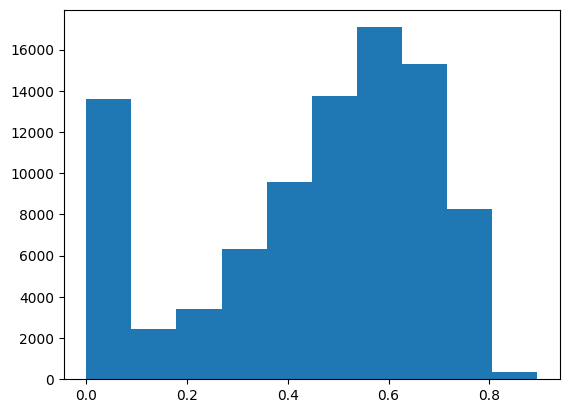

In [91]:
plt.hist(test_pred_total_mean)

In [92]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun.csv', index=False)